In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import requests
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import os

sns.set_palette('Spectral')
sns.set_context('notebook', font_scale=1)
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

import warnings

warnings.filterwarnings('ignore')

# **PREPARE FUNCTION**

In [2]:
# create function to transform timedelat to minute
def timedelta_to_hour(timedelta_str):
    # Konversi timedelta string ke timedelta object
    timedelta_obj = pd.to_timedelta(timedelta_str)
    
    # Hitung total detik dalam timedelta
    total_seconds = timedelta_obj.total_seconds()
    
    # Konversi total detik ke jam
    total_hour = total_seconds / 3600
    
    return total_hour

In [3]:
# create transform curency
def rupiah(value):
    str_value = str(value)
    separate_decimal = str_value.split(".")
    after_decimal = separate_decimal[0]
    before_decimal = separate_decimal[1]

    reverse = after_decimal[::-1]
    temp_reverse_value = ""

    for index, val in enumerate(reverse):
        if (index + 1) % 3 == 0 and index + 1 != len(reverse):
            temp_reverse_value = temp_reverse_value + val + "."
        else:
            temp_reverse_value = temp_reverse_value + val

    temp_result = temp_reverse_value[::-1]

    return "Rp " + temp_result + "," + before_decimal

In [4]:
def similairty_sentence(text1, text2):
    # Menggunakan regex untuk memisahkan teks berdasarkan simbol dan spasi
    tokens1 = ''.join(re.split(r'\W+', text1.lower()))
    tokens2 = ''.join(re.split(r'\W+', text2.lower()))

    # Menghitung frekuensi kata dalam masing-masing teks
    counter1 = Counter(tokens1)
    counter2 = Counter(tokens2)

    # Menghitung dot product
    dot_product = sum(counter1[word] * counter2[word] for word in counter1 if word in counter2)

    # Menghitung magnitudo dari vektor tiap teks
    magnitude1 = math.sqrt(sum(counter1[word] ** 2 for word in counter1))
    magnitude2 = math.sqrt(sum(counter2[word] ** 2 for word in counter2))

    # Menghindari pembagian oleh nol
    if magnitude1 == 0 or magnitude2 == 0:
        return 0

    # Menghitung cosine similarity
    similarity = dot_product / (magnitude1 * magnitude2)
    
    return similarity

In [5]:
def read_file(path, sheet=''):
    list_file = os.listdir(path)
    try:
        list_file.remove('.DS_Store')
    except:
        None
    
    msg = []
    for i in list_file:
        if sheet == '':
            msg.append(pd.read_excel(path + '/' + i))
        else:
            msg.append(pd.read_excel(path + '/' + i, sheet_name=sheet))
    msg = pd.concat(msg)
    msg.reset_index(drop=True, inplace=True)
    return msg

In [6]:
def get_work_date(x):
    x = str(x).split()[0]
    
    date_start = str(x).split()[0] + ' 07:00:00'
    date_end = str(x).split()[0] + ' 17:00:00'
    msg = {'start':date_start, 'end':date_end}
    return msg

In [7]:
def retext_equipment_name_t1(x):
    if x in ['SAKAI SAKAI SV 525 D']:
        msg = 'SAKAI SV'
    else:
        if x in ['KOMATSU PC200-8M1','KOMATSU PC200-10/S21','KOMATSU PC200-8M0','KOMATSU PC200-8']:
            msg = 'KOMATSU PC200'
        elif x in ['KOMATSU PC195LC', 'KOMATSU PC195LC','KOMATSU PC195-LC', 'KOMATSU PC195LC-8', 'KOMATSU PC195LC-8']:
            msg = 'KOMATSU PC195'
        elif x in ['HINO WU352R-HKMRJD8B','HINO WU352R-HKMRJD3L']:
            msg = 'HINO WU352R'
        elif x in ['KOBELCO SK 200','KOBELCO SK200-10','KOBELCO SK330-14','KOBELCO SK', 'KOBELCO SK 200']:
            msg = 'KOBELCO SK200'
        elif x in ['KOBELCO SK 330']:
            msg = 'KOBELCO SK330'
        elif x in ['KOMATSU PC300SE-8','KOMATSU PC300SE-8MO','KOMATSU PC300-8M0','KOMATSU PC300SE-8M0']:
            msg = 'KOMATSU PC300'
        elif x in ['KOMATSU PC400LCSE-8']:
            msg = 'KOMATSU PC400'
        elif x in ['KOMATSU D85ESS-2','KOMATSU D85E-SS-2']:
            msg = 'KOMATSU D85'
        elif x in ['KOMATSU D65P-12']:
            msg = 'KOMATSU D65'
        elif x in ['KOMATSU GD511A-1','KOMATSU GD535-5']:
            msg = 'KOMATSU GD'
        elif x in ['KOMATSU HM400-3R','KOMATSU HM400']:
            msg = 'KOMATSU HM400'
        elif x in ['KOMATSU PC500LC-10R']:
            msg = 'KOMATSU PC500'
        elif x in ['PAJERO SPORT','PAJERO']:
            msg = 'PAJERO'
        else:
            msg = x.split('-')[0]
    return msg

In [8]:
def retext_equipment_name(x):
    if x in ['HINO ZY1EWPD-XS','HINO ZY1EWRD-XS','HINO ZY1EWRN-XS']:
        msg = 'HINO ZY'
    elif x in ['HINO ZS1EPPD-XS']:
        msg = 'HINO ZS'
    else:
        msg = retext_equipment_name_t1(x)
    return msg

In [9]:
def company_to_kontrak(x):
    if x == 'CV. SENTOSA ABADI' or x == 'PT. SENTOSA ABADI MINING':
        msg = 'Mining BDM'
    elif x == 'CV. Adil Prima Perkasa':
        msg = 'Mining KBM'
    else:
        msg = 'Tidak Diketahui'
    return msg

In [10]:
# fungsi membuat rentang tanggal
def create_date_range_dataframe(start_year: int, end_year: int):
    # Tentukan tanggal awal dan akhir berdasarkan input tahun
    start_date = datetime(start_year, 1, 1)
    end_date = datetime(end_year, 12, 31)
    
    # Buat list untuk menyimpan rentang tanggal
    date_range = []

    # Hitung jumlah hari dari tanggal awal hingga tanggal akhir
    delta = end_date - start_date

    # Tambahkan setiap tanggal dalam rentang tersebut ke dalam list
    for i in range(delta.days + 1):
        date = start_date + timedelta(days=i)
        date_range.append(date)

    # Buat DataFrame dari list rentang tanggal
    date_df = pd.DataFrame({'date': date_range})

    # Ubah format tanggal menjadi 'YYYY-MM-DD'
    date_df['date'] = date_df['date'].apply(lambda x: str(x).split()[0])

    return date_df

In [11]:
from datetime import datetime, timedelta

# Tentukan tanggal awal (1 Januari 2023)
start_date = datetime(2023, 1, 1)

# Tentukan tanggal hari ini
today = datetime.today()

# Buat list untuk menyimpan rentang tanggal
date_range = []

# Hitung jumlah hari dari tanggal awal hingga hari ini
delta = today - start_date

# Tambahkan setiap tanggal dalam rentang tersebut ke dalam list
for i in range(delta.days + 1):
    date = start_date + timedelta(days=i)
    date_range.append(date)

date = pd.DataFrame({'date':date_range})
date['date'] = date['date'].apply(lambda x: str(x).split()[0])
date['month'] = pd.to_datetime(date['date']).dt.strftime('%m/%y')

_ = []
for i in date.month.unique().tolist():
    n = date[date.month==i]
    n['count_day'] = len(n)
    _.append(n)

date = pd.concat(_)

In [12]:
# Definisikan fungsi untuk menghitung jumlah nilai unik
def unique_count(series):
    return len(np.unique(series))

# **ETL : Extracting, Transforming, Loading**

## Maintenance.Request

In [13]:
path_mr = '/Users/dickyaryanto/Documents/PT Sentosa Abadi Mining/Data/maintenance request'
df2 = read_file(path_mr)

df2['Broken Date'] = df2['Broken Date'].apply(lambda x: str(x))
df2['Request Date'] = df2['Request Date'].apply(lambda x: str(x))
df2['Scheduled Date'] = df2['Scheduled Date'].apply(lambda x: str(x))
df2['Completion Date'] = df2['Completion Date'].apply(lambda x: str(x))

def transformasi_nan_format(x):
    con = str(x)
    if con == 'NaT' or con == 'nan':
        msg = np.NaN
    else:
        msg = x
    return msg

df2['Broken Date'] = df2['Broken Date'].apply(transformasi_nan_format)
df2['Request Date'] = df2['Request Date'].apply(transformasi_nan_format)
df2['Scheduled Date'] = df2['Scheduled Date'].apply(transformasi_nan_format)
df2['Completion Date'] = df2['Completion Date'].apply(transformasi_nan_format)

def completion_end_day(broken, done):
    con = str(done)
    if con == 'nan' or con == 'NaN' or con == np.NaN:
        date = str(broken).split()[0]
        date_time = date + ' 17:00:00'
        con2 = date_time.split()[0]
        if con2 == 'nan':
            date_time = np.NaN
        else:
            date_time = date_time
    else:
        date_time = done
    return date_time

df2['Completion Date'] = df2.apply(lambda x: completion_end_day(x['Broken Date'], x['Completion Date']), axis=1)
df2['Scheduled Date'] = df2.apply(lambda x: completion_end_day(x['Broken Date'], x['Completion Date']), axis=1)

df2 = df2.ffill()

path_p = '/Users/dickyaryanto/Documents/PT Sentosa Abadi Mining/Data/stock picking'
picking = read_file(path_p)

df2['Request Date'] = pd.to_datetime(df2['Request Date'])
df2 = df2[df2['Request Date'].dt.year>=2023]

# merge data df2 terkecuali berstatus Cancelles
def get_service(x):
    if x == '':
        msg = 'Service'
    else:
        msg = x
    return msg

df2['Picking Line/Status'] = df2['Picking Line/Status'].apply(get_service)
df2 = df2[df2['Picking Line/Status'].isin(['Service','Ready','Done'])]
df2 = df2.merge(picking[['Reference','Stock Moves/Product','Stock Moves/Quantity Done','Stock Moves/Unit of Measure']], left_on='Picking Line/Reference', right_on='Reference', how='left')

# refill data
df2_1 = df2[df2['Picking Line/Status']=='Service']
df2_1['Reference'] = '-'
df2_1['Stock Moves/Product'] = '-'
df2_1['Stock Moves/Quantity Done'] = 0
df2_1['Stock Moves/Unit of Measure'] = '-'

df2_2 = df2[df2['Picking Line/Status']!='Service']
df2 = pd.concat([df2_1, df2_2])

# extract maintenance.request
df = df2.copy()
df.columns = ['_'.join(i.split()).lower() for i in df.columns]
df.drop(columns='reference', inplace=True)

# transformasi tipe data
df['request_date'] = pd.to_datetime(df['request_date'])
df = df[df.request_date.dt.year >= 2023]

df.columns=['company','spk','stage','broken','request','schedule','done','oprator','category_equipment','equipment_name',
            'equipment_code','hm','km','requirement_type','type_maintenance','category_maintenance','picking_reference','picking_status','note','description','qty','uom']
df['oprator_name'] = df.oprator.apply(lambda x: str(x).split('] ')[-1])
df = df[df.spk!='D85-06']
df = df[df.spk!='PC200-12']
df['spk'] = df.spk.apply(lambda x: int(str(x).split('/')[-1]))
df.sort_values('spk', ascending=False, inplace=True)
df['spk'] = df['spk'].astype(str)

def get_description(x):
    if x == False:
        msg = 'Service Only'
    else:
        msg = x
    return msg

df['description'] = df['description'].apply(get_description)
df['uom'] = df['uom'].apply(lambda x: str(x).upper())


In [14]:
# check = kpi[kpi.date=='2024-06-30']
# check = check[check.category_equipment=='HEAVY EQUIPMENT']
# check = check[check.production!='-']
# check.to_excel('Data Produktivitas Heavy Equipment 30 Juni 2024.xlsx', index=False)

In [15]:
df['broken'] = pd.to_datetime(df['broken'])
df['request'] = pd.to_datetime(df['request'])
df['schedule'] = pd.to_datetime(df['schedule'])
df['done'] = pd.to_datetime(df['done'])
df['hm'] = df['hm'].astype(float)
df['km'] = df['km'].astype(float)

_ = df[df.category_equipment==False]
_['category_equipment'] = 'Tidak Diketahui'
_['equipment_name'] = 'Tidak Diketahui'
_['equipment_code'] = 'Tidak Diketahui'
__ = df[df.category_equipment!=False]
df = pd.concat([_, __]).sort_values('spk', ascending=False)

# apply function
df['equipment_name'] = df['equipment_name'].apply(retext_equipment_name)
df['category_maintenance'].replace('TRYE', 'TYRE', inplace=True)
df['category_maintenance'].replace('TRYE (Archive)', 'TYRE', inplace=True)
df['category_maintenance'].replace('TYRE-PENGGANTIAN', 'TYRE', inplace=True)
df['category_maintenance'].replace('TYRE-PERBAIKAN', 'TYRE', inplace=True)

# buat table category maintenance
tbl_cm = df[df.category_maintenance!=False][['category_maintenance','description']].drop_duplicates()

def get_correct_category_maintenance(x):
    n = tbl_cm[tbl_cm.description == x]
    if len(n) == 0:
        try:
            n = tbl_cm.copy()
            n['score'] = n.description.apply(lambda i: similairty_sentence(x, i))
            n = n.sort_values('scor', ascending=False)
            msg = n['category_maintenance'].uniqeu().tolist()[0]
        except:
            msg = x
    else:
        msg = n['category_maintenance'].unique().tolist()[0]
    return msg 

df_ = df[df.category_maintenance!=False]
df__ = df[df.category_maintenance==False]

df__['category_maintenance'] = df__.description.apply(get_correct_category_maintenance)
df = pd.concat([df_, df__])

In [16]:
df[df.spk=='92818']

,company,spk,stage,broken,request,schedule,done,oprator,category_equipment,equipment_name,equipment_code,hm,km,requirement_type,type_maintenance,category_maintenance,picking_reference,picking_status,note,description,qty,uom,oprator_name
44133,CV. SENTOSA ABADI,92818,DONE,2024-07-01 14:42:48,2024-07-01,2024-07-02 04:40:00,2024-07-02 04:40:00,[0212221713] ISKARI,DUMP TRUCK,HINO ZY,DT-316/E13CWD 20535,9289.0,145763.0,External,Corrective,UNDERCARRIAGE,False,Done,<p><br></p>,NaN,NaN,NAN,ISKARI


## Product.Template

In [17]:
### extract product.template
path_pt = '/Users/dickyaryanto/Documents/PT Sentosa Abadi Mining/Data/product template'
product = read_file(path_pt)
product.columns = ['_'.join(i.lower().split()) for i in product.columns]
product['unit_of_measure'] = product['unit_of_measure'].apply(lambda x: str(x).upper())
product['name2'] = '#' + product['name'] + '#' + product['unit_of_measure']
product.drop_duplicates(subset='product', inplace=True)

# merge data product untuk dapatkan cost
df = pd.merge(df, product[['name', 'product','cost']], left_on='description', right_on='product', how='left').drop(columns='product')
df['cost'].fillna(0, inplace=True)
df['cost'] = df['cost'].astype(float)
df['qty'] = df['qty'].astype(float)

df['description'] = df['description'].apply(lambda x: str(x))
df['qty'] = df['qty'].apply(lambda x: str(x))
df['cost'] = df['cost'].apply(lambda x: str(x))

def get_decription(x):
    con = str(x)
    if con == 'nan':
        msg='Service'
    else:
        msg = x
    return msg

def get_qty(x):
    con = str(x)
    if con == 'nan':
        msg=0
    else:
        msg = x
    return msg

df['description'] = df.description.apply(get_description)
df['qty'] = df['qty'].apply(get_qty)
df['cost'] = df['cost'].apply(get_qty)
df = df.rename(columns={'name':'description_2'})
df['description_2'] = df['description_2'].apply(lambda x: str(x))
df['description_2'] = df.description_2.apply(get_description)
df['description_2'] = df['description_2'].replace('nan', 'Service')
df['description'] = df['description'].replace('nan', 'Service')
df['uom'] = df['uom'].replace('NAN', '-')
df['cost'] = df['cost'].astype(float)
df['qty'] = df['qty'].astype(float)

# conditional
a = df[df.equipment_name=='HONGYAN KINKAN430']
b = df[df.equipment_name!='HONGYAN KINKAN430']
a.requirement_type.replace('External', 'Internal', inplace=True)
df = pd.concat([a, b])

## Standar Pengukuran

In [18]:
path_standar_ukur = '/Users/dickyaryanto/Documents/PT Sentosa Abadi Mining/Data/standar ukur/'

tbl_jarak = read_file(path_standar_ukur, 'tbl jarak move type')
tbl_kapasitas = read_file(path_standar_ukur, 'tbl kapasitas dt')
tbl_waktu = read_file(path_standar_ukur, 'tbl waktu move type')
tbl_periodical = read_file(path_standar_ukur, 'tbl periodical unit')

## Production.Timesheet

In [19]:
### extract production.timesheet
path_ts = '/Users/dickyaryanto/Documents/PT Sentosa Abadi Mining/Data/production timesheet'
df2 = read_file(path_ts)

df2.columns = ['_'.join(i.split()).lower() for i in df2.columns]
df2 = df2[df2.date.dt.year >= 2023]

# df2 = df2[df2['date']!=pd.to_datetime(str(pd.to_datetime(datetime.now())).split()[0])]
df2['hm_realtime_start'] = df2['hm_realtime_start'].apply(lambda x: str(x).split('.')[0])
df2['hm_realtime_end'] = df2['hm_realtime_end'].apply(lambda x: str(x).split('.')[0])

def get_true_time(date, time):
    time = str(time)
    if len(time) == 2:
        time = str(time) + ':00:00'
    else:
        time = '0' + str(time) + ':00:00'
        
    date = str(date).split()[0]
    msg = date + ' ' + time

    try:
        a = pd.to_datetime(msg)
    except:
        msg = 'error'
    
    return msg

df2['date_engine_start'] = df2.apply(lambda x: get_true_time(x['date'], x['hm_realtime_start']), axis=1)
df2['date_engine_end'] = df2.apply(lambda x: get_true_time(x['date'], x['hm_realtime_end']), axis=1)

# split data
df2_err = df2[(df2['date_engine_start']=='error') & (df2['date_engine_end']=='error')]
df2 = df2[(df2['date_engine_start']!='error') & (df2['date_engine_end']!='error')]

df2['date_engine_start'] = pd.to_datetime(df2['date_engine_start'])
df2['date_engine_end'] = pd.to_datetime(df2['date_engine_end'])

# cleaning condition memungkinkan tidak akan digunakan bila data bersih
df2_err['actual_engine'] = df2_err['hm_realtime_end'].astype(float) - df2_err['hm_realtime_start'].astype(float)
def retext_time(x):
    time = str(x)
    if len(time) == 2:
        time = str(time) + ':00:00'
    else:
        time = '0' + str(time) + ':00:00'
    return time

def get_time_from_err(x):
    start = 7
    end = start + x

    start_time = retext_time(str(start))
    end_time = retext_time(str(end).split('.')[0])

    msg = {'start':start_time, 'end':end_time}
    return msg

df2_err['hm_realtime_end'] = df2_err['actual_engine'].apply(lambda x: get_time_from_err(x)['end'])
df2_err['hm_realtime_start'] = df2_err['actual_engine'].apply(lambda x: get_time_from_err(x)['start'])

df2_err['date_engine_start'] = df2_err['date'].apply(lambda x: str(x).split()[0]) + ' ' + df2_err['hm_realtime_start']
df2_err['date_engine_end'] = df2_err['date'].apply(lambda x: str(x).split()[0]) + ' ' + df2_err['hm_realtime_end']

df2_err['date_engine_start'] = pd.to_datetime(df2_err['date_engine_start'])

_ = []
for i in df2_err.index:
    n = df2_err[df2_err.index==i]
    try:
        n['date_engine_end'] = pd.to_datetime(n['date_engine_end'])
    except:
        n['date_engine_end'] = 'error'
    _.append(n)

df2_err = pd.concat(_)

In [20]:
# transform data
error_actual_date = df2_err[df2_err.date_engine_end=='error']
error_actual_date = error_actual_date.merge(df[['equipment_name','equipment_code']].drop_duplicates(), left_on='equipment', right_on='equipment_code', how='left').drop(columns='equipment_code')
error_actual_date = error_actual_date.merge(tbl_kapasitas[['equipment_name','rerata_muatan']], on='equipment_name', how='left')
error_actual_date['pred_retase'] = np.round((error_actual_date['component_line/net_weight/voll']/1000) / error_actual_date.rerata_muatan)
error_actual_date = error_actual_date.merge(tbl_waktu, on='move_type', how='left')
error_actual_date['actual_engine'] = error_actual_date.pred_retase * error_actual_date.waktu
error_actual_date = error_actual_date.drop(columns=['pred_retase','equipment_name','rerata_muatan','waktu'])

# concat data
df2_err = df2_err[df2_err.date_engine_end!='error']
df2 = pd.concat([df2, df2_err])

df2['date_engine_end'] = pd.to_datetime(df2['date_engine_end'])
df2['date_engine_start'] = pd.to_datetime(df2['date_engine_start'])
df2['actual_engine'] = df2.date_engine_end - df2.date_engine_start
df2['actual_engine'] = df2['actual_engine'].apply(timedelta_to_hour)

df2 = pd.concat([df2, error_actual_date])
# df2 = df2[df2.state!='Draft']

In [21]:
df2['component_line/out_weight'].fillna(0, inplace=True)
df2['component_line/net_weight/voll'].fillna(0, inplace=True)
df2['production'].replace('ROAD MAINTENANCE', 'Road Maintenance', inplace=True)

## Maintenance.Equipment

In [22]:
path_eq = '/Users/dickyaryanto/Documents/PT Sentosa Abadi Mining/Data/maintenance equipment'
tbl_equipment2 = read_file(path_eq)
tbl_equipment2['equipment_code'] = tbl_equipment2.Name.apply(lambda x: str(x) + '/') + tbl_equipment2['Serial Number'].apply(lambda x: str(x))
tbl_equipment2.columns = ['_'.join(i.lower().split()) for i in tbl_equipment2.columns.tolist()]

# dapatkan tabel equipment 
tbl_eq = tbl_equipment2[['company','equipment_category','equipment_model','name']]
tbl_eq['equipment_model'] = tbl_eq['equipment_model'].apply(retext_equipment_name)
tbl_eq.columns = ['company','category_equipment','equipment_name','name']
tbl_eq['equipment_name'] = tbl_eq.equipment_name.apply(retext_equipment_name)

## Purchase.Order

### 1. PO Node3

In [23]:
path_po = '/Users/dickyaryanto/Documents/PT Sentosa Abadi Mining/Data/purchase order'
po = read_file(path_po)

po.columns = ['_'.join(i.lower().split()) for i in po.columns]
po['total'] = po['order_lines/quantity'] * po['order_lines/unit_price']
po = po.ffill()
po.drop(columns=['source_document','purchase_requests','order_lines/description'], inplace=True)
po = po.rename(columns={
    'order_reference':'no_po',
    'purchase_request':'no_pr',
    'order_lines/unit_price':'price',
    'order_lines/quantity':'qty',
    'order_lines/unit_of_measure':'uom',
    'order_lines/disc.%':'discount',
    'order_lines/product':'description',
    'receipt_date':'date'
})
po['discount'] = po.discount / 100
po['total'] = po.total - (po.total * po.discount)
po['total'] = po.total + (po.total * 0.11)
po['no_spk'] = po['no_spk'].apply(lambda x: str(str(x).split('/')[-1]))
po = po[['date','no_pr','no_po','no_spk','description','qty','uom','price','discount','total']]
po['sumber'] = 'PO SA'

### 2. PO Selain Dari Node3

In [24]:
### extract data PO diluar Node3 ambil dari Google Drive 
url = "https://docs.google.com/spreadsheets/d/1Ay0TNz8yPhdNzr4KhGmNy1QENGJS6B-Z/export?format.xlsx"

try:
    os.remove('po_sam.xlsx')
except:
    None
    
output_filename = "po_sam.xlsx"

# get the data from spreadsheet
response = requests.get(url)
if response.status_code == 200:
    with open(output_filename, "wb") as f:
        f.write(response.content)

# transformasi nama columns
po_sam = pd.read_excel('po_sam.xlsx', sheet_name='Sheet1')
po_sam.columns = ['_'.join(i.lower().split()) for i in po_sam.columns]
po_sam['spk'].fillna('kosong', inplace=True)
po_sam = po_sam[po_sam.spk!='kosong']
po_sam = po_sam[['date','spk','wo','customer','id','unnamed:_10','unnamed:_11','unnamed:_12','unnamed:_13','unnamed:_14','remark']]
po_sam.columns = ['date','spk_sam','spk_sa','customer','name','description','qty','discount','price','total','stage']

def get_same_text(text1):
    n = tbl_equipment2.copy()
    n['similairity'] = n.name.apply(lambda x: similairty_sentence(text1, x))
    n.sort_values('similairity', ascending=False, inplace=True)
    n = n.head(1)

    score = n['similairity'].unique().tolist()[0]
    if score >= 0.9:
        try:
            cat_eq = n['equipment_category'].unique().tolist()[0]
            eq_model = n['equipment_model'].unique().tolist()[0]
            name = n['name'].unique().tolist()[0]
            id = n['serial_number'].unique().tolist()[0]
            msg = {'cat_eq':[cat_eq],'eq_model':[eq_model],'name':[name],'id':[id]}
        except:
            msg = {'cat_eq':[np.NaN],'eq_model':[np.NaN],'name':[text1],'id':[np.NaN]}
    else:
        msg = {'cat_eq':[np.NaN],'eq_model':[np.NaN],'name':[text1],'id':[np.NaN]}
        
    return msg

def get_same_text_category_maintenance(text1):
    n = df.copy()
    n = n[['category_maintenance','description']]
    n.drop_duplicates(inplace=True)
    n['similairity'] = n.description.apply(lambda x: similairty_sentence(text1, x))
    n.sort_values('similairity', ascending=False, inplace=True)
    n = n.head(1)

    score = n['similairity'].unique().tolist()[0]
    if score >= 0.8:
        try:
            msg = n['category_maintenance'].unique().tolist()[0]
        except:
            msg = np.NaN
    else:
        msg = np.NaN
        
    return msg

po_sam.description.fillna('HMSI', inplace=True)
po_sam.discount.fillna(0, inplace=True)
po_sam['no_pr'] = '-'
po_sam['uom'] = '-'
po_sam['no_po'] = '-'
po_sam = po_sam[['date','no_pr','spk_sam','spk_sa','description','qty','uom','price','discount','total']].rename(columns={'spk_sa':'no_spk','spk_sam':'no_po'})
po_sam['no_spk'] = po_sam.no_spk.apply(lambda x: ''.join(str(x).split('.')))
po_sam['sumber'] = 'PO SAM'

In [25]:
po = pd.concat([po, po_sam])

## Produksi Actual Site

### 1. Absen Driver

In [26]:
url = "https://docs.google.com/spreadsheets/d/1CDBo-9hz0-Vc7e-hgjG1qdIZ07-PEdLlMatzssJhTJU/export?format.xlsx"
try:
    os.remove('absen_driver.xlsx')
except:
    None
    
output_filename = 'absen_driver.xlsx'

# get the data from spreadsheet
response = requests.get(url)
if response.status_code == 200:
    with open(output_filename, "wb") as f:
        f.write(response.content)

# read data absen driver dari tbl produksi actual site
absen_driver = pd.read_excel('absen_driver.xlsx', sheet_name='Absen Driver')
absen_driver = absen_driver[1:]
absen_driver.columns = ['_'.join(i.lower().split()) for i in absen_driver.columns]
absen_driver = absen_driver[['nama_driver','id_unit','project','date','jam_keluar','jam_masuk','total_jam_kerja','retase','keterangan']]
absen_driver.columns = ['driver','name','project/name','date','jam_keluar','jam_masuk','total_jam_kerja','retase','keterangan']

absen_driver['driver'].fillna('Tidak Diketahui', inplace=True)
absen_driver['name'] = absen_driver.name.apply(lambda x: 'DT-' + x[-3:])
absen_driver['date'] = absen_driver['date'].apply(lambda x: str(x).split()[0])
absen_driver['total_jam_kerja'].fillna('-', inplace=True)

### 2. Grade

In [27]:
url = "https://docs.google.com/spreadsheets/d/12_BTs8ftDwcp0DCva7wTZzLuzaE9nkKrgJ_onoqMbDM/export?format.xlsx"
try:
    os.remove('grade_report.xlsx')
except:
    None
    
output_filename = 'grade_report.xlsx'

# get the data from spreadsheet
response = requests.get(url)
if response.status_code == 200:
    with open(output_filename, "wb") as f:
        f.write(response.content)

# read data grade
df_grade = pd.read_excel('grade_report.xlsx', sheet_name='Laporan Grade')
df_grade = df_grade[1:]
df_grade = df_grade[['Date','AP6','AP7','AP8','AP9','AP10','AP11','KBM C','KMB D','KBM E','TUJUAN PABRIK',
          'TONASE','% GRADE (LAB. SM)','Unnamed: 14','Unnamed: 15','% GRADE (LAB. Feeding)','Unnamed: 17','Unnamed: 18']]
df_grade.columns = ['date','ap6','ap7','ap8','ap9','ap10','ap11','kmb_c','kmb_d','kmb_e','pabrik','produksi','sm_ni','sm_fe','sm_si','f_ni','f_fe','f_si']

# cleaning data
df_grade['date'] = df_grade['date'].apply(lambda x: str(x).split()[0])
df_grade['pabrik'].fillna('-', inplace=True)
df_grade.fillna(0, inplace=True)
df_grade = df_grade[df_grade.pabrik!='-']

df_grade['sm_ni'] = df_grade['sm_ni'].apply(lambda x: float(str(x).split('%')[0]))
df_grade['sm_fe'] = df_grade['sm_fe'].apply(lambda x: float(str(x).split('%')[0]))
df_grade['sm_si'] = df_grade['sm_si'].apply(lambda x: float(str(x).split('%')[0]))
df_grade['produksi'] = df_grade['produksi'].apply(lambda x: float(''.join(str(x).split(','))))

grade = df_grade[['date','ap6','ap7','ap8','ap9','ap10','ap11','kmb_c','kmb_d','kmb_e','pabrik','produksi','sm_ni','sm_fe','sm_si']]

In [28]:
df_grade.to_excel('./Report/grade control.xlsx', index=False)

### 3. Accdient Rate

In [29]:
url = "https://docs.google.com/spreadsheets/d/19y9xZ3L3AMYGDZOVG_6Q5hNX7HFQSW__tf6YXX_Ojgk/export?format.xlsx"
try:
    os.remove('accident_rate.xlsx')
except:
    None
    
output_filename = 'accident_rate.xlsx'

# get the data from spreadsheet
response = requests.get(url)
if response.status_code == 200:
    with open(output_filename, "wb") as f:
        f.write(response.content)

# read data absen driver dari tbl produksi actual site
accident = pd.read_excel('accident_rate.xlsx')
accident = accident[1:]
accident.columns = ['timestamps','id','date','no_ba','kat_kecelakaan','tempat',
                    'name','departemen','employee','umur','estimate','keterangan','id_user','user']
accident = accident.drop(columns=['id_user','user'])

In [30]:
accident

,timestamps,id,date,no_ba,kat_kecelakaan,tempat,name,departemen,employee,umur,estimate,keterangan
1,2024-06-25 14:33:01.728,0,2024-01-04 00:00:00,001/BA/SA-HSE/I/2024,Property Demage,Workshop,LV-10,Workshop,zulfadli aftitah,NaN,NaN,"Memindahkan unit LV 10 dari workshop tyre, seh..."
2,2024-06-25 14:33:01.728,1,2024-01-04 00:00:00,001/EKS/BA/BDM-HSE/KON/I/2024,Near Miss,Jalan Angkut/Hauling Road,DT-161,Kendaraan & Unit Support,[110231845] SELIN,NaN,NaN,KENDARAAN DT SA 161 TERGELINCIR TIDAK MAMPU ME...
3,2024-06-25 14:33:01.728,2,2024-01-07 00:00:00,001/BA/SA-HSE/KON/I/2024,Property Demage,Jalan Angkut/Hauling Road,DT-268,Kendaraan & Unit Support,kevin,NaN,NaN,KENDARAAN DT SA 268 MENABRAK VESSEL DT BMS
4,2024-06-25 14:33:01.728,#REF!,2024-01-17 00:00:00,002/BA/SA-HSE/KON/I/2024,Near Miss,Jalan Angkut/Hauling Road,DT-347,Kendaraan & Unit Support,[212201312] I WAYAN RUDI YASTAWA,NaN,NaN,"Masuk Emergency Stop, karena rem kurang pakem"
5,2024-06-25 14:33:01.728,#REF!,2024-01-17 00:00:00,005/BA/SA-HSE/I/2024,Property Demage,Pabrik,DT-398,Kendaraan & Unit Support,[101211334] YATMAN F PANGANDE,NaN,NaN,Dump truck Pabrik tiba-tiba berhenti karena ad...
...,...,...,...,...,...,...,...,...,...,...,...,...
105,2024-06-25 14:33:01.728,#REF!,2023-12-02 00:00:00,NaN,Property Demage,0,DT-363,Kendaraan & Unit Support,[203221603] ROY BARAU,NaN,NaN,0
106,2024-06-25 14:33:01.728,#REF!,2023-12-06 00:00:00,NaN,Property Demage,0,DT-501,Kendaraan & Unit Support,[112201318] MIDUN HULOPI,NaN,NaN,NaN
107,2024-06-25 14:33:01.728,#REF!,2023-12-07 00:00:00,NaN,Property Demage,0,DT-262,Kendaraan & Unit Support,[205231765] RICHARD VALDO SADURI,NaN,NaN,NaN
108,NaT,NaN,NaN,NaN,Property Demage,0,DT-213,Kendaraan & Unit Support,-,NaN,NaN,NaN


### 4. Fuel & Fuel Cost

In [31]:
# buat kolom bulan di dataframe date
date['month'] = pd.to_datetime(date.date).dt.strftime('%m/%y')

# dapatkan nilai fuel
url_konsumsi = "https://docs.google.com/spreadsheets/d/1Q9nZYOoRZZL_PB6wUPDyBtzuWJv2qZXpbXYlt7wrGho/export?format.xlsx"

try:
    os.remove('fuel_comsumption.xlsx')
except:
    None
    
output_filename = 'fuel_comsumption.xlsx'

# get the data from spreadsheet
response = requests.get(url_konsumsi)
if response.status_code == 200:
    with open(output_filename, "wb") as f:
        f.write(response.content)

# read data
fuel = pd.read_excel(output_filename)
fuel = fuel[fuel.index>0].reset_index(drop=True).drop(columns='CODE USER')
fuel.columns = ['_'.join(i.lower().split()) for i in fuel.columns]
fuel = fuel.rename(columns={'id_unit':'name'})
fuel = fuel.merge(tbl_eq[['category_equipment','equipment_name','name']].drop_duplicates(), on='name', how='left')
fuel['timestamps'].fillna('kosong', inplace=True)
fuel = fuel[fuel.timestamps != 'kosong']
fuel['move_type'].fillna('Tidak Diketahui', inplace=True)
fuel['hm_saat_isi_fuel'].fillna(0, inplace=True)
fuel['km_saat_isi_fuel'].fillna(0, inplace=True)

fuel['id'] = fuel['id'].astype(int)
id_bulanan = list(np.arange(589, 2554))

# buat kondisi laporan karena laporan pemakaian fuel sebelumnya dalam bulanan 
def get_id_condtional(x):
    if x in id_bulanan: 
        msg = 'Konsumsi Bulanan'
    else:
        msg = 'Konsumsi Harian'
    return msg
    
fuel['report_type'] = fuel['id'].apply(get_id_condtional)
fuel = fuel[['timestamps','id','report_type','date','project','production','move_type','category_equipment','equipment_name',
             'name','hm_saat_isi_fuel','km_saat_isi_fuel','fuel_consumption','user']]

fuel['date'] = pd.to_datetime(fuel['date']).dt.date
fuel = fuel.groupby(['date','report_type','category_equipment','equipment_name','name'])[['fuel_consumption']].sum().reset_index().rename(columns={'fuel_consumption':'fuel'})
fuel_m = fuel[fuel.report_type=='Konsumsi Bulanan']
fuel_m['month'] = pd.to_datetime(fuel_m.date).dt.strftime('%m/%y')

_ = []
for name in tqdm(fuel_m.name.unique().tolist()):
    n = fuel_m[fuel_m.name == name]
    for month in n.month.unique().tolist():
        m = n[n.month==month]

        cat_eq = m.category_equipment.unique().tolist()[0]
        eq_name = m.equipment_name.unique().tolist()[0]
        name = name
        count_day = len(date[date.month==month])
        fuel_per_day = m.fuel.sum()/count_day
        
        msg = date[date.month==month][['date']].merge(m, on='date', how='left').drop(columns=['report_type','month'])
        msg['category_equipment'] = cat_eq
        msg['equipment_name'] = eq_name
        msg['name'] = name
        msg['fuel'] = fuel_per_day
        _.append(msg)
fuel_m = pd.concat(_)
fuel_h = fuel[fuel.report_type!='Konsumsi Bulanan'].drop(columns=['report_type'])
fuel = pd.concat([fuel_m, fuel_h])
fuel['date'] = pd.to_datetime(fuel['date']).dt.date

# dapatkan data harga fuel
url_price_fuel = "https://docs.google.com/spreadsheets/d/1BJC_Wc58T9LxnW7ZLimpNIA_1ZRijaaDF2DiJe6jlPs/export?format.xlsx"
try:
    os.remove('fuel_price.xlsx')
except:
    None
    
output_filename = 'fuel_price.xlsx'
# get the data from spreadsheet
response = requests.get(url_price_fuel)
if response.status_code == 200:
    with open(output_filename, "wb") as f:
        f.write(response.content)

# read data
fuel_price = pd.read_excel(output_filename)
fuel_price.columns = ['date','fuel_type','price','pbb_kb']
fuel_price['price2'] = fuel_price.price + fuel_price.pbb_kb
fuel_price.sort_values('date', ascending=True, inplace=True)
fuel_price['date'] = fuel_price['date'].dt.date
left = date.drop(columns='month')
left['date'] = pd.to_datetime(left['date']).dt.date
fuel_price = left.merge(fuel_price, on='date', how='outer')
fuel_price = fuel_price.bfill().ffill()

# gabungkan data harga fuel 
fuel = fuel.merge(fuel_price[['date','price2']], on='date', how='left')
fuel['fuel_cost'] = fuel.price2 * fuel.fuel

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:01<00:00, 131.63it/s]


# **EDA : Exploratory Data Analyst - 1**

## Task 1.0 : DASHBOARD

Berapa waktu rata-rata yang dibutuhkan untuk team Workshop memperbaiki setiap request dari setiap crew produksi/transportasi?

In [32]:
t1 = df.copy()
t1['t_broken_done'] = t1.done - t1.broken
t1['t_schedule_done'] = t1.done - t1.schedule
t1['requirement_type'].replace('', 'Internal', inplace=True)

t1_in = t1[t1.requirement_type=='Internal']
t1_in['no_po'] = '-'

t1_ex = t1[t1.requirement_type=='External']
t1_ex['spk'] = t1_ex['spk'].apply(lambda x: str(x))
t1_ex.drop(columns=['description','qty','uom','description_2','cost'], inplace=True)

# pertemukan semua yang external kepada po sam
po_spk = po[po.no_spk!='False']
t1_ex = t1_ex.drop_duplicates(subset='spk').merge(po_spk[['no_spk','no_po','description','qty','uom','total']], how='left', left_on='spk', right_on='no_spk')
t1_ex = t1_ex.rename(columns={'total':'cost'})
t1_ex['uom'] = t1_ex['uom'].apply(lambda x: str(x).upper())
t1_ex['no_po'].fillna('-', inplace=True)
t1_ex['description_2'] = t1_ex.description.apply(get_description)
t1_ex['description_2'].fillna('Service', inplace=True)
t1_ex = t1_ex[t1_in.columns]
t1_ex['cost'].fillna(0, inplace=True)
t1_ex['cost'] = t1_ex.cost / t1_ex.qty

t1 = pd.concat([t1_in, t1_ex])
t1 = t1.sort_values('spk', ascending=False).reset_index(drop=True)

# create function to transform timedelat to minute
def timedelta_to_minute(timedelta_str):
    # Konversi timedelta string ke timedelta object
    timedelta_obj = pd.to_timedelta(timedelta_str)
    
    # Hitung total detik dalam timedelta
    total_seconds = timedelta_obj.total_seconds()
    
    # Konversi total detik ke jam
    total_minute = total_seconds / 60
    
    return total_minute

t1['t_broken_done'] = t1['t_broken_done'].apply(timedelta_to_minute)
t1['t_schedule_done'] = t1['t_schedule_done'].apply(timedelta_to_minute)
t1['t_broken_done'].fillna(0, inplace=True)
t1['t_schedule_done'].fillna(0, inplace=True)
t1 = t1[t1.stage != 'Cancel']
t1['cost'] = t1.cost * t1.qty

def get_time(x):
    hours = int(x // 60)
    remaining_minutes = int(x % 60)
    formated_time = f"{hours} Hour {remaining_minutes} Minute"
    formated_time = pd.to_timedelta(formatted_time)
    return formated_time

t1['number'] = 1
t1['category_maintenance'].replace('TRYE', 'TYRE', inplace=True)
t1['name'] = t1.equipment_code.apply(lambda x: str(x).split('/')[0])
t1['equipment_name'] = t1['equipment_name'].apply(lambda x: ' '.join(str(x).split()))
t1['equipment_name'] = t1['equipment_name'].apply(lambda x: retext_equipment_name(x))
t1 = t1[t1.equipment_name!='NISSAN CWA']

# buat fungsi untuk klasfikasi jenis kerusakan secara lebih meluas 
def retext_category_maintenance(x):
    try:
        msg = ' '.join(x.split('] ')[-1].split()[:1]).upper()
    except:
        msg = x
    return msg
    
t1['category_maintenance'] = t1['category_maintenance'].apply(retext_category_maintenance)

# buat fungsi untuk klasfikasi jenis kerusakan secara lebih meluas 
def retext_description_maintenance(x):
    try:
        msg = ' '.join(x.split('] ')[-1].split()[:2]).upper()
    except:
        msg = x
    return msg
t1['description_3'] = t1.description_2.apply(retext_description_maintenance)

In [33]:
check = t1.copy()
check['date'] = pd.to_datetime(check.broken).dt.date
check['date'] = check['date'].apply(lambda x: str(x).split()[0])
check = check[(check.category_maintenance=='TYRE') & (check.description_3.isin(['SERVICE','BAN LUAR']))]

In [34]:
## TEMUKAN KETERANGAN WORKSHOP UNTUK DT TERDAFTAR BERIKUT

# list_dt = ['DT-316','DT-391','DT-398','DT-389','DT-318','DT-369']
# check = t1.copy()
# check['date'] = check.broken.apply(lambda x: str(x).split()[0])
# check = check[check.date.isin(['2024-07-09'])]
# check = check[check.name.isin(list_dt)]
# check = check.drop_duplicates(subset='spk')[['spk','stage','oprator','broken','done','equipment_name','name','t_broken_done']].rename(columns={'t_broken_done':'waktu maintenance'})
# check['waktu maintenance'] = check['waktu maintenance']/60

In [35]:
t1.to_excel('./Report/task1.xlsx', index=False)

## Task 1.1 : DASHBOARD

In [36]:
t1_1 = t1.copy()

t1_1['date_broken'] = pd.to_datetime(t1_1.broken).dt.date
t1_1['category_maintenance'].fillna('Tidak Diketahui', inplace=True)

# retext category maintenance lebih umum
t1_1['category_maintenance'] = t1_1['category_maintenance'].apply(retext_category_maintenance)

broken = t1_1[['stage','broken','requirement_type','type_maintenance','category_maintenance','description_3','category_equipment','equipment_name','spk']]
broken['date'] = broken.broken.dt.date
broken = broken.drop_duplicates(subset='spk')
broken = broken.groupby(['date','requirement_type','type_maintenance','category_maintenance','description_3','category_equipment','equipment_name'])[['stage']].count().reset_index().rename(columns={'stage':'values'})
broken['status'] = 'Broken'

done = t1_1[['stage','done','requirement_type','type_maintenance','category_maintenance','description_3','category_equipment','equipment_name','spk']]
done['date'] = done.done.dt.date
done = done.drop_duplicates(subset='spk')
done = done[done.stage=='DONE']
done = done.groupby(['date','requirement_type','type_maintenance','category_maintenance','description_3','category_equipment','equipment_name'])[['stage']].count().reset_index().rename(columns={'stage':'values'})
done['status'] = 'Done'

t1_1 = pd.concat([broken, done])
t1_1 = t1_1[pd.to_datetime(t1_1.date).dt.year >= 2023]
t1_1 = t1_1.rename(columns={'date':'request'})
t1_1.to_excel('./Report/task1_1.xlsx', index=False)

## Task 2.1 : DASHBOARD

KPI Detail

In [37]:
jam_operasional = df2.groupby(['date','name','company','project','production','move_type','equipment'])[['hm_engine_start','hm_engine_end','component_line/out_weight','component_line/in_weight']].sum().reset_index()
jam_operasional['produksi'] = (jam_operasional['component_line/in_weight'] - jam_operasional['component_line/out_weight'])/1000
jam_operasional.drop(columns=['component_line/out_weight','component_line/in_weight'], inplace=True)
jam_operasional['equipment'] = jam_operasional.equipment.apply(lambda x: str(x).split('/')[0])
jam_operasional = jam_operasional.rename(columns={'name':'ts','equipment':'name'})

_ = df[['category_equipment','equipment_name','equipment_code']].drop_duplicates()
_['equipment_code'] = _['equipment_code'].apply(lambda x: str(x).split('/')[0])
_ = _.rename(columns={'equipment_code':'name'})

jam_operasional = jam_operasional.merge(_[['category_equipment','equipment_name','name']].drop_duplicates(), on='name')
jam_operasional = jam_operasional[['date','ts','company','project','production','move_type','category_equipment',
                                   'equipment_name','name','hm_engine_start','hm_engine_end','produksi']]
jam_operasional['date'] = pd.to_datetime(jam_operasional.date).dt.date

In [38]:
# buat fungsi untuk join 2 nilai data
def join_text(x):
    msg = ';'.join(x)
    return msg

# buat fungsi untuk menghitung retase dari jumlah timesheet
def count_retase(x):
    msg = len(x.split(';'))
    return msg

# re-text hm jika > 10
def in_scale(x):
    if x > 10:
        msg = 10
    else:
        msg = x
    return msg

# olah data gabungkan untuk ts berbeda namun masih dalam 1 DT di hari yang sama
jam_operasional = jam_operasional.groupby(['date','company','project','production','move_type','category_equipment','equipment_name','name']).agg({
    'ts':join_text,
    'hm_engine_start':np.sum,
    'hm_engine_end':np.sum,
    'produksi':np.sum
}).reset_index()

# count jml retase dari jml ts 
jam_operasional['retase'] = jam_operasional.ts.apply(count_retase)

# dapatkan hm dengan mengurangi hm_engine_end - hm_engine_start
jam_operasional['hm'] = np.round(jam_operasional.hm_engine_end - jam_operasional.hm_engine_start)
jam_operasional['hm'] = jam_operasional['hm'].apply(in_scale)

# rename columns
jam_operasional = jam_operasional.rename(columns={'ts':'spk_project','project':'project/name','hm':'hm_engine_actual'})

# re-columns dataframe
jam_operasional = jam_operasional[['company','spk_project','project/name','production','move_type','date','category_equipment',
                                   'equipment_name','name','hm_engine_actual','produksi','retase']]

In [39]:
jam_breakdown = df[['stage','spk','requirement_type','category_equipment','equipment_name','equipment_code','broken','done']]
jam_breakdown['name'] = jam_breakdown.equipment_code.apply(lambda x: str(x).split('/')[0])
jam_breakdown = jam_breakdown[['stage', 'spk','requirement_type', 'category_equipment', 'equipment_name','equipment_code', 'name', 'broken', 'done']]

In [40]:
jam_breakdown = jam_breakdown.rename(columns={'spk':'spk_workshop'})
jam_breakdown = jam_breakdown[jam_breakdown.stage!='Cancel']
jam_breakdown = jam_breakdown[jam_breakdown.equipment_code != False]

# fill jam done dengan waktu update apabila belum selesai diperbaiki
from datetime import datetime
def get_done_time(x, breakdown):
    con = str(x)
    if con == None or con == np.NaN or con == 'NaT':
        msg = get_work_date(breakdown)['end']
    else:
        msg = x
    return msg

In [41]:
jam_breakdown['done'] = jam_breakdown.apply(lambda x: get_done_time(x.done, x.broken), axis=1)
jam_breakdown.dropna(axis=0, inplace=True)

In [42]:
jam_breakdown['actual_start_date'] = jam_breakdown['broken'].apply(lambda x: get_work_date(x)['start'])
jam_breakdown['actual_end_date'] = jam_breakdown['broken'].apply(lambda x: get_work_date(x)['end'])
jam_breakdown['actual_start_date'] = pd.to_datetime(jam_breakdown['actual_start_date'])
jam_breakdown['actual_end_date'] = pd.to_datetime(jam_breakdown['actual_end_date'])

In [43]:
def get_real_actual_work_breakdown(actual_start, actual_end, breakdown, done, stage):
    start = pd.DataFrame({'start_date':[actual_start, breakdown]})
    end = pd.DataFrame({'end_date':[actual_end, done]})

    start = start[start.start_date==start.start_date.max()]
    start = start.start_date.tolist()[0]

    if stage != 'DONE':
        end = actual_end
    else:
        end = end[end.end_date==end.end_date.min()]
        end = end.end_date.tolist()[0]

    msg = end - start
    msg = timedelta_to_hour(msg)
    if msg < 0:
        msg = 0
    else:
        None
    return msg 

jam_breakdown['hm_maintenance'] = jam_breakdown.apply(lambda x: get_real_actual_work_breakdown(x.actual_start_date, x.actual_end_date, x.broken, x.done, x.stage), axis=1)
jam_breakdown = jam_breakdown[jam_breakdown.broken.dt.year >= 2023]

In [44]:
# buat kolom date dari kolom broken
jam_breakdown['date'] = pd.to_datetime(jam_breakdown.broken).dt.date
jam_breakdown['date'] = jam_breakdown['date'].apply(lambda x: str(x).split()[0])

# transform tipe data broken dan done menjadi text agar bisa di join text
jam_breakdown['broken'] = jam_breakdown['broken'].apply(lambda x: str(x))
jam_breakdown['done'] = jam_breakdown['done'].apply(lambda x: str(x))

# olah data
jam_breakdown = jam_breakdown.groupby(['date','category_equipment','equipment_name','equipment_code','name']).agg({
    'stage':join_text,
    'spk_workshop':join_text,
    'requirement_type':join_text,
    'broken':join_text,
    'done':join_text,
    'hm_maintenance':np.sum
}).reset_index()

# scale data hm maintenance
jam_breakdown['hm_maintenance'] = jam_breakdown['hm_maintenance'].apply(in_scale)

# re-columns data breakdown
jam_breakdown = jam_breakdown[['stage','spk_workshop','requirement_type','category_equipment','equipment_name','name','equipment_code','date','broken','done','hm_maintenance']]
jam_breakdown.to_excel('./Report/rekap breakdown equipment.xlsx', index=False)

In [45]:
def get_id(jam, equipment):
    jam = str(jam)
    eq = str(equipment)
    msg = '#' + jam + '#' + eq
    return msg

jam_operasional['id'] = jam_operasional.apply(lambda x: get_id(x['date'], x['name']), axis=1)
jam_breakdown['id'] = jam_breakdown.apply(lambda x: get_id(x['date'], x['name']), axis=1)

In [46]:
t2 = pd.merge(jam_operasional[['id','company','spk_project','project/name','production','move_type','hm_engine_actual','produksi','retase']], jam_breakdown[['id','stage','spk_workshop','hm_maintenance']], how='outer', on='id')

t2['date'] = t2['id'].apply(lambda x: str(x).split('#')[1])
t2['name'] = t2['id'].apply(lambda x: str(x).split('#')[-1])
t2 = t2.merge(tbl_eq[['category_equipment','equipment_name','name']].drop_duplicates(), on='name', how='left')

In [47]:
t2['day'] = pd.to_datetime(t2.date).dt.day
t2['month'] = pd.to_datetime(t2.date).dt.month
t2['year'] = pd.to_datetime(t2.date).dt.year
t2 = t2.sort_values(['year','month','day'], ascending=False)
t2.reset_index(drop=True, inplace=True)
t2.drop(columns=['day','month','year'], inplace=True)
t2['hm_engine_actual'].fillna(0, inplace=True)
t2 = t2.rename(columns={'hm_engine_actual':'jam_produktivitas','hm_maintenance':'jam_breakdown'})
t2['jam_breakdown'].fillna(0, inplace=True)

In [48]:
def get_jam_stanby_true(x):
    if x < 0:
        msg = 0
    else:
        msg = x
    return msg

t2['jam_standby'] = t2.apply(lambda x: get_jam_stanby_true(10 - (x.jam_produktivitas + x.jam_breakdown)), axis=1)
t2['move_type'].fillna('-', inplace=True)
t2['spk_workshop'].fillna('-', inplace=True)
t2['spk_project'].fillna('-', inplace=True)
t2['project/name'].fillna('-', inplace=True)
t2['company'].fillna('-', inplace=True)
t2['project/name'] = t2['project/name'].apply(lambda x: str(x))
t2['produksi'].fillna(0, inplace=True)
t2['retase'].fillna(0, inplace=True)
t2['production'].fillna('-', inplace=True)
t2['stage'].fillna('-', inplace=True)
t2['category_equipment'].fillna('Tidak Diketahui', inplace=True)
t2['equipment_name'].fillna('Tidak Diketahui', inplace=True)
t2['name'].fillna('Tidak Diketahui', inplace=True)
t2.drop(columns='id', inplace=True)
t2 = t2.drop_duplicates()

In [49]:
kpi = []
for i in tqdm(t2.name.unique().tolist()):
    n = t2[t2.name==i]

    cat_eq = n.category_equipment.unique().tolist()[0]
    eq_name = n.equipment_name.unique().tolist()[0]
    name = n.name.unique().tolist()[0]
    
    n = date.merge(n, on='date', how='left')
    n['company'].fillna('-', inplace=True)
    n['project/name'].fillna('-', inplace=True)
    n['spk_workshop'].fillna('-', inplace=True)
    n['spk_project'].fillna('-', inplace=True)
    n['move_type'].fillna('-', inplace=True)
    n['stage'].fillna('-', inplace=True)
    n['production'].fillna('-', inplace=True)
    n['category_equipment'].fillna(cat_eq, inplace=True)
    n['equipment_name'].fillna(eq_name, inplace=True)
    n['name'].fillna(name, inplace=True)
    n['jam_produktivitas'].fillna(0, inplace=True)
    n['jam_breakdown'].fillna(0, inplace=True)
    n['produksi'].fillna(0, inplace=True)
    n['retase'].fillna(0, inplace=True)
    n['jam_standby'] = n.apply(lambda x: get_jam_stanby_true(10 - (x.jam_produktivitas + x.jam_breakdown)), axis=1)
    kpi.append(n)

# gabungkan data
kpi = pd.concat(kpi)
kpi['category_equipment'].replace('TidakDiketahui', 'Tidak Diketahui', inplace=True)
kpi.drop_duplicates(inplace=True)

# merge dengan data standar jarak tempuh move type
kpi = kpi.merge(tbl_jarak, on='move_type', how='left').rename(columns={'jarak':'standar_jarak'})
kpi['standar_jarak'].fillna(0, inplace=True)

# merge dengan data standar maximal muatan dt
kpi = kpi.merge(tbl_kapasitas[['equipment_name','kapasitas_maximal']], on='equipment_name', how='left')
kpi['kapasitas_maximal'].fillna(0, inplace=True)

# re-columns data kpi
kpi = kpi[['date','company','spk_project','project/name','production','move_type','spk_workshop','stage','category_equipment'
           ,'equipment_name','name','standar_jarak','jam_produktivitas','jam_breakdown','jam_standby','kapasitas_maximal','produksi','retase']]

kpi['total_jarak_tempuh'] = kpi.retase * kpi.standar_jarak
kpi.fillna(0, inplace=True)
kpi = kpi[kpi.equipment_name!='NISSAN CWA 260 X']

kpi = kpi.merge(tbl_waktu, on='move_type', how='left')
kpi['waktu'].fillna(0, inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 424/424 [00:02<00:00, 141.54it/s]


In [50]:
def retext_jam_produktivitas(work, produksi, retase, waktu):
    if work == 0 and produksi != 0:
        msg = retase * waktu
    else:
        msg = work
    return msg

list_index = kpi[(kpi.jam_produktivitas == 0) & (kpi.produksi!=0)].index.tolist()

kpi['jam_produktivitas'] = kpi.apply(lambda x: retext_jam_produktivitas(x.jam_produktivitas, x.produksi, x.retase, x.waktu), axis=1)

def repair_jam(i, work, bd, s):
    if i in list_index:
        # penyesuaian jam work
        if work > 10:
            work = 10 - bd
            if work < 0:
                work = 0
        else:
            work = work
            if work < 0:
                work = 0

        # penyesuaian jam standby
        s = 10 - (work + bd)
        msg = [work, bd, s]
    else:
        msg = [work, bd, s]
    return msg

kpi['jam_produktivitas'] = kpi.reset_index().apply(lambda x: repair_jam(x['index'], x.jam_produktivitas, x.jam_breakdown, x.jam_standby)[0], axis=1)
kpi['jam_breakdown'] = kpi.reset_index().apply(lambda x: repair_jam(x['index'], x.jam_produktivitas, x.jam_breakdown, x.jam_standby)[1], axis=1)
kpi['jam_standby'] = kpi.reset_index().apply(lambda x: repair_jam(x['index'], x.jam_produktivitas, x.jam_breakdown, x.jam_standby)[2], axis=1)

## Task 1.2 : DASHBOARD

In [51]:
# buat fungsi untuk mengklasifikasi jenis ketersediaan unit
def get_jml_ketersediaan_unit(produktivitas, breakdown, standby):
    if produktivitas > 0:
        msg = 'In Work'
    elif breakdown > standby:
        msg = 'Broken'
    elif standby > breakdown:
        msg = 'Standby'
    else:
        msg = 'Broken'
    return msg

# get and apply function
t1_2 = kpi[['date','project/name','category_equipment','equipment_name','name','jam_produktivitas','jam_breakdown','jam_standby','produksi','retase','total_jarak_tempuh']]
t1_2['status'] = t1_2.apply(lambda x: get_jml_ketersediaan_unit(x.jam_produktivitas, x.jam_breakdown, x.jam_standby), axis=1)
t1_2['number'] = 1
t1_2 = t1_2[t1_2['project/name'].isin(['-','Mining KBM','Mining BDM','Rental BDM'])]
t1_2 = t1_2.groupby(['date','project/name','category_equipment','equipment_name','status'])[['number','produksi','retase']].sum().reset_index().rename(columns={'number':'count_unit'})

# read data detail informasi equipment
url_depresiasi = "https://docs.google.com/spreadsheets/d/1cjcBMY29etIAeQAwRDzlbpd4wExYkpvxk7s4tgVUD-w/export?format.xlsx"
try:
    os.remove('detail_depresiasi.xlsx')
except:
    None
    
output_filename = 'detail_depresiasi.xlsx'
# get the data from spreadsheet
response = requests.get(url_depresiasi)
if response.status_code == 200:
    with open(output_filename, "wb") as f:
        f.write(response.content)

# read data
dep = pd.read_excel(output_filename)
dep.columns = ['_'.join(i.lower().split()) for i in dep.columns]
dep.fillna(0, inplace=True)
dep.columns = ['company','category_equipment','equipment_name','name','date_pay','eq_age','dpp','lama_penyusutan',
               'price_aftar_salvage','depresiasi','insurance','interest','tax',]
eq = dep[['company','category_equipment','equipment_name','name']].drop_duplicates()
eq = eq.groupby(['category_equipment','equipment_name'])[['name']].count().reset_index().rename(columns={'name':'count_all_unit'})

# merge data
t1_2 = t1_2.merge(eq[['equipment_name','count_all_unit']], on='equipment_name', how='left').fillna(0).drop_duplicates()
t1_2 = t1_2.merge(tbl_kapasitas[['equipment_name','kapasitas_maximal']], on='equipment_name', how='left').fillna(0)

In [52]:
t1_2.to_excel('./Report/task1_2.xlsx', index=False)

## Task 2.2 : DASHBOARD

KPI Rekap

In [53]:
jam_operasional = df2.groupby(['date','name','company','project','production','move_type','equipment'])[['hm_engine_start','hm_engine_end','component_line/out_weight','component_line/in_weight']].sum().reset_index()
jam_operasional['produksi'] = (jam_operasional['component_line/in_weight'] - jam_operasional['component_line/out_weight'])/1000
jam_operasional.drop(columns=['component_line/out_weight','component_line/in_weight'], inplace=True)
jam_operasional['equipment'] = jam_operasional.equipment.apply(lambda x: str(x).split('/')[0])
jam_operasional = jam_operasional.rename(columns={'name':'ts','equipment':'name'})
jam_operasional = jam_operasional.merge(kpi[['category_equipment','equipment_name','name']].drop_duplicates(), on='name')
jam_operasional = jam_operasional[['date','ts','company','project','production','move_type','category_equipment',
                                   'equipment_name','name','hm_engine_start','hm_engine_end','produksi']]
jam_operasional['date'] = pd.to_datetime(jam_operasional.date).dt.date

# manipulate data agar sesuai kebutuhan
_ = []
for i in tqdm(jam_operasional.date.unique().tolist()):
    n = jam_operasional[jam_operasional.date == i]
    for j in n.name.unique().tolist():
        m = n[n.name==j]
        m = m[m.hm_engine_end!=0]
        count_ret = len(m)
        hm = m.head(1).hm_engine_end - m.head(1).hm_engine_start
        msg = m.head(1)
        msg['hm'] = hm
        msg['retase'] = count_ret
        _.append(msg)
jam_operasional = pd.concat(_)
jam_operasional.drop(columns='ts', inplace=True)
jam_operasional.columns = ['date','company','project/name','production','move_type','category_equipment','equipment_name','name','hm_engine_start','hm_engine_end','produksi','hm_engine_in_work_productivity','retase']
t2_1 = jam_operasional.copy()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 532/532 [00:31<00:00, 16.89it/s]


In [54]:
t2_1 = t2_1.groupby(['date','company','project/name','production','move_type','category_equipment','equipment_name','name'])[['hm_engine_in_work_productivity','produksi','retase']].sum().reset_index()

In [55]:
t2_1.to_excel('./Report/task2_1.xlsx', index=False)

## Task 3 : DASHBOARD

Buat perbandingan antara Biaya terhadap hasil produksi

In [56]:
t3 = df2.copy()
t3 = t3[t3.production=='Hauling Ore']
target = ['HINO ZS','HINO ZY','HONGYAN KINKAN430']
equipment = df[df.equipment_name.isin(target)==True][['category_equipment','equipment_name','equipment_code']].drop_duplicates()
equipment['equipment_detail'] = equipment.equipment_code.apply(lambda x: str(x).split('/')[0])
t3 = t3.merge(equipment, left_on='equipment', right_on='equipment_code', how='left')
t3 = t3[t3.equipment_name.isin(target)]
t3['produksi'] = t3['component_line/in_weight'] - t3['component_line/out_weight']

t3 = t3[['project/name','project','name','date','move_type','hm_engine_actual','production','employee','category_equipment','equipment_name','equipment_code','equipment_detail','component_line/in_weight','component_line/out_weight','produksi','state']]
t3.columns = [i.split('/')[-1] for i in t3.columns]

# group data produksi harian 
t3 = t3.groupby(['date','project','move_type','equipment_name','equipment_detail'])[['in_weight','out_weight','produksi']].sum().reset_index()
t3['date'] = t3['date'].dt.date
t3['date'] = t3['date'].astype(str)

# klasifikasi status dari tujuan produksi berdasarkan moving type
def get_produksi_status(x):
    x = str(x)
    con = x.split('- ')[-1]
    if con == 'KM 7':
        msg = 'Deposit'
    else:
        msg = 'Sell'
    return msg

t3['produksi_status'] = t3['move_type'].apply(lambda x: get_produksi_status(x))

# group data biaya harian
cost_t1 = t1.copy()
cost_t1 = cost_t1[['broken','equipment_name','name','cost']]
cost_t1['broken'] = cost_t1['broken'].dt.date
cost_t1 = cost_t1.groupby(['broken','equipment_name','name'])[['cost']].sum().reset_index()
cost_t1.columns = ['date','equipment_name','equipment_detail','cost']
cost_t1['date'] = cost_t1['date'].astype(str)
cost_t1 = cost_t1[cost_t1.equipment_name.isin(t3.equipment_name.unique().tolist())]

# merge kedua data
t3['id'] = t3.date +'#'+ t3.equipment_name +'#'+ t3.equipment_detail
cost_t1['id'] = cost_t1.date +'#'+ cost_t1.equipment_name +'#'+ cost_t1.equipment_detail
t3 = t3.merge(cost_t1[['id','cost']], on='id', how='outer')
t3 = t3[['id','project','move_type','produksi_status','in_weight','out_weight','produksi','cost']]
t3['date'] = t3['id'].apply(lambda x: str(x).split('#')[0])
t3['equipment_name'] = t3['id'].apply(lambda x: str(x).split('#')[1])
t3['equipment_detail'] = t3['id'].apply(lambda x: str(x).split('#')[-1])
t3.drop(columns='id', inplace=True)

t3 = t3[['date','project','move_type','produksi_status','equipment_name','equipment_detail','in_weight','out_weight','produksi','cost']]

# cleaning data
t3['cost'].fillna(0, inplace=True)
t3['in_weight'].fillna(0, inplace=True)
t3['out_weight'].fillna(0, inplace=True)
t3['produksi'].fillna(0, inplace=True)
t3['project'].fillna('Breakdown', inplace=True)
t3['move_type'].fillna('Breakdown', inplace=True)
t3['produksi_status'].fillna('Breakdown', inplace=True)

t3_bd = t3[t3.project=='Breakdown']
t3_bd = t3_bd[t3_bd.cost!=0]
t3_ac = t3[t3.project!='Breakdown']
t3 = pd.concat([t3_bd, t3_ac])
t3 = t3.sort_values('date', ascending=False).reset_index(drop=True)
t3['produksi'] = t3['produksi']/1000
t3.to_excel('./Report/task3.xlsx', index=False)

## Task 5 : DASHBOARD
Kumpulkan trend data produksi dan bandingkan dengan maximal muatan nya 

In [57]:
c2 = kpi.copy()
c2 = c2[c2['project/name']!='-']
c2 = c2[c2.retase>0]
c2['count_sheet'] = c2['production'].apply(lambda x: len(str(x).split(';')))
c2['target_produksi'] = c2.count_sheet * c2.kapasitas_maximal
c2 = c2[c2.target_produksi!=0]
c2 = c2[['date','project/name','production','move_type','spk_project','category_equipment','equipment_name','name','standar_jarak',
         'jam_produktivitas','jam_breakdown','jam_standby','kapasitas_maximal','produksi','target_produksi','retase','total_jarak_tempuh','count_sheet']]

def get_different(retase, c_spk_kerja, produksi, target_produksi):
    retase_round = np.round(retase)
    
    con = retase_round == c_spk_kerja
    diff = c_spk_kerja - retase
    p_diff = diff / c_spk_kerja

    selisih_target = target_produksi - produksi
    p_selisih_target = selisih_target/target_produksi

    msg = {
        'condition':[con],
        'diff':[diff],
        'p_diff':[p_diff],
        'selisih_target_produksi':[selisih_target],
        'p_selisih_target_produksi':[p_selisih_target]
    }

    return msg

ret = c2.iloc[0]['retase']
count_sheet = c2.iloc[0]['count_sheet']
produksi = c2.iloc[0]['produksi']
target_produksi = c2.iloc[0]['target_produksi']

c2['retase_berbeda'] = c2.apply(lambda x: get_different(x.retase, x.count_sheet, x.produksi, x.target_produksi)['condition'][0], axis=1)
c2['selisih_retase_berbeda'] = c2.apply(lambda x: get_different(x.retase, x.count_sheet, x.produksi, x.target_produksi)['diff'][0], axis=1)
c2['p_selisih_retase_berbeda'] = c2.apply(lambda x: get_different(x.retase, x.count_sheet, x.produksi, x.target_produksi)['p_diff'][0], axis=1)
c2['selisih_target_produksi'] = c2.apply(lambda x: get_different(x.retase, x.count_sheet, x.produksi, x.target_produksi)['selisih_target_produksi'][0], axis=1)
c2['p_selisih_target_produksi'] = c2.apply(lambda x: get_different(x.retase, x.count_sheet, x.produksi, x.target_produksi)['p_selisih_target_produksi'][0], axis=1)

# eda1 akan menunjukan grafik perbedaan muatan yang diproduksi dengan yang sebenarnya dapat tercapai.
eda1 = c2[['date','spk_project','project/name','production','move_type','equipment_name','name',
           'kapasitas_maximal','produksi','retase','count_sheet']].rename(columns={'kapasitas_maximal':'kapasitas'})

eda1['retase'] = eda1['retase'].apply(lambda x: int(np.round(x)))

# retase didapatkan dengan cara membagi hasil produksi dengan kapasitas DT
# apabila kapasitas DT di maksimalkan maka semestinya akan diperoleh hasil produksi yang maksimal kita nama produksi maksimal
eda1['produksi_max_retase'] = eda1.retase * eda1.kapasitas

# count_sheet merupakan jumlah sheet yang dibuat oleh operator. Umum nya jumlah sheet ini mewakili banyak retase yang dilakukan. Selanjutnya kita akan hitung berapa hasil maksimal dari banyak sheet apabila menggunakan maksimal muatas yang kita namai sebagai produksi max count sheet
eda1['produksi_max_count_sheet'] = eda1.count_sheet * eda1.kapasitas

eda1 = eda1.groupby(['date','spk_project','project/name','production','move_type','equipment_name','name'])[['kapasitas','produksi','retase','count_sheet','produksi_max_retase','produksi_max_count_sheet']].sum().reset_index()

eda1.to_excel('./Report/task5_2.xlsx', index=False)

In [58]:
cols = ['produksi','retase','count_sheet','produksi_max_retase','produksi_max_count_sheet']

eda2_ = []
for i in tqdm(cols):
    data = eda1.copy()
    values = data[i].tolist()
    data['status'] = i
    data = data[['date','spk_project','move_type','equipment_name','name','kapasitas','status']]
    data['value'] = values
    eda2_.append(data)

eda2 = pd.concat(eda2_)
eda2.to_excel('./Report/task5_1.xlsx', index=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 77.26it/s]


In [59]:
check = df2.drop_duplicates()
check = check[check.production.isin(['Hauling Ore'])]
check['my'] = pd.to_datetime(check.date).dt.strftime('%m/%y')
check = check[check.my.isin(['01/24','02/24','03/24','04/24','05/24','06/24'])]
check = check.rename(columns={'name':'spk_project'})
check['name'] = check.equipment.apply(lambda x: str(x).split('/')[0])
check = check.merge(tbl_eq[['equipment_name','name']], on='name', how='left')
check['produksi'] = check['component_line/net_weight/voll'] / 1000

check = check.groupby(['date','spk_project','equipment_name','name'])[['produksi']].sum().reset_index()
check.groupby(['equipment_name'])['produksi'].agg([np.mean, np.max, np.min])

,mean,amax,amin
equipment_name,,,
HINO ZS,37.882666,47.69,26.38
HINO ZY,49.038162,76.74,24.48
HONGYAN KINKAN430,56.126976,72.28,37.90


In [60]:
check = check.merge(tbl_kapasitas[['equipment_name','kapasitas_maximal']], on='equipment_name', how='left')
check['kapasitas_maximal'] = check['kapasitas_maximal'] + 2
check[check.produksi > check.kapasitas_maximal].to_excel('check kebenaran data produksi 2024.xlsx', index=False)

## Task 6 : ANALISA

In [61]:
eda1 = t1.copy()
eda1['month_years'] = pd.to_datetime(eda1.done).dt.strftime('%m/%y')
eda1['months'] = pd.to_datetime(eda1.done).dt.month
eda1['years'] = pd.to_datetime(eda1.done).dt.year
eda1 = eda1[eda1.years>=2023]

In [62]:
eda2 = eda1.groupby(['category_maintenance'])[['qty','cost']].sum().sort_values('cost', ascending=False).reset_index()
eda2['p_cost'] = eda2.cost / eda2.cost.sum()
eda2.head(4)

,category_maintenance,qty,cost,p_cost
0,TYRE,9062.00,4.212752e+10,0.656463
1,HMSI,12086.30,6.707869e+09,0.104527
2,ENGINE,4456.00,5.507851e+09,0.085828
3,GREASE,56563.08,2.272735e+09,0.035415


In [63]:
eda3 = eda1[eda1.category_maintenance=='TYRE']
eda3['description_3'] = eda3.description.apply(lambda x: ' '.join(str(x).split('] ')[-1].split()[:2]))
eda3 = eda3[eda3.description_3=='BAN LUAR']
eda3['date'] = pd.to_datetime(eda3.broken).dt.date
eda3 = eda3.groupby(['date'])[['qty','cost']].sum().reset_index()

# buat moving median on 30 days
eda3['mm_30'] = eda3['cost'].rolling(30).median()

Text(0, 0.5, 'Biaya Harian (Rupiah)')

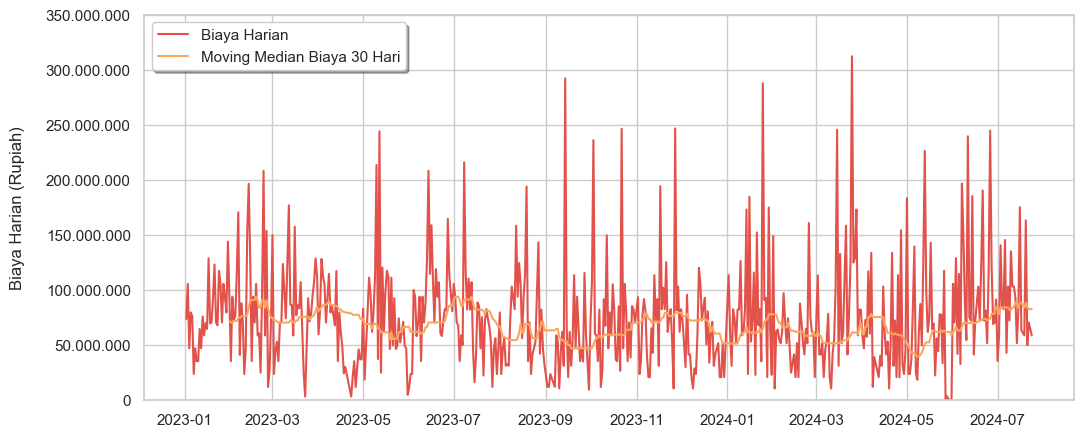

In [64]:
eda3.set_index('date')[['cost','mm_30']].plot(figsize=(12, 5))
plt.legend(['Biaya Harian','Moving Median Biaya 30 Hari'], shadow=True)
label, location = plt.yticks()
plt.yticks(label, [rupiah(i).split(',')[0].split()[-1] for i in label])
plt.ylim(ymin=0)
plt.xlabel('')
plt.ylabel('Biaya Harian (Rupiah)', fontsize=12, labelpad=15)
# plt.savefig('./Images/7. trend cost tyre harian.svg', dpi=1000000000)

In [65]:
eda3['month_years'] = pd.to_datetime(eda3.date).dt.strftime('%m/%y')
eda3['months'] = pd.to_datetime(eda3.date).dt.month
eda3['years'] = pd.to_datetime(eda3.date).dt.year
eda3 = eda3.groupby(['years','months','month_years'])[['qty','cost']].sum().reset_index()

(0.0, 3000000000.0)

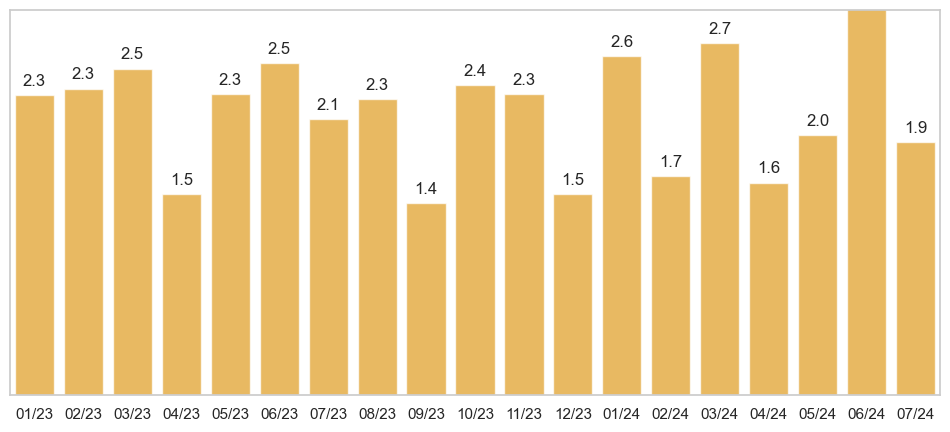

In [66]:
# Membuat plot
plt.figure(figsize=(12, 5))
splot = sns.barplot(data=eda3, x='month_years', y='cost', color='orange', alpha=0.7)

# Menambahkan teks di atas setiap bar
for p in splot.patches:
    splot.annotate(rupiah(p.get_height()).split(',')[0].split()[-1][:3], 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points')
plt.ylabel('')
plt.xlabel('')
plt.yticks([])
plt.ylim(ymax=3000000000)
# plt.savefig('./Images/7. trend cost tyre bulanan new.svg', dpi=1000000000)

(0.0, 500.0)

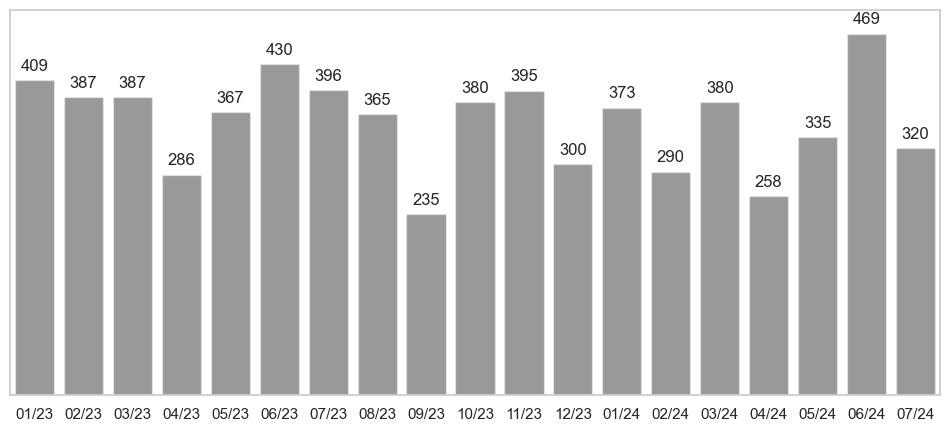

In [67]:
# Membuat plot
plt.figure(figsize=(12, 5))
splot = sns.barplot(data=eda3, x='month_years', y='qty',color='black', alpha=0.4)

# Menambahkan teks di atas setiap bar
for p in splot.patches:
    splot.annotate(rupiah(p.get_height()).split(',')[0].split()[-1][:3], 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points')
plt.ylabel('')
plt.xlabel('')
plt.yticks([])
plt.ylim(ymax=500)
# plt.savefig('./Images/7. trend cost tyre bulanan new.svg', dpi=1000000000)

In [68]:
prod = t2_1[['date','produksi']]
prod['month_years'] = pd.to_datetime(prod.date).dt.strftime('%m/%y')
prod['months'] = pd.to_datetime(prod.date).dt.month
prod['years'] = pd.to_datetime(prod.date).dt.year

In [69]:
prod = prod.groupby(['years','months','month_years'])[['produksi']].sum().reset_index()[6:-1][['month_years','produksi']]
eda3 = eda3[['month_years','qty','cost']]

In [70]:
eda3 = eda3.merge(prod, on = 'month_years')

(1000000000.0, 3500000000.0)

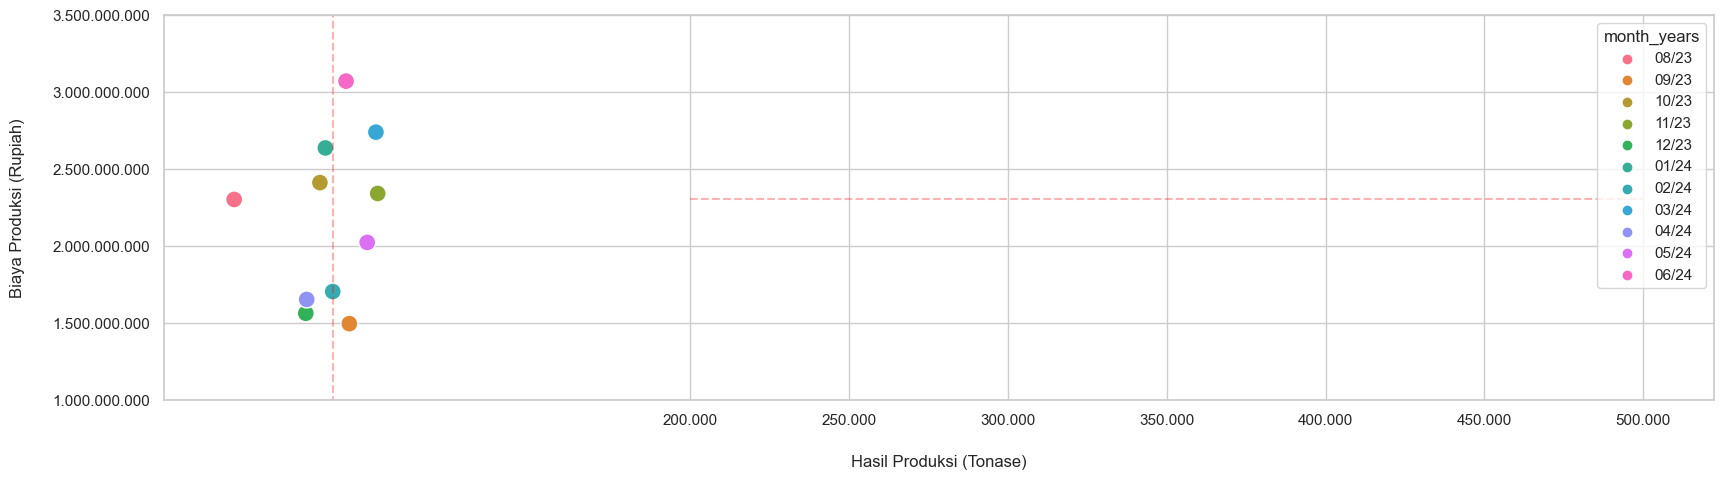

In [71]:
corr = eda3[['produksi','cost']].corr()

plt.figure(figsize=(20, 5))
sns.scatterplot(eda3, x='produksi', y='cost', s=150, hue='month_years')
plt.vlines(eda3.produksi.median(), ymin=900000000, ymax=3500000000, linestyle='dashed', color='red', alpha=0.3)
plt.hlines(eda3.cost.median(), xmin=200000, xmax=500000, linestyle='dashed', color='red', alpha=0.3)

plt.xlabel('Hasil Produksi (Tonase)', fontsize=12, labelpad=20)
plt.ylabel('Biaya Produksi (Rupiah)', fontsize=12, labelpad=20)

label, location = plt.yticks()
plt.yticks(label, [rupiah(i).split(',')[0].split()[-1] for i in label])
plt.xticks(np.arange(200000, 520000, 50000), [rupiah(float(i)).split(',')[0].split()[-1] for i in np.arange(200000, 520000, 50000)])

plt.ylim(ymin=1000000000, ymax=3500000000)
# plt.savefig('./Images/8. Korelasi biaya produksi terhadap hasil produksi.svg', dpi=100000000)

In [72]:
t3 = df2.copy()
t3 = t3[t3.production=='Hauling Ore']
target = ['HINO ZS','HINO ZY','HONGYAN KINKAN430']
equipment = df[df.equipment_name.isin(target)==True][['category_equipment','equipment_name','equipment_code']].drop_duplicates()
equipment['equipment_detail'] = equipment.equipment_code.apply(lambda x: str(x).split('/')[0])
t3 = t3.merge(equipment, left_on='equipment', right_on='equipment_code', how='left')
t3 = t3[t3.equipment_name.isin(target)]
t3['produksi'] = t3['component_line/in_weight'] - t3['component_line/out_weight']

t3 = t3[['project/name','project','name','date','move_type','hm_engine_actual','production','employee','category_equipment','equipment_name','equipment_code','equipment_detail','component_line/in_weight','component_line/out_weight','produksi','state']]
t3.columns = [i.split('/')[-1] for i in t3.columns]

# group data produksi harian 
t3 = t3.groupby(['date','project','move_type','equipment_name','equipment_detail'])[['in_weight','out_weight','produksi']].sum().reset_index()
t3['date'] = t3['date'].dt.date
t3['date'] = t3['date'].astype(str)

# klasifikasi status dari tujuan produksi berdasarkan moving type
def get_produksi_status(x):
    x = str(x)
    con = x.split('- ')[-1]
    if con == 'KM 7':
        msg = 'Deposit'
    else:
        msg = 'Sell'
    return msg

t3['produksi_status'] = t3['move_type'].apply(lambda x: get_produksi_status(x))

# group data biaya harian
cost_t1 = t1.copy()
cost_t1 = cost_t1[cost_t1.category_maintenance=='TYRE']

cost_t1['description_3'] = cost_t1.description.apply(lambda x: ' '.join(str(x).split('] ')[-1].split()[:2]))
cost_t1 = cost_t1[cost_t1.description_3=='BAN LUAR']

cost_t1 = cost_t1[['broken','equipment_name','name','qty','cost']]
cost_t1['broken'] = cost_t1['broken'].dt.date
cost_t1 = cost_t1.groupby(['broken','equipment_name','name'])[['qty','cost']].sum().reset_index()

cost_t1.columns = ['date','equipment_name','equipment_detail','qty','cost']
cost_t1['date'] = cost_t1['date'].astype(str)

cost_t1 = cost_t1[cost_t1.equipment_name.isin(t3.equipment_name.unique().tolist())]

# merge kedua data
t3['id'] = t3.date +'#'+ t3.equipment_name +'#'+ t3.equipment_detail
cost_t1['id'] = cost_t1.date +'#'+ cost_t1.equipment_name +'#'+ cost_t1.equipment_detail
t3 = t3.merge(cost_t1[['id','qty','cost']], on='id', how='outer')
t3 = t3[['id','project','move_type','produksi_status','in_weight','out_weight','produksi','qty','cost']]
t3['date'] = t3['id'].apply(lambda x: str(x).split('#')[0])
t3['equipment_name'] = t3['id'].apply(lambda x: str(x).split('#')[1])
t3['equipment_detail'] = t3['id'].apply(lambda x: str(x).split('#')[-1])
t3.drop(columns='id', inplace=True)

t3 = t3[['date','project','move_type','produksi_status','equipment_name','equipment_detail','in_weight','out_weight','produksi','qty','cost']]

# cleaning data
t3['cost'].fillna(0, inplace=True)
t3['qty'].fillna(0, inplace=True)
t3['in_weight'].fillna(0, inplace=True)
t3['out_weight'].fillna(0, inplace=True)
t3['produksi'].fillna(0, inplace=True)
t3['project'].fillna('Breakdown', inplace=True)
t3['move_type'].fillna('Breakdown', inplace=True)
t3['produksi_status'].fillna('Breakdown', inplace=True)

t3_bd = t3[t3.project=='Breakdown']
t3_bd = t3_bd[t3_bd.cost!=0]
t3_ac = t3[t3.project!='Breakdown']
t3 = pd.concat([t3_bd, t3_ac])
t3 = t3.sort_values('date', ascending=False).reset_index(drop=True)
t3['produksi'] = t3['produksi']/1000

t6 = t3.copy()
t6['month_years'] = pd.to_datetime(t6.date).dt.strftime('%m/%y')
t6['monhts'] = pd.to_datetime(t6.date).dt.month
t6['years'] = pd.to_datetime(t6.date).dt.year

In [73]:
eda3 = t6[t6.month_years.isin(['02/24','03/24'])]
eda3['move_type'].replace(False,'Breakdown', inplace=True)

moving_types = eda3[eda3.move_type!='Breakdown'][['move_type','equipment_detail']].drop_duplicates()
breakdown_move_types = eda3[eda3.move_type=='Breakdown']

def get_move_types(x):
    n = moving_types[moving_types.equipment_detail==x].reset_index(drop=True)
    if len(n) != 0:
        msg = n['move_type'][0]
    else:
        msg = 'Breakdown'
    return msg

breakdown_move_types['move_type'] = breakdown_move_types['equipment_detail'].apply(lambda x: get_move_types(x))
eda3 = pd.concat([eda3[eda3.move_type!='Breakdown'], breakdown_move_types])

In [74]:
eda31 = eda3.groupby(['month_years','move_type'])[['produksi']].sum().reset_index()
eda31 = eda31[eda31.move_type!='Breakdown']
eda32 = eda3.groupby(['month_years','move_type'])[['cost']].sum().reset_index()

(0.0, 160000.0)

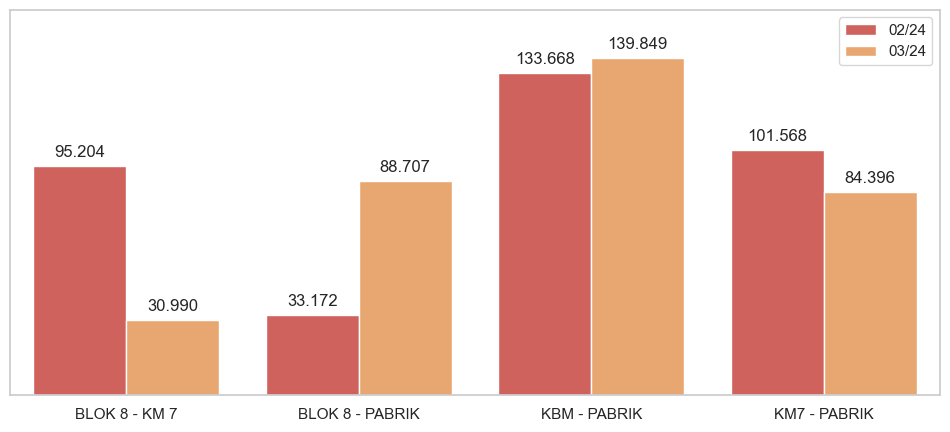

In [75]:
plt.figure(figsize=(12, 5))
splot = sns.barplot(eda31, x='move_type', y='produksi', hue='month_years')

# Menambahkan teks di atas setiap bar
for p in splot.patches:
    splot.annotate(rupiah(p.get_height()).split(',')[0].split()[-1], 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points')
plt.xlabel('')
plt.ylabel('')
plt.yticks([])
plt.legend()

plt.ylim(ymin=0, ymax=160000)
# plt.savefig('./Images/8. Hasil produksi.svg', dpi=10000000)

(0.0, 1100000000.0)

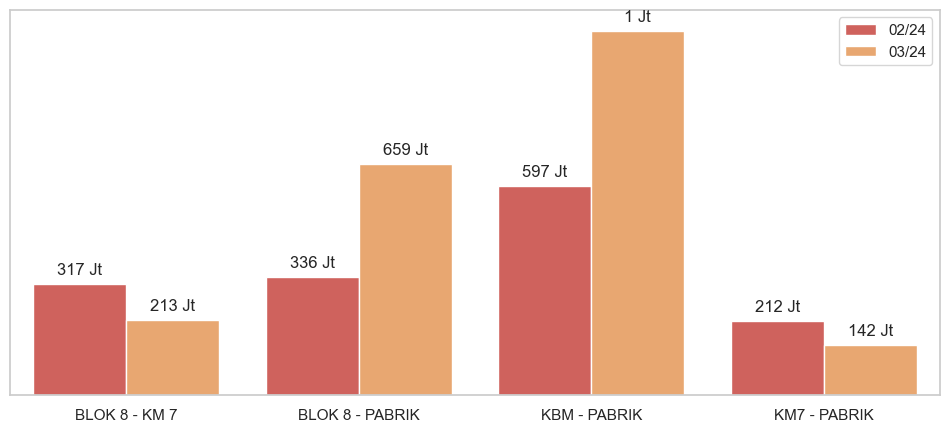

In [76]:
plt.figure(figsize=(12, 5))
splot = sns.barplot(eda32, x='move_type', y='cost', hue='month_years')

# Menambahkan teks di atas setiap bar
for p in splot.patches:
    splot.annotate(rupiah(p.get_height()).split('.')[0].split()[-1] + ' Jt', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points')
plt.xlabel('')
plt.ylabel('')
plt.yticks([])
plt.legend()
plt.ylim(ymin=0, ymax=1100000000)

# plt.savefig('./Images/8. biaya produksi.svg', dpi=10000000)

In [77]:
eda31 = eda3.groupby(['move_type','month_years','equipment_name'])[['qty','cost','produksi']].sum()

In [78]:
_ =[]
for o in eda3.month_years.unique():
    n = eda3[eda3.month_years==o]
    for i in n.move_type.unique():
        m = n[n.move_type==i]
        m = m[['equipment_name','equipment_detail']].drop_duplicates()
        m = m.groupby(['equipment_name'])[['equipment_detail']].count().reset_index()
        m['month_years'] = o
        m['move_type'] = i
        m = m[['move_type','month_years','equipment_name','equipment_detail']]
        m.columns = ['move_type','month_years','equipment_name','count_unit']
        _.append(m)

eda32 = pd.concat(_).set_index(['move_type','month_years','equipment_name'])

In [79]:
eda33 = pd.concat([eda31, eda32], axis=1)
eda33['cost_per_unit'] = eda33.cost / eda33.count_unit
eda33 = eda33.rename(columns={'qty':'tyre_qty_used'})
eda33.reset_index(inplace=True)
eda33 = eda33.merge(tbl_kapasitas[['equipment_name','rerata_muatan']], on='equipment_name', how='left')
eda33['retase'] = eda33.produksi / eda33.rerata_muatan
eda33 = eda33.merge(tbl_jarak, on='move_type', how='left')
eda33 = eda33[['move_type','month_years','equipment_name','rerata_muatan','count_unit','tyre_qty_used','cost','produksi','retase','jarak']]
eda33 = eda33.set_index(['move_type','month_years','equipment_name'])

In [80]:
# eda3 = t6[t6.month_years.isin(['02/24','03/24'])]
eda3 = t6.copy()
eda3['move_type'].replace(False,'Breakdown', inplace=True)

moving_types = eda3[eda3.move_type!='Breakdown'][['move_type','equipment_detail']].drop_duplicates()
breakdown_move_types = eda3[eda3.move_type=='Breakdown']

def get_move_types(x):
    n = moving_types[moving_types.equipment_detail==x].reset_index(drop=True)
    if len(n) != 0:
        msg = n['move_type'][0]
    else:
        msg = 'Breakdown'
    return msg

breakdown_move_types['move_type'] = breakdown_move_types['equipment_detail'].apply(lambda x: get_move_types(x))
eda3 = pd.concat([eda3[eda3.move_type!='Breakdown'], breakdown_move_types])
eda31 = eda3.groupby(['move_type','month_years'])[['qty','cost','produksi']].sum()

In [81]:
_ = []
for i in eda3.month_years.unique():
    n = eda3[eda3.month_years == i]
    for j in n[n.move_type!='Breakdown'].move_type.unique():
        m = n[n.move_type==j]
        
        count_unit = len(m[['equipment_name','equipment_detail']].drop_duplicates())
        msg = pd.DataFrame({
            'month_years':[i],
            'move_type':[j],
            'count_unit':[count_unit]
        })
        _.append(msg)

eda32 = pd.concat(_)
eda32.set_index(['move_type','month_years'], inplace=True)

In [82]:
eda33 = pd.concat([eda31, eda32], axis=1)
eda33['cost_per_unit'] = eda33.cost / eda33.count_unit
eda33 = eda33.rename(columns={'qty':'tyre_qty_used'})
eda33.reset_index(inplace=True)
eda33 = eda33[['move_type','month_years','count_unit','tyre_qty_used','cost','produksi']]
eda33 = eda33.set_index(['move_type','month_years'])
eda33 = eda33.reset_index()

In [83]:
def get_status(x):
    if x == '02/24':
        msg = 'efisien'
    else:
        msg = 'not efisien'
    return msg

In [84]:
eda33['status'] = eda33.month_years.apply(get_status)

In [85]:
def get_category(unit_x, unit_y, rmp_x, rmp_y):
    if unit_x > unit_y and rmp_x < rmp_y:
        msg = 'RMP dipengaruhi Count Unit'
    elif unit_x > unit_y and rmp_x > rmp_y:
        msg = 'RMP tdk dipengaruhi Count Unit'
    elif unit_x < unit_y and rmp_x > rmp_y:
        msg = 'RMP dipengaruhi Count Unit'
    elif unit_x < unit_y and rmp_x < rmp_y:
        msg = 'RMP tdk dipengaruhi Count Unit'
    return msg

In [86]:
_ = []
for i in eda33[eda33.status=='not efisien']['month_years'].unique():
    try:
        # get the data
        ef = eda33[(eda33.status=='efisien') & (eda33.move_type!='KM7 - PABRIK')]
        n_ef = eda33[(eda33.month_years==i) & (eda33.move_type!='KM7 - PABRIK')]
        n_ef = n_ef[n_ef.produksi!=0]
    
        # rmp = Ratio Maintenance per Produksi
        ef['rmp'] = np.round(ef['cost'] / ef['produksi'])
        n_ef['rmp'] = np.round(n_ef['cost'] / n_ef['produksi'])
    
        msg = ef.merge(n_ef, on='move_type')[['move_type','month_years_x','month_years_y','count_unit_x','count_unit_y','rmp_x','rmp_y']]
        msg['category'] = msg.apply(lambda x: get_category(x.count_unit_x, x.count_unit_y, x.rmp_x, x.rmp_y), axis=1)
        _.append(msg)
    except:
        None

eda34 = pd.concat(_)
eda34.columns=['move_type','month_ef','month_n_ef','count_unit_ef','count_unit_n_ef','rmp_ef','rmp_n_ef','category']
eda34.set_index(['month_ef','month_n_ef','move_type'], inplace=True)

def persentase_selisih(x, y):
    atas = abs(x - y)
    bawah = np.max([x, y])
    msg = atas / bawah
    return msg

eda34['p_selisih_jml_unit'] = eda34.apply(lambda x: persentase_selisih(x.count_unit_ef, x.count_unit_n_ef), axis=1)
eda34['p_selisih_rmp'] = eda34.apply(lambda x: persentase_selisih(x.rmp_ef, x.rmp_n_ef), axis=1)
eda34 = eda34[['count_unit_ef','count_unit_n_ef','p_selisih_jml_unit','rmp_ef','rmp_n_ef','p_selisih_rmp','category']]

In [87]:
# tunjukan persentase RMP dipengaruhi oleh jumlah unit bekerja
(eda34.category.value_counts() / eda34.category.value_counts().sum()) * 100

RMP dipengaruhi Count Unit        82.926829
RMP tdk dipengaruhi Count Unit    17.073171
Name: category, dtype: float64

In [88]:
# temukan fakta menarik
eda34[eda34.category=='RMP dipengaruhi Count Unit'][['p_selisih_jml_unit','p_selisih_rmp']].mean()

p_selisih_jml_unit    0.239223
p_selisih_rmp         0.346780
dtype: float64

Dengan meningkatkan **Count Unit** sebesar **33.45%** dapat menunrunkan **MPTR** sebesar **48.64%**

In [89]:
eda34 = eda34.reset_index()

In [90]:
_ = []
for i in eda34.move_type.unique():
    n = eda34[eda34.move_type==i]
    rmp_best = n[(n.rmp_ef==np.min(n.rmp_ef.tolist() + n.rmp_n_ef.tolist())) | (n.rmp_n_ef==np.min(n.rmp_ef.tolist() + n.rmp_n_ef.tolist()))]
    move_type = i
    
    con1 = np.min(n.rmp_ef.tolist() + n.rmp_n_ef.tolist()) in n.rmp_ef.tolist()

    if con1 == True:
        month = n.month_ef.unique().tolist()[0]
        rmp_best = rmp_best['rmp_ef'].unique().tolist()[0]
    else:
        month = n.month_n_ef.unique().tolist()[0]
        rmp_best = rmp_best['rmp_n_ef'].unique().tolist()[0]

    msg = pd.DataFrame({
        'move_type':[move_type],
        'month_years':[month],
        'mptr_best':[rupiah(rmp_best)]
    })

    _.append(msg)

msg = pd.concat(_)

In [91]:
# coba kita misalkan menerapkan formula ini 
def cost_efisien(cost, produksi, count_unit):
    if produksi != 0:
        mptr_old = cost / produksi
        mptr_new = mptr_old - (mptr_old * 0.486496)
        
        cost_new = mptr_new * produksi
        count_unit_new = count_unit + (count_unit * 0.334544)
        try:
            msg = [np.round(count_unit_new), np.round(cost_new)]
        except:
            msg = cost_new
    else:
        count_unit_new = np.round(count_unit + (count_unit * 0.334544))
        msg = [count_unit_new, 0]
    return msg

In [92]:
eda33['count_unit_new'] = eda33.apply(lambda x: cost_efisien(x.cost, x.produksi, x.count_unit)[0], axis=1)
eda33['cost_new'] = eda33.apply(lambda x: cost_efisien(x.cost, x.produksi, x.count_unit)[1], axis=1)

## Task 7 : DASHBOARD
- Dashboard Monitoring Prodical Maintenance Equipment
- Rerata Equipment harus masuk dalam periodical Maintenance

In [93]:
# kumpul data historical dari setiap alat
bd7 = df[['spk','broken','category_equipment','equipment_name','equipment_code','hm']]
ts7 = df2[['name','date','equipment','hm_engine_start','hm_engine_end','actual_engine']]

# transform data
bd7['name'] = bd7['equipment_code'].apply(lambda x: str(x).split('/')[0])
bd7 = bd7.rename(columns={'spk':'spk','broken':'date','hm':'hm_engine_end'})
bd7 = bd7.drop(columns=['equipment_code'])
bd7['status'] = 'b/d'
bd7 = bd7[['status','spk','date','category_equipment','equipment_name','name','hm_engine_end']]

ts7 = ts7.rename(columns={'name':'spk','equipment':'name'})
ts7['name'] = ts7['name'].apply(lambda x: str(x).split('/')[0])

# merge data
ts7 = ts7.merge(bd7[['category_equipment','equipment_name','name']].drop_duplicates(), on='name', how='left')
ts7['status'] = 'timesheet'
ts7 = ts7[['status','spk','date','category_equipment','equipment_name','name','hm_engine_end']]

# concat all data time sheet and data breadown
t7 = pd.concat([ts7,bd7])
t7['date'] = pd.to_datetime(t7.date).dt.date
# t7 = t7[pd.to_datetime(t7.date).dt.year>2023]

# kita asumsikan data tidak terdapat human error
t7 = t7[t7.hm_engine_end!=0]

t7 = t7.sort_values(['name','date','hm_engine_end'], ascending=True)
t7 = t7.drop_duplicates(subset=['date','category_equipment','equipment_name','name','hm_engine_end'])

In [94]:
# sample data untuk uji program

list_unit_hino_zy = t7[t7.equipment_name=='HINO ZY'].name.unique().tolist()
sample = t7[t7.name==list_unit_hino_zy[20]]

# cleaning data
sample['pct_change'] = sample.hm_engine_end.pct_change()
sample = sample[sample['pct_change']>0]
sample = sample[sample['pct_change']<sample['pct_change'].median()]
sample = sample[pd.to_datetime(sample.date).dt.year>=2024]
sample.drop(columns='pct_change', inplace=True)

def get_increase_hm(list_hm):
    msg = []
    for i in range(len(list_hm)):
        try:
            value = list_hm[i + 1] - list_hm[i]
            msg.append(value)
        except:
            msg.append(None)
    msg = [0] + msg[:-1]   
    return msg

# apply function
sample['increase_hm'] = get_increase_hm(sample.hm_engine_end.tolist())

In [95]:
def cek_periode_ganti(hm_engine_end, eq_name):
    base = tbl_periodical[tbl_periodical.equipment_name==eq_name].reset_index(drop=True)
    base['params'] = [0 for i in range(len(base))]
    
    increase_hm = get_increase_hm(hm_engine_end)
    msg = []
    for i in increase_hm:
        # buat perulangan untuk menambahkan params
        for k in range(len(base)):
            base['params'][k] = base['params'][k] + i
            
        base['con'] = base.params >= base.standar_hm
        if True in base['con'].tolist():
            n = base[base.con == True]
            index_list = n.index.tolist()
            for j in index_list:
                base['params'][j] = 0
            msg.append(','.join(n.description.tolist()))
        else:
            msg.append(np.NaN)

    return msg

In [96]:
t7_ = []
for i in tqdm(t7.name.unique().tolist()):
    n = t7[t7.name==i]
    # n = n[pd.to_datetime(n.date).dt.year>=2024]
    
    hm_list = n['hm_engine_end'].tolist()
    eq_name = n['equipment_name'].unique().tolist()[0]
    
    n['periodical_maintenance'] = cek_periode_ganti(hm_list, eq_name)
    t7_.append(n)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [00:18<00:00, 19.51it/s]


In [97]:
t7 = pd.concat(t7_)

In [98]:
check = t7[t7.name=='D65-10'].periodical_maintenance.value_counts().reset_index().to_dict()

In [99]:
# Ubah kolom 'index' menjadi unik
unique_index = []
for index_list in check['index'].values():
    unique_index.extend(index_list.split(','))

unique_index = sorted(set(unique_index))

# Buat DataFrame baru dengan indeks unik
new_data = {
    'index': [', '.join(unique_index)] * len(check['index']),
    'periodical_maintenance': check['periodical_maintenance'].values()
}

In [100]:
check = t1[pd.to_datetime(t1.done).dt.strftime('%m/%y').isin(['02/23'])]

In [101]:
check[check.requirement_type=='External'].to_excel('check_external.xlsx', index=False)

## Task 8 : ANALISA

## Task 9 : ANALISA

## Task 10 : DASHBOARD

In [102]:
company = kpi[['date','company','name']].drop_duplicates()
company['id'] = company.apply(lambda x: get_id(x['date'], x['name']), axis=1)

t10 = t3.copy()
t10['id'] = t10.apply(lambda x: get_id(x['date'], x['equipment_detail']), axis=1)
t10 = t10.merge(company[['company','id']], on='id', how='left')

# KONTRAK KBM : MINING KBM
# KONTRAK BLOK 8 : MINIM BDM
# RENTAL BLOK 8 : [RENTAL BDM] [BLOK 5 - PABRIK]
# RENTAL FEEDING KM 7 : [RENTAL BDM] [KM7 - PABRIK]

# def get_kontrak(project, move):
#     if project == 'Mining KBM':
#         msg = 'Kontrak KBM'
        
#     elif project == 'Mining BDM':
#         msg = 'Kontrak Blok 8'
        
#     elif project == 'Rental BDM':
#         if move == 'BLOK 5 - PABRIK':
#             msg = 'Rental Blok 8'
            
#         elif move == 'KM7 - PABRIK':
#             msg = 'Feeding KM7'
            
#         else:
#             msg = 'Tidak Diketahui'

#     else:
#         msg = 'Tidak Diketahui'
#     return msg

# # APPLY FUNCTION
# t10['kontrak'] = t10.apply(lambda x: get_kontrak(x.project, x.move_type), axis=1)
t10 = t10.rename(columns={'project':'kontrak'})
t10 = t10[t10.kontrak!='Tidak Diketahui']
t10 = t10[['date','company','kontrak','move_type','equipment_name','equipment_detail','in_weight','out_weight','produksi','cost']]

# mengisi tanggal kosong pada masing-masing kontrak
_ = []
for i in tqdm(t10.kontrak.unique().tolist()):
    n = t10[t10.kontrak == i]

    move = n.move_type.unique().tolist()[0]

    n = date.merge(n, on='date', how='left')
    n['company'].fillna('Tidak Diketahui', inplace=True)
    n['kontrak'].fillna(i, inplace=True)
    n['move_type'].fillna(move, inplace=True)
    n['equipment_name'].fillna('Tidak Diketahui', inplace=True)
    n['equipment_detail'].fillna('Tidak Diketahui', inplace=True)
    n['in_weight'].fillna(0, inplace=True)
    n['out_weight'].fillna(0, inplace=True)
    n['produksi'].fillna(0, inplace=True)
    n['cost'].fillna(0, inplace=True)
    _.append(n)

t10 = pd.concat(_)
t10 = t10.merge(tbl_kapasitas[['equipment_name','kapasitas_maximal']], on='equipment_name', how='left')

retase = kpi[kpi['spk_project']!='-']
retase = retase[['date','name','retase']]
retase['id'] = retase.date + '#' + retase.name

t10['id'] = t10.date + '#' + t10.equipment_detail
t10 = t10.merge(retase[['id','retase']], on='id', how='left').fillna(0).drop(columns='id')

t10['kapasitas_maximal'].fillna(0, inplace=True)
t10.to_excel('./Report/dashboard_request_pak_jon_1.xlsx', index=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 180.90it/s]


## Task 11 : ANALISA

Analisa pemakaian bahan bakar

In [103]:
# date['month'] = pd.to_datetime(date.date).dt.strftime('%m/%y')

In [104]:
# # read and cleaning data
# t11 = pd.read_excel('/Users/dickyaryanto/Documents/PT Sentosa Abadi Mining/Data/data pemakaian fuel.xlsx')
# t11['name'] = t11['name'].apply(lambda x: ''.join(x.split()))
# t11['date'] = pd.to_datetime(t11.date).dt.strftime('%m/%y')
# t11.replace('-', 0, inplace=True)
# t11['hm'] = t11['hm'].astype(float)
# t11['produksi'] = t11['produksi'].astype(float)
# t11['retase'] = t11['retase'].astype(float)
# t11['konsumsi'] = t11['konsumsi'].astype(float)
# t11 = t11.merge(tbl_kapasitas[['equipment_name','kapasitas_maximal']], on='equipment_name', how='left').fillna(0).rename(columns={'kapasitas_maximal':'kap_max'})


# def get_hm(hm, produksi, kap_max, retase, month):
#     count_day = len(date[date.month==month])
#     actual_produksi = count_day * 4 * kap_max
#     try:
#         if hm != 0:
#             msg = hm
#         else:
#             f1 = (produksi / actual_produksi) * 10 * count_day
#             f2 = (retase / (count_day * 4)) * 10 * count_day
#             msg = (f1 + f2)/2
#     except:
#         msg = 0

#     return msg

# # apply function
# t11['hm'] = t11.apply(lambda x: get_hm(x.hm, x.produksi, x.kap_max, x.retase, x['date']), axis=1)

# # sns.pairplot(t11[t11.production=='Hauling Ore'][['hm','produksi','retase','konsumsi']])
# # plt.tight_layout()
# # plt.show()

In [105]:
# sns.pairplot(t11[t11.production!='Hauling Ore'][['hm','konsumsi']])
# plt.tight_layout()
# plt.show()

In [106]:
# t11[t11.production=='Hauling Ore'].drop(columns='kap_max').corr()

In [107]:
# t11[t11.production!='Hauling Ore'].drop(columns='kap_max')[['hm','konsumsi']].corr()

In [108]:
# ho = t11[t11.production=='Hauling Ore']
# nho = t11[t11.production!='Hauling Ore'].drop(columns=['retase','produksi','kap_max'])

In [109]:
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# scale = MinMaxScaler()
# le = LabelEncoder()

# xho = ho.copy()
# xnho = nho.copy()

# # transformasi tipe data kategorikal
# for i in xho.select_dtypes('object').columns.tolist():
#     xho[i] = le.fit_transform(xho[i])

# for i in xnho.select_dtypes('object').columns.tolist():
#     xnho[i] = le.fit_transform(xnho[i])

# # transformasi tipe data numerik
# for i in xho.select_dtypes('number').columns.tolist():
#     xho[i] = scale.fit_transform(xho[[i]])

# for i in xnho.select_dtypes('number').columns.tolist():
#     xnho[i] = scale.fit_transform(xnho[[i]])

In [110]:
# # buat evaluasi score inertia untuk XHO
# score_xho = []
# for i in range(2, 10):
#     kmeans = KMeans(n_clusters=i)
#     model = kmeans.fit(xho)
#     score_xho.append(model.inertia_)

# plt.title('Score Inertia Data Production Hauling Ore', fontsize=12, pad=15)
# plt.plot(range(2, 10), score_xho, marker='o')
# plt.tight_layout()
# plt.show()

# # print
# print('Data production Hauling Ore beter using 4 clusters')

# # define function using 4 clusters
# kmeans = KMeans(n_clusters=2)
# xho['c1'] = kmeans.fit_predict(xho)

In [111]:
# # buat evaluasi score inertia untuk XNHO
# score_xnho = []
# for i in range(2, 10):
#     kmeans = KMeans(n_clusters=i)
#     model = kmeans.fit(xnho)
#     score_xnho.append(model.inertia_)

# plt.title('Score Inertia Data Production != Hauling Ore', fontsize=12, pad=15)
# plt.plot(range(2, 10), score_xnho, marker='o')
# plt.tight_layout()
# plt.show()

# # print
# print('Data production != Hauling Ore beter using 3 clusters')

# # define function using 3 clusters
# kmeans = KMeans(n_clusters=2)
# xnho['c1'] = kmeans.fit_predict(xnho)

In [112]:
# # gabung data
# ho = pd.concat([ho, xho[['c1']]], axis=1)
# nho = pd.concat([nho, xnho[['c1']]], axis=1)

In [113]:
# sns.pairplot(ho[['hm','produksi','retase','konsumsi','c1']], hue='c1')

In [114]:
# corr_app = ho[ho.company=='CV. Adil Prima Perkasa'][['hm','retase','produksi','konsumsi']].corr()
# plt.figure(figsize=(8, 5))
# plt.title('Persentase Keterhubungan Antar Parameter', fontsize=19, pad=15)
# sns.heatmap(corr_app, linewidth=2, annot=True)

# plt.yticks(rotation=0)

# plt.tight_layout()
# # plt.savefig('./Images/Korelasi antar parameter app.svg', dpi=1000)

In [115]:
# corr_sa = ho[['hm','retase','produksi','konsumsi']].corr()
# plt.figure(figsize=(8, 5))
# plt.title('Persentase Keterhubungan Antar Parameter', fontsize=19, pad=15)
# sns.heatmap(corr_sa, linewidth=2, annot=True)

# plt.yticks(rotation=0)

# plt.tight_layout()
# # plt.savefig('./Images/Korelasi antar parameter.svg', dpi=1000)

In [116]:
# corr_sa = ho[ho.company=='CV. SENTOSA ABADI'][['hm','retase','produksi','konsumsi']].corr()
# plt.figure(figsize=(8, 5))
# plt.title('Persentase Keterhubungan Antar Parameter', fontsize=19, pad=15)
# sns.heatmap(corr_sa, linewidth=2, annot=True)

# plt.yticks(rotation=0)

# plt.tight_layout()
# # plt.savefig('./Images/Korelasi antar parameter sa.svg', dpi=1000)

In [117]:
# sns.pairplot(ho[['hm','produksi','retase','konsumsi','c1']], hue='c1')
# # plt.savefig('./Images/pair plot.svg', dpi=1000)

In [118]:
# ho['number'] = 1
# nho['number'] = 1

In [119]:
# eda1 = ho.groupby(['date','company'])[['produksi','konsumsi']].sum().reset_index()

In [120]:
# plt.figure(figsize=(9, 5))
# splot = sns.barplot(eda1.sort_values('company', ascending=False), x='date', y='produksi', hue='company')

# # Add annotations using splot
# for p in splot.patches:
#     try:
#         splot.annotate(rupiah(p.get_height()).split()[-1].split(',')[0], 
#                        (p.get_x() + p.get_width() / 2., p.get_height()), 
#                        ha = 'center', va = 'center', 
#                        xytext = (0, 10), 
#                        textcoords = 'offset points',
#                        fontsize=12)
#     except:
#         splot.annotate(p.get_height(), 
#                (p.get_x() + p.get_width() / 2., p.get_height()), 
#                ha = 'center', va = 'center', 
#                xytext = (0, 10), 
#                textcoords = 'offset points',
#                fontsize=12)
# plt.xlabel('')
# plt.yticks([])
# plt.ylabel('')
# plt.ylim(ymin=0, ymax=160000)
# plt.legend('')
# plt.tight_layout()
# plt.savefig('./Images/perbandingan produksi sa dan app.svg', dpi=1000)

In [121]:
# plt.figure(figsize=(9, 5))
# splot = sns.barplot(eda1.sort_values('company', ascending=False), x='date', y='konsumsi', hue='company')

# # Add annotations using splot
# for p in splot.patches:
#     try:
#         splot.annotate(rupiah(p.get_height()).split()[-1].split(',')[0], 
#                        (p.get_x() + p.get_width() / 2., p.get_height()), 
#                        ha = 'center', va = 'center', 
#                        xytext = (0, 10), 
#                        textcoords = 'offset points',
#                        fontsize=12)
#     except:
#         splot.annotate(p.get_height(), 
#                (p.get_x() + p.get_width() / 2., p.get_height()), 
#                ha = 'center', va = 'center', 
#                xytext = (0, 10), 
#                textcoords = 'offset points',
#                fontsize=12)

# plt.xlabel('')
# plt.yticks([])
# plt.ylabel('')
# plt.ylim(ymin=0, ymax=150000)
# plt.legend('')
# plt.tight_layout()
# plt.savefig('./Images/perbandingan konsumsi sa dan app.svg', dpi=1000)

In [122]:
# def pct(data):
#     _ = []
#     for i in range(len(data) - 1):
#         values = [data[i], data[i+1]]
#         msg = np.round(((np.max(values) - np.min(values)) / np.max(values))*100, 2)
#         _.append(msg)
#     return _

In [123]:
# print('1. PCT Produksi SA :',pct(eda1[eda1.company=='CV. SENTOSA ABADI'].produksi.tolist()))
# print('2. PCT Konsumsi SA :', pct(eda1[eda1.company=='CV. SENTOSA ABADI'].konsumsi.tolist()))

In [124]:
# print('1. PCT Produksi APP :',pct(eda1[eda1.company=='CV. Adil Prima Perkasa'].produksi.tolist()))
# print('2. PCT Konsumsi APP :', pct(eda1[eda1.company=='CV. Adil Prima Perkasa'].konsumsi.tolist()))

In [125]:
# eda1['konsumsi/produksi'] = eda1.konsumsi / eda1.produksi

In [126]:
# eda1.groupby(['company'])[['konsumsi/produksi']].mean()

In [127]:
# eda2 = kpi[kpi.company.isin(eda1.company.unique().tolist())]
# eda2['number'] = 1
# eda2['month'] = pd.to_datetime(eda2.date).dt.strftime('%m/%y')
# eda2['kontrak'] = eda2.apply(lambda x: get_kontrak(x['project/name'], x.move_type), axis=1)
# eda2 = eda2[eda2.month.isin(['01/24','02/24','03/24'])]
# eda2 = eda2[eda2.move_type.isin(['KBM - PABRIK','BLOK 8 - PABRIK'])]

In [128]:
# eda3 = eda2.groupby(['month','company','move_type'])[['produksi','retase','jam_produktivitas','number','total_jarak_tempuh']].sum().fillna(0).reset_index()

In [129]:
# eda4 = eda3[['month','company','total_jarak_tempuh','jam_produktivitas']]
# eda4 = eda4.drop(index=2)
# eda4['konsumsi'] = [125908, 93036, 92775, 126492, 84757]

In [130]:
# sns.barplot(eda4.sort_values('company', ascending=False), x='month', y='jam_produktivitas', hue='company')

In [131]:
# node3 = eda2.groupby(['company','month'])[['produksi']].sum().reset_index().rename(columns={'produksi':'produksi Node3'})
# node3 = node3.set_index(['month','company'])

# excel = eda1.groupby(['company','date'])[['produksi']].sum().reset_index().rename(columns={'produksi':'produksi MPE'})
# excel = excel[excel.date.isin(['02/24','03/24'])]
# excel = excel.rename(columns={'date':'month'})
# excel = excel.set_index(['month','company'])

# dif = pd.concat([node3, excel], axis=1).fillna(0)
# dif = dif.reset_index().sort_values('month', ascending=True)
# dif['Node3 - MPE'] = dif['produksi Node3'] - dif['produksi MPE']
# dif = dif.set_index(['month','company'])
# dif 

In [132]:
# lts = pd.read_excel('Learning CC bawahtanah.xlsx')
# lts = l[['PROCESS DATE',
#  'TYPE',
#  'MODEL',
#  'EQUIP NO',
#  'MATERIAL',
#  'SUMBER',
#  'TUJUAN',
#  'PROCESS',
#  'ACTIVITY',
#  'WHRS',
#  'PRODUKSI',
#  'CATEGORY',
#  'CLASS UNIT']]

## TASK 12 : DASHBOARD

buat trend biaya maintenance repair unit

In [133]:
# # read data planing hino
# plan_hino = pd.read_excel('/Users/dickyaryanto/Documents/PT Sentosa Abadi Mining/Data/estimasi plan biaya maintenance hino.xlsx')
# plan_hino['status'] = 'Plan'

# # read data detail informasi equipment
# url_depresiasi = "https://docs.google.com/spreadsheets/d/1cjcBMY29etIAeQAwRDzlbpd4wExYkpvxk7s4tgVUD-w/export?format.xlsx"

# try:
#     os.remove('detail_depresiasi.xlsx')
# except:
#     None
    
# output_filename = 'detail_depresiasi.xlsx'

# # get the data from spreadsheet
# response = requests.get(url_depresiasi)
# if response.status_code == 200:
#     with open(output_filename, "wb") as f:
#         f.write(response.content)
        
# eq_info = pd.read_excel('detail_depresiasi.xlsx')
# eq_info.columns = ['_'.join(i.lower().split()) for i in eq_info.columns]

## TASK 13 : ANALISA

Analisa kebutuhan meeting bersama **BOD** untuk evaluasi **Semester-1 2024** sebagai pertimbangan kebijakan **Planing Semester-2 2024**.

In [134]:
# data1 = pd.read_excel('./Report/task2.xlsx')
# data2 = pd.read_excel('./Report/cc dashboard 2.xlsx')

In [135]:
# # reduce parameter in data1
# data1 = data1[['date','project/name','production','move_type','category_equipment',
#                'equipment_name','name','produksi','retase','total_jarak_tempuh']]

# # buat kolom id untuk merge
# data1['id'] = data1.apply(lambda x: str(x.date) + '#' + x['name'], axis=1)
# data2['id'] = data2.apply(lambda x: str(x.date) + '#' + x['name'], axis=1)

In [136]:
# # merge data
# data = data2.drop(columns=['name','date','produksi']).merge(data1[['id','project/name','production','move_type','retase','produksi']], on='id', how='outer')
# data['date'] = data['id'].apply(lambda x: str(x).split('#')[0])
# data['name'] = data['id'].apply(lambda x: str(x).split('#')[-1])
# data.drop(columns='id', inplace=True)

# # repoisiton columns dataframe
# data = data[['date','project/name','production','move_type','category_equipment','equipment_name','hm',
#       'rm','fuel','tyre','depresiasi','insurance','interest','tax','ovh','retase','total_jarak_tempuh','produksi']]

# # data cleaning
# data['project/name'].fillna('-', inplace=True)
# data['production'].fillna('-', inplace=True)
# data['move_type'].fillna('-', inplace=True)
# data['ovh'].fillna(0, inplace=True)
# data['depresiasi'].fillna(0, inplace=True)
# data['insurance'].fillna(0, inplace=True)
# data['interest'].fillna(0, inplace=True)
# data['tax'].fillna(0, inplace=True)
# data['retase'].fillna(0, inplace=True)

# # data transforming
# data['my'] = pd.to_datetime(data.date).dt.strftime('%m/%y')
# data['month'] = pd.to_datetime(data.date).dt.month
# data['years'] = pd.to_datetime(data.date).dt.year
# data['cost_all'] = data.rm + data.fuel + data.tyre + data.depresiasi + data.insurance + data.tax + data.interest + data.ovh

In [137]:
# # buat fungsi untuk klasifikasi semester busines
# def get_semester(x):
#     if x < 7:
#         msg = 'Semester-1'
#     else:
#         msg = 'Semester-2'
#     return msg

# data['semester'] = data['month'].apply(get_semester)

### Task 13.1 : Evaluasi trend produksi/cost semester-1 2023 & 2024

In [138]:
# t13 = data[(data.semester=='Semester-1') & (data.production=='Hauling Ore')]
# t13 = t13.groupby(['semester','years','month','my'])[['rm','fuel','tyre','depresiasi','insurance',
#                                                       'interest','tax','ovh','hm','retase','total_jarak_tempuh','produksi','cost_all']].sum().reset_index()
# t13['cost/produksi'] = t13.cost_all / t13.produksi

In [139]:
# m = t13
# # m['my'] = pd.to_datetime(m.date).dt.strftime('%m/%y')
# # m['years'] = pd.to_datetime(m.date).dt.year
# m = m.groupby(['years','my'])[['fuel']].sum().reset_index()
# m[m.years == 2024]

In [140]:
# t13 = data[(data.semester=='Semester-1') & (data.production=='Hauling Ore')]
# t13 = t13[t13['project/name'].isin(['Mining KBM','Mining BDM'])].rename(columns={'project/name':'kontrak'})

In [141]:
# t13 = t13.groupby(['semester','years','month','my','kontrak'])[['rm','fuel','tyre','depresiasi','insurance','interest','tax','ovh','hm','retase','total_jarak_tempuh','produksi','cost_all']].sum().reset_index()

## TASK 14 : DASHBOARD LOGISTIC

dashboard untuk monitoring item keluar pada divisi logistik

In [142]:
t14 = df.copy()
t14 = t14[t14.picking_reference!=False]
t14['name'] = t14.equipment_code.apply(lambda x: str(x).split('/')[0])
t14 = t14.drop(columns=['equipment_code'])
t14 = t14[['company','spk','stage','picking_reference','picking_status','schedule','oprator','category_equipment','equipment_name',
           'name','requirement_type','type_maintenance','category_maintenance','description','qty','uom']].rename(columns={'schedule':'date'})
t14['description'] = t14['description'].apply(lambda x: str(x).split('] ')[-1])
t14['date'] = pd.to_datetime(t14['date']).dt.date
t14['category_maintenance'] = t14['category_maintenance'].apply(retext_category_maintenance)
t14 = t14[t14.qty!=0]

In [143]:
t14.to_excel('./Report/task14.xlsx', index=False)

## TASK 15 : ANALISA

Klasifikasi alasan kerusakan dan retase tidak tercapai

## TASK 16 : DASHBOARD CICO BOD

In [144]:
# # buat fungsi untuk klasifikasi jam keluar
# def klasifikasi_jam_keluar(x):
#     hour = x.hour
#     if hour < 7:
#         msg = 'Keluar Sebelum 07:00'
#     elif hour == 7:
#         msg = 'Keluar Tepat 07:00'
#     else:
#         msg = 'Keluar Setelah 07:00'
#     return msg

In [145]:
# # terapkan fungsi
# cico['status_keluar'] = cico.jam_keluar.apply(klasifikasi_jam_keluar)

# # buat fungsi untuk klasifikasi driver bekerja
# def klasifikasi_jam_kerja(x):
#     if x >= 10:
#         msg = 'Bekerja dalam 10 jam'
#     else:
#         msg = 'Bekerja dibawah 10 jam'
#     return msg

# # terapkan fungsi
# cico['status_jam_kerja'] = cico.total_jam_kerja.apply(klasifikasi_jam_kerja)
# cico['number'] = 1
# cico.to_excel('./Report/cico.xlsx', index=False)

## TASK 17 : ANALISA

Analisa cost repair and maintenance untuk beberapa dt

In [146]:
dt_analisa = pd.read_excel('dt analisa pak alfret.xlsx', names=['name'])
dt_analisa['name'] = dt_analisa.name.apply(lambda x: str(x).split()[1])
dt_analisa['name'] = dt_analisa['name'].apply(lambda x: '-'.join(str(x).split('-')[1:]))

In [147]:
t17 = t1[['broken','done','category_equipment','equipment_name','name','category_maintenance','description','qty','uom','cost']]
t17['date'] = pd.to_datetime(t17['done']).dt.date
t17['my'] = pd.to_datetime(t17['date']).dt.strftime('%m/%y')
t17 = t17[t17.my.isin(['01/24','02/24','03/24','04/24','05/24'])]
t17 = t17[['date','my','category_equipment','equipment_name','name','category_maintenance','description','qty','uom','cost']]

In [148]:
t17 = t17[t17.name.isin(dt_analisa.name.tolist())]

In [149]:
t17.to_excel('Analisa Cost Maintenance.xlsx', index=False)

In [150]:
t1[(t1.cost == 0) & (t1.description!='Service')][['description', 'cost']].drop_duplicates().to_excel('check cost kosong per part.xlsx', index=False)

## TASK 18 : ANALISA LAPORAN DRIVER DT

In [151]:
def try_transform_time(x):
    n = pd.DataFrame({'time':[x]})
    
    try:
        msg = pd.to_datetime(n['time']).dt.time
        msg = msg[0]
    except:
        msg = 'SPK Belum Input'

    return msg

# ambil tanggal hari kemarin
date_before = date['date'].tolist()[-2]

# filter data absen driver menggunakan tanggal kemarin
dt_rusak = absen_driver[absen_driver.date==date_before]
dt_rusak = dt_rusak[dt_rusak.keterangan!='TARGET']
dt_rusak = dt_rusak[['name','project/name','date','jam_keluar','jam_masuk','total_jam_kerja','retase','keterangan']]
dt_rusak['name'] = dt_rusak.name.apply(lambda x: 'DT-' + str(x).split('-')[-1])
dt_rusak['date'] = dt_rusak['date'].apply(lambda x: str(x).split()[0])

# filter data WS menggunakan tanggal kemarin
bd = df.copy()
bd['date'] = bd['broken'].apply(lambda x: str(x).split()[0])
bd = bd[bd['date']==date_before]
bd = bd.rename(columns={'spk':'spk_workshop'})

bd['name'] = bd.equipment_code.apply(lambda x: str(x).split('/')[0])

def get_hm_maintenance(broken, done):
    try:
        value = done - broken
    except:
        value = 0

    msg = timedelta_to_hour(value)
    if msg > 0:
        msg = msg
    else:
        msg = 0
    return msg
bd['hm_maintenance'] = bd.apply(lambda x: get_hm_maintenance(x.broken, x.done), axis=1)
bd['hm_maintenance'] = bd.apply(lambda x: 'On Progress' if x.stage != 'DONE' else x.hm_maintenance, axis=1)
bd['done'] = bd.apply(lambda x: 'On Progress' if x.stage != 'DONE' else x.done, axis=1)

# merge data
dt_rusak = dt_rusak.merge(bd[['name','stage','spk_workshop','requirement_type','broken','done','hm_maintenance']], on='name', how='inner').rename(columns={'project/name':'kontrak','total_jam_kerja':'jam_kerja'})

# dt_rusak['spk_workshop'].fillna('SPK Belum Input', inplace=True)
# dt_rusak['stage'].fillna('SPK Belum Input', inplace=True)
# dt_rusak['requirement_type'].fillna('SPK Belum Input', inplace=True)

# dt_rusak['broken'].fillna('SPK Belum Input', inplace=True)
# dt_rusak['broken'] = dt_rusak['broken'].apply(lambda x: str(x).split(';')[0])

# dt_rusak['done'].fillna('SPK Belum Input', inplace=True)
# dt_rusak['done'] = dt_rusak['done'].apply(lambda x: str(x).split(';')[-1])

dt_rusak['hm_maintenance'].fillna(0, inplace=True)

dt_rusak = dt_rusak[dt_rusak.requirement_type.apply(lambda x: 'External' in x.split(';'))!=True]

def get_time(list_time, status):
    try:
        if status == 'Broken':
            msg = pd.DataFrame({'time':list_time.split(';')})
            msg['time'] = pd.to_datetime(msg.time)
            msg = msg.sort_values('time', ascending=True)
            msg['time'] = msg['time'].apply(lambda x: str(x))
            msg = msg.head(1)['time'].unique().tolist()[0]
        else:
            msg = pd.DataFrame({'time':list_time.split(';')})
            msg['time'] = pd.to_datetime(msg.time)
            msg = msg.sort_values('time', ascending=False)
            msg['time'] = msg['time'].apply(lambda x: str(x))
            msg = msg.head(1)['time'].unique().tolist()[0]
    except:
        msg = 'SPK Belum Input'
    return msg
    
dt_rusak = dt_rusak.groupby(['date','kontrak','name','requirement_type','spk_workshop','stage','jam_masuk',
                             'jam_keluar','retase','broken','done','hm_maintenance','keterangan'])[['keterangan']].count()
    
# dt_rusak['broken'] = dt_rusak.apply(lambda x: get_time(x.broken, "Broken"), axis=1)
# dt_rusak['done'] = dt_rusak.apply(lambda x: get_time(x.done, "Done"), axis=1)
# dt_rusak['requirement_type'] = dt_rusak.requirement_type.apply(lambda x: 'Internal' if 'External' not in x.split(';') else 'Gabungan')
# dt_rusak  = dt_rusak.set_index(['date','kontrak','name','spk_workshop','requirement_type','stage'])[['jam_keluar','jam_masuk','jam_kerja','retase','broken','done','hm_maintenance','keterangan']]

# load data
dt_rusak.to_excel('./Rekap kerusakan DT/Rekap dt ' + date_before + '.xlsx')

# **CC : Cost Controll**

## CC1 : Summary of Working Hours

In [152]:
cc1 = kpi[['date','spk_project','company','project/name','production','move_type','category_equipment',
     'equipment_name','name','jam_produktivitas','total_jarak_tempuh','retase','standar_jarak','produksi']]

cc1.columns=['date','ts','company','project','production','move_type','category_equipment','equipment_name','name','hm','km','retase','move_type_km','produksi']

# # manipulate data agar sesuai kebutuhan
# _ = []
# for i in tqdm(cc1.date.unique().tolist()):
#     n = cc1[cc1.date == i]
#     for j in n.name.unique().tolist():
#         m = n[n.name==j]
#         count_ret = len(m)
#         hm = m.head(1).hm_engine_end - m.head(1).hm_engine_start
#         msg = m.head(1)
#         msg['hm'] = hm
#         msg['retase'] = count_ret
#         _.append(msg)
# cc1 = pd.concat(_)

# # isi hari dimana alat tidak dipekerjakan
# _ = []
# for i in tqdm(cc1.name.unique().tolist()):
#     n = cc1[cc1.name==i]
#     cat_eq = n.category_equipment.unique().tolist()[0]
#     eq_name = n.equipment_name.unique().tolist()[0]
#     name = i
#     n = date.merge(n, on='date', how='outer')
#     n['ts'].fillna('-', inplace=True)
#     n['company'].fillna('-', inplace=True)
#     n['project'].fillna('-', inplace=True)
#     n['production'].fillna('-', inplace=True)
#     n['move_type'].fillna('-', inplace=True)
#     n['category_equipment'].fillna(cat_eq, inplace=True)
#     n['equipment_name'].fillna(eq_name, inplace=True)
#     n['name'].fillna(i, inplace=True)
#     n['hm_engine_start'].fillna(0, inplace=True)
#     n['hm_engine_end'].fillna(0, inplace=True)
#     n['hm'].fillna(0, inplace=True)
#     n['retase'].fillna(0, inplace=True)
#     _.append(n)
    
# cc1 = pd.concat(_)

In [153]:
cc1['plan_hm'] = 0
cc1 = cc1.groupby(['date','company','project','production','move_type','category_equipment','equipment_name','name'])[['hm','plan_hm']].sum().reset_index()

# # pisahkan actual
# cc1_actual = cc1.drop(columns='plan_hm')
# cc1_actual['status'] = 'Actual'
# cc1_actual = cc1_actual.rename(columns={'hm':'values'})

# # pisahkan plan
# cc1_plan = cc1.drop(columns='hm')
# cc1_plan['status'] = 'Plan'
# cc1_plan = cc1_plan.rename(columns={'plan_hm':'values'})

# # gabung dengan menambahkkan kolom status
# cc1 = pd.concat([cc1_actual, cc1_plan])

# save data
# cc1.to_excel('./Report/cc dashboard 1.xlsx', index=False)

## CC2 : Owning & Operation Cost (OOC)

In [154]:
# dapatkan tabel equipment 
tbl_eq = tbl_equipment2[['company','equipment_category','equipment_model','name']]
tbl_eq['equipment_model'] = tbl_eq['equipment_model'].apply(lambda x: retext_equipment_name(x))
tbl_eq.columns = ['company','category_equipment','equipment_name','name']

# dapatkan nilai HM total\ per unit 
eq_hm = kpi.copy()
eq_hm = eq_hm.rename(columns={'jam_produktivitas':'hm','total_jarak_tempuh':'km'})
eq_hm = eq_hm.groupby(['date','project/name','production','move_type','stage','category_equipment','equipment_name','name'])[['hm','km','retase','produksi']].sum().reset_index()
eq_hm = eq_hm.merge(tbl_jarak, on='move_type', how='left').fillna(0)

In [155]:
# dapatkan dataset maintenance
maintenance = t1.copy()
maintenance = maintenance[['company','spk','broken','stage','category_equipment','equipment_name','name',
                           'requirement_type','category_maintenance','description_2','cost']]
maintenance['date'] = pd.to_datetime(maintenance['broken']).dt.date
maintenance['description2'] = maintenance['description_2'].apply(lambda x: str(x).split('] ')[-1])
maintenance['description1'] = maintenance.description2.apply(lambda x: ' '.join(str(x).split()[:2]))
maintenance.drop(columns=['description_2','broken'], inplace=True)
maintenance = maintenance[maintenance.stage=='DONE']

# dapatkan nilai tyre dengan mengamnil biaya pemakaian ban
tyre = maintenance[maintenance.description1=='BAN LUAR']
tyre = tyre[['date','company','stage','category_equipment','equipment_name','name','requirement_type','category_maintenance','description2','cost']]
tyre = tyre.groupby(['date','category_equipment','equipment_name','name'])[['cost']].sum().reset_index().rename(columns={'cost':'tyre'})

In [156]:
# dapatkan nilai rm dengan memisahkan semua biaya ganti ban
rm = maintenance[maintenance.description1!='BAN LUAR']
rm = rm[['date','stage','category_equipment','equipment_name','name','requirement_type','category_maintenance','description2','cost']]
rm.cost.fillna(0, inplace=True)
rm['date'] = rm['date'].apply(lambda x: str(x).split()[0])

# persiapkan data biaya maintenance FMC
po['description1'] = po.description.apply(lambda x: ' '.join(str(x).split('] ')[-1].split()[:2]))
fmc = po[po.description1 == 'MATERIAL FMC']
fmc['name'] = fmc.description.apply(lambda x: '-'.join(str(x).split()[1:3]))
fmc = fmc.merge(rm[['category_equipment','equipment_name','name']].drop_duplicates(), on='name', how='left')

# buat kolom disesuaikan dengan rm
fmc['requirement_type'] = 'FMC'
fmc['stage'] = 'DONE'
fmc['category_maintenance'] = 'FMC'

# recolumns fmc
fmc = fmc[['date','stage','category_equipment','equipment_name','name','requirement_type','category_maintenance','description','total']]
fmc = fmc.rename(columns={'total':'cost', 'description':'description2'})
fmc['date'] = fmc['date'].apply(lambda x: str(x).split()[0])

# buat kolom my untuk kebutuhan merge
fmc['my'] = pd.to_datetime(fmc.date).dt.strftime('%m/%y')
rm['my'] = pd.to_datetime(rm.date).dt.strftime('%m/%y')

fmc = fmc.merge(date.rename(columns={'month':'my'}), on='my', how='inner').drop(columns='date_x').rename(columns={'date_y':'date'})

fmc = fmc.ffill()
fmc['cost'] = fmc.cost / fmc.count_day
fmc = fmc.drop(columns='count_day')

# buat id
fmc['id'] = fmc.date + '#' + fmc.name
rm['id'] = rm.date + '#' + rm.name

# replace data parts dengan data fmc
rm = rm[rm['id'].isin(fmc['id'].tolist()) == False]

rm = pd.concat([rm, fmc]).drop(columns=['id','my'])
rm = rm.groupby(['date','category_equipment','equipment_name','name'])[['cost']].sum().reset_index().rename(columns={'cost':'rm'})

In [157]:
# read data detail informasi equipment
url_depresiasi = "https://docs.google.com/spreadsheets/d/1cjcBMY29etIAeQAwRDzlbpd4wExYkpvxk7s4tgVUD-w/export?format.xlsx"

try:
    os.remove('detail_depresiasi.xlsx')
except:
    None
    
output_filename = 'detail_depresiasi.xlsx'

# get the data from spreadsheet
response = requests.get(url_depresiasi)
if response.status_code == 200:
    with open(output_filename, "wb") as f:
        f.write(response.content)

# read data
dep = pd.read_excel(output_filename)
dep.columns = ['_'.join(i.lower().split()) for i in dep.columns]
dep.fillna(0, inplace=True)
dep.columns = ['company','category_equipment','equipment_name','name','date_pay','eq_age','dpp','lama_penyusutan',
               'price_aftar_salvage','depresiasi','insurance','interest','tax',]

dep['interest'] = dep['dpp'] * dep['interest']
dep['tax'] = dep['dpp'] * dep['tax']

dep = dep.groupby(['category_equipment','equipment_name','name'])[['depresiasi','interest','tax','insurance']].sum().reset_index()

In [158]:
# dapatkan nilai OVH
# employee cost
url_ovh = "https://docs.google.com/spreadsheets/d/1Xo6dCsgrSNX6pa9Q1hSnFtKzSYhdhMHNRQ4ppKnwmUk/export?format.xlsx"
try:
    os.remove('cost_ovh.xlsx')
except:
    None
    
output_filename = 'cost_ovh.xlsx'
# get the data from spreadsheet
response = requests.get(url_ovh)
if response.status_code == 200:
    with open(output_filename, "wb") as f:
        f.write(response.content)


ovh = pd.read_excel('cost_ovh.xlsx', sheet_name='Sheet8')
ovh.columns = ['name','gaji pokok','m1','m2','m3','m4','m5','m6']
ovh.replace('-', 0, inplace=True)

ovh['name'] = ovh.name.apply(lambda x: str(x).split('*')[0])
ovh['name'] = ovh.name.apply(lambda x: ''.join(x.split()))

def rename_eq_detail(x):
    con = x.split('-')[0]
    if con == 'HINO12R':
        msg = 'DT-' + x.split('-')[-1]
    else:
        msg = x
    return msg

def rename_eq_detail2(x):
    con = x.split('-')[-1]
    con = int(con)
    if con > 500:
        msg = 'DT-' + x.split('-')[-1]
    else:
        msg = x
    return msg

ovh = ovh[ovh.name!='nan']
ovh['name'] = ovh.name.apply(rename_eq_detail)
ovh['name'] = ovh.name.apply(rename_eq_detail2)

ovh = ovh.replace('-', 0)

# perbaiki nama equipment
ovh['name'] = ovh['name'].apply(lambda x: ''.join(str(x).split()))
ovh['name'] = ovh['name'].apply(lambda x: str(x).split('*')[0])

# rekontruksi data struktur
_ = []
for i, j in zip(['m1','m2','m3','m4','m5','m6'], ['01/24','02/24','03/24','04/24','05/24','06/24']):
    ovh[i] = ovh[i] + ovh['gaji pokok']
    n = ovh[['name',i]].rename(columns={i:'emp_cost'})
    n['month'] = j
    _.append(n)

# gabungkan data kembali
ovh = pd.concat(_)[['name','month','emp_cost']]
ovh = ovh.drop_duplicates()
ovh = ovh.groupby(['name','month'])[['emp_cost']].sum().reset_index()

# buat data biaya konsumsi oprator dan driver
ovh_makanan = kpi[kpi['project/name'].isin(['Mining KBM','Mining BDM'])]
ovh_makanan = ovh_makanan[['date','name','jam_produktivitas']]
ovh_makanan = ovh_makanan[ovh_makanan.jam_produktivitas!=0]
ovh_makanan = ovh_makanan.drop_duplicates(subset=['date','name'])
ovh_makanan['cost_makanan'] = 13000 * 3
ovh_makanan['month'] = pd.to_datetime(ovh_makanan.date).dt.strftime('%m/%y')
ovh_makanan = ovh_makanan.groupby(['name','month'])[['cost_makanan']].sum().reset_index()

# buat id untuk merge
ovh_makanan['id'] = ovh_makanan.month + '#' + ovh_makanan.name
ovh['id'] = ovh.month + '#' + ovh.name

# merge data
ovh = ovh.merge(ovh_makanan[['id','cost_makanan']], how='left', on='id').fillna(0)
ovh['month'] = ovh.id.apply(lambda x: x.split('#')[0])
ovh['name'] = ovh.id.apply(lambda x: x.split('#')[-1])
ovh = ovh.drop(columns='id')
ovh = ovh[['name','month','cost_makanan','emp_cost']].fillna(0)
ovh['ovh'] = ovh.cost_makanan + ovh.emp_cost
ovh.drop_duplicates(inplace=True)

ovh = ovh.groupby(['name','month'])[['cost_makanan','emp_cost','ovh']].sum().reset_index()

In [159]:
# dapatkan nilai subcont

subcont = pd.DataFrame({})

In [160]:
# buat fungsi untuk membuat id
def get_id(date, name):
    date = str(date)
    name = str(name)
    msg = date + '#' + name
    return msg

eq_hm['id'] = eq_hm.apply(lambda x: get_id(x['date'], x['name']), axis=1)
rm['id'] = rm.apply(lambda x: get_id(x['date'], x['name']), axis=1)
fuel['id'] = fuel.apply(lambda x: get_id(x['date'], x['name']), axis=1)
tyre['id'] = tyre.apply(lambda x: get_id(x['date'], x['name']), axis=1)
ovh['id'] = ovh.apply(lambda x: get_id(x['month'], x['name']), axis=1)
# subcont['id'] = subcont.apply(lambda x: get_id(x['date'], x['name']), axis=1)

In [215]:
ooc = eq_hm.merge(rm[['id','rm']], on='id', how='outer')
ooc = ooc.merge(fuel[['id','fuel_cost']], on='id', how='outer').rename(columns={'fuel_cost':'fuel'})
ooc = ooc.merge(tyre[['id','tyre']], on='id', how='outer')

ooc = ooc.drop(columns=['date', 'category_equipment','equipment_name','name'])
ooc['date'] = ooc['id'].apply(lambda x: str(x).split('#')[0])
ooc['name'] = ooc['id'].apply(lambda x: str(x).split('#')[-1])

ooc = ooc.merge(tbl_eq, on='name', how='left')
ooc['category_equipment'].fillna('Tidak Diketahui', inplace=True)
ooc['equipment_name'].fillna('Tidak Diketahui', inplace=True)
ooc['name'].fillna('Tidak Diketahui', inplace=True)
ooc['production'].fillna('-', inplace=True)
ooc['project/name'].fillna('-', inplace=True)
ooc['move_type'].fillna('-', inplace=True)
ooc['stage'].fillna('-', inplace=True)
ooc.fillna(0, inplace=True)

ooc = ooc.merge(dep[['name','depresiasi','insurance','interest','tax']], on='name', how='left')
ooc = ooc[['date','project/name','production','move_type','stage','category_equipment','equipment_name','name','hm','km','produksi','rm',
           'fuel','tyre','depresiasi','insurance','tax','interest']].fillna(0)

ooc['month'] = pd.to_datetime(ooc.date).dt.strftime('%m/%y')

# buat persentase dt perbulan 
_ = []
for i in tqdm(ooc.name.unique().tolist()):
    n = ooc[ooc.name==i]
    for j in n.month.unique().tolist():
        m = n[n.month==j]
        m['p_hm'] = m.hm / m.hm.sum()
        _.append(m)
ooc = pd.concat(_)
ooc.p_hm.fillna(0, inplace=True)

# tambahkan tanggal kosong pada DT yang standby
_ = []
for i in tqdm(ooc.name.unique().tolist()):
    n = ooc[ooc.name==i]

    cat_eq = n.category_equipment.unique().tolist()[0]
    eq_name = n.equipment_name.unique().tolist()[0]
    name = n.name.unique().tolist()[0]
    
    n = n.merge(date.drop(columns='month'), on='date', how='outer')
    n['category_equipment'].fillna(cat_eq, inplace=True)
    n['equipment_name'].fillna(eq_name, inplace=True)
    n['name'].fillna(name, inplace=True)
    n['project/name'].fillna('-', inplace=True)
    n['production'].fillna('-', inplace=True)
    n['move_type'].fillna('-', inplace=True)
    n['stage'].fillna('-', inplace=True)
    n.fillna(0, inplace=True)
    _.append(n)
ooc = pd.concat(_)

# scaling owning cost into size of a day per month
ooc['month'] = pd.to_datetime(ooc.date).dt.strftime('%m/%y')
ooc['depresiasi'] = (ooc.depresiasi / ooc.count_day) * ooc.hm
ooc['insurance'] = (ooc.insurance / ooc.count_day) * ooc.hm
ooc['tax'] = (ooc.tax / ooc.count_day) * ooc.hm
ooc['interest'] = (ooc.interest / ooc.count_day) * ooc.hm
ooc = ooc.drop(columns=['count_day'])

# buat fungsi pembuat id untuk pertemuan dengan OVH
def get_id_ovh(month, name):
    return str(month) + "#" + str(name)
    
# buat id ooc untuk pertemuan dengan OVH
ooc['id'] = ooc.apply(lambda x: get_id_ovh(x['month'], x['name']), axis=1) 
ovh['id'] = ovh.apply(lambda x: get_id_ovh(x['month'], x['name']), axis=1)

# fillna ovh
ooc = ooc.merge(ovh[['id','ovh']], on='id', how='left').fillna(0)
ooc['ovh'] = ooc.ovh * ooc.p_hm
ooc = ooc.drop(columns=['p_hm','month'])

# load datasets
ooc['equipment_name'] = ooc.equipment_name.apply(retext_equipment_name)
ooc = ooc.drop_duplicates()

# ooc.to_excel('./Report/cc dashboard 2.xlsx', index=False)
ooc.to_excel('./Report/Owning & Opeating Cost.xlsx', index=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 424/424 [00:03<00:00, 128.59it/s]


In [162]:
kpi['date'] = kpi['date'].apply(lambda x: str(x).split()[0])
cost = ooc.copy()

# buat id pertemuan
cost['id'] = cost['date'] + '#' + cost['name']
kpi['id'] = kpi['date'] + '#' + kpi['name']

# merge data
kpi = kpi.merge(cost[['id','rm','fuel','tyre','depresiasi','interest','insurance','tax','ovh']], on='id', how='left')
kpi['cost'] = kpi.rm + kpi.fuel + kpi.tyre + kpi.depresiasi + kpi.interest + kpi.insurance + kpi.tax + kpi.ovh
# kpi = kpi.drop(columns = ['id','rm','fuel','tyre','depresiasi','interest','insurance','tax'])
kpi = kpi.drop(columns = ['id'])

kpi['cost / produksi . km'] = kpi.cost / (kpi.produksi * kpi.total_jarak_tempuh)
kpi['cost / produksi . km'].replace(np.inf, 0, inplace=True)
kpi['cost / produksi . km'].fillna(0, inplace=True)

In [ ]:
# kpi.to_excel('./Report/task2.xlsx', index=False)

In [164]:
check = pd.read_excel('dt rental biaya.xlsx')
check['name'] = check['name'].apply(lambda x: '-'.join(str(x).split()[1].split('-')[1:]))
check = t1[t1.name.isin(check.name.tolist())]

harga_ = pd.read_excel('harga terisi.xlsx')

In [217]:
# check = check.merge(harga_, on='description', how='left')
# check['cost_y'].fillna(0, inplace=True)
# check['cost'] = check.cost_x + check.cost_y
# check.drop(columns=['cost_x','cost_y'], inplace=True)


# check['month'] = pd.to_datetime(check.broken).dt.strftime('%m/%y')
# check['year'] = pd.to_datetime(check.broken).dt.year

# check = check[check.category_maintenance.isin(['TYRE','GREASE']) == False]

# # check = check[check.year==2024]
# check = check.groupby(['name','year','month'])[['cost']].sum().reset_index()

In [218]:
# check[check.cost==0]

In [219]:
# t1[(t1.name=='DT-223') & (pd.to_datetime(t1.broken).dt.strftime('%m/%y')=='07/23')]

In [220]:
# t1[t1.cost==0][['category_maintenance','description','cost']].drop_duplicates()

In [171]:
check = df2.copy()
check = check.rename(columns={'name':'timesheet','equipment':'name'})
check['name'] = check['name'].apply(lambda x: str(x).split('/')[0])
check = check[check.name=='SK330-10']

In [172]:
c2 = kpi[kpi.name=='SK330-10'].drop(columns='cost / produksi . km')

In [173]:
c2.to_excel('check kobelco sk330-10.xlsx', index=False)

## CC3 : OOC Actual & OOC Full

In [174]:
# ooc_diff = ooc.copy()

# # buat kolom ooc
# ooc_diff['ooc'] = (ooc_diff.rm + ooc_diff.fuel + ooc_diff.tyre + ooc_diff.depresiasi + ooc_diff.insurance + ooc_diff.ovh)/ooc_diff.hm
# ooc_diff['ooc'].fillna(0, inplace=True)
# ooc_diff['ooc'].replace(np.inf, 0, inplace=True)

# # buat kolom ooc full
# ooc_diff['ooc_full'] = (ooc_diff.rm + ooc_diff.fuel + ooc_diff.tyre + ooc_diff.depresiasi + ooc_diff.insurance + ooc_diff.ovh)/ooc_diff.hm_full
# ooc_diff['ooc_full'].fillna(0, inplace=True)
# ooc_diff['ooc_full'].replace(np.inf, 0, inplace=True)

# # grouping
# _ = []
# ooc_diff = ooc_diff.groupby(['date','category_equipment','equipment_name','name'])[['ooc','ooc_full']].sum().reset_index()
# for i in ['ooc','ooc_full']:
#     n = ooc_diff[['date','category_equipment','equipment_name','name',i]]
#     n['status'] = i
#     n = n.rename(columns={i:'values'})
#     _.append(n)

# ooc_diff = pd.concat(_)
# ooc_diff.to_excel('./Report/cc dashboard 3.xlsx', index=False)

## CC4 : Production * OOC

In [175]:
# cc41 = cc1[cc1.status=='Actual'].drop(columns='status').rename(columns={'values':'hm'})

In [176]:
# cc42 = ooc.groupby(['name'])[['hm','rm','fuel','tyre','depresiasi','insurance','interest','ovh']].sum().reset_index()
# cc42['ooc'] = (cc42.rm + cc42.fuel + cc42.tyre + cc42.depresiasi + cc42.insurance + cc42.interest + cc42.ovh)/cc42.hm
# cc42.replace(np.inf, 0, inplace=True)
# cc42.fillna(0, inplace=True)

In [177]:
# cc4 = cc41.merge(cc42[['name','ooc']], on='name', how='left')
# cc4['actual_cost'] = cc4.hm * cc4.ooc

In [178]:
# # save data
# cc4.to_excel('./Report/cc dashboard 4.xlsx', index=False)

## CC5 : Evaluating & Budgeting

In [221]:
# siapkan data ooc 
cc5 = ooc.groupby(['equipment_name'])[['hm','rm','fuel','tyre','depresiasi','insurance','interest','ovh']].sum().reset_index()

cc5.replace(np.inf, 0, inplace=True)
cc5.fillna(0, inplace=True)

cc5['ooc'] = (cc5.rm + cc5.fuel + cc5.tyre + cc5.depresiasi + cc5.insurance + cc5.interest + cc5.ovh)/cc5.hm
cc5['operating_cost'] = (cc5.rm  + cc5.fuel + cc5.tyre) / cc5.hm

# dapatkan masing-masing parameter cost per hm
for i in ['rm','fuel','tyre','depresiasi','insurance','interest','ovh']:
    name = i + '/hm'
    cc5[name] = cc5[i] / cc5['hm']

cc5.fillna(0, inplace=True)
cc5.replace(np.inf, 0, inplace=True)

In [222]:
# data plan MPE
url_plan_mpe = 'https://docs.google.com/spreadsheets/d/1RZvzn28cvdzdQSPAdNHfVqy3tPoUUhkgjeVFAzGSf8c/export?format.xlsx'

try:
    os.remove('plan_mpe.xlsx')
except:
    None
    
output_filename = 'plan_mpe.xlsx'

# get the data from spreadsheet
response = requests.get(url_plan_mpe)
if response.status_code == 200:
    with open(output_filename, "wb") as f:
        f.write(response.content)

# read data plan hm
plan_hm = pd.read_excel(output_filename, sheet_name="plan")
plan_hm.equipment_name.replace('HONGYAN KINKAN430 1', 'HONGYAN KINKAN430', inplace=True)
plan_hm.equipment_name.replace('HONGYAN KINKAN430 2', 'HONGYAN KINKAN430', inplace=True)
plan_hm.equipment_name.replace('KOMATSU PC300 1', 'KOMATSU PC300', inplace=True)
plan_hm.equipment_name.replace('KOMATSU PC300 2', 'KOMATSU PC300', inplace=True)

plan_hm.drop(columns=['id1'], inplace=True)
plan_hm = plan_hm.merge(cc5[['equipment_name','ooc','operating_cost']], on='equipment_name', how='left').rename(columns={'operating_cost':'operating_per_hm'})

plan_hm['budget_ooc'] = plan_hm.plan_hm * plan_hm.ooc
plan_hm['budget_operating'] = plan_hm.plan_hm * plan_hm.operating_per_hm
plan_hm['plan_fuel'] = plan_hm.plan_fuel * fuel_price.price2.tolist()[-1]
plan_hm.fillna(0, inplace=True)

# read data prodcution
plan_production = pd.read_excel(output_filename, sheet_name="production").drop(columns='company')
class_date = pd.read_excel(output_filename, sheet_name='tbl klasifikasi minggu')

# read data actual mpe
actual_mpe = pd.read_excel(output_filename, sheet_name="actual")

# transformasi dan cleaning data
actual_mpe['hm'] = actual_mpe['hm'].fillna(0)
actual_mpe['hm'] = actual_mpe['hm'].apply(lambda x: ''.join(str(x).split(',')))
actual_mpe.hm.replace('-', 0, inplace=True)
actual_mpe['hm'] = actual_mpe.hm.astype(float)

actual_mpe['fuel'] = actual_mpe['fuel'].fillna(0)
actual_mpe['fuel'] = actual_mpe['fuel'].apply(lambda x: ''.join(str(x).split(',')))
actual_mpe.fuel.replace('-', 0, inplace=True)
actual_mpe['fuel'] = actual_mpe.fuel.astype(float)

In [223]:
actual_mpe.tonase.fillna(0, inplace=True)
actual_mpe['tonase'] = actual_mpe['tonase'].apply(lambda x: ''.join(str(x).split(',')))
actual_mpe.tonase.replace('-', 0, inplace=True)
actual_mpe['tonase'] = actual_mpe.tonase.astype(float)

actual_mpe.retase.fillna(0, inplace=True)
actual_mpe['retase'] = actual_mpe['retase'].apply(lambda x: ''.join(str(x).split(',')))
actual_mpe.retase.replace('-', 0, inplace=True)
actual_mpe['retase'] = actual_mpe.retase.astype(float)

# transformasi data harga fuel dan total biaya fuel
actual_mpe['price_fuel'] = fuel_price.price2.tolist()[-1]
actual_mpe = actual_mpe[actual_mpe.fuel!=0]
actual_mpe['fuel'] = actual_mpe.fuel * actual_mpe.price_fuel
actual_mpe.drop(columns=['price_fuel','equipment_mpe','company'], inplace=True)

In [224]:
actual_mpe

,period,kontrak,Unnamed: 3,production,equipment_name,name,tonase,retase,hm,fuel
0,W1 07/24,Mining KBM,Not Support Plan,Overburden,KOMATSU PC500,PC500-01,0.00,0.0,19.0,12560405.0
1,W1 07/24,Mining KBM,Not Support Plan,Overburden,KOMATSU PC500,PC500-02,0.00,0.0,19.0,11190179.0
7,W1 07/24,Mining KBM,Not Support Plan,Overburden,KOMATSU PC300,PC300-10,0.00,0.0,4.0,4584987.0
22,W1 07/24,Mining KBM,Not Support Plan,Overburden,KOMATSU HM400,HM400-12,0.00,0.0,18.0,8783500.0
23,W1 07/24,Mining KBM,Not Support Plan,Overburden,KOMATSU HM400,HM400-16,0.00,0.0,12.0,3074225.0
...,...,...,...,...,...,...,...,...,...,...
733,W3 07/24,Mining KBM,Not Support Plan,Ore Mined,HONGYAN KINKAN430,DT-531,890.47,15.0,0.0,12402302.0
734,W3 07/24,Mining KBM,Not Support Plan,Ore Mined,HONGYAN KINKAN430,DT-532,768.39,13.0,0.0,10557767.0
735,W3 07/24,Mining KBM,Not Support Plan,Ore Mined,HONGYAN KINKAN430,DT-533,823.89,14.0,0.0,12665807.0
736,W3 07/24,Mining KBM,Not Support Plan,Ore Mined,HONGYAN KINKAN430,DT-534,928.45,16.0,0.0,13965765.0


In [ ]:
# read data aktual
actual = ooc.copy()

# filter menggunakan tanggal plan MPE
actual = actual[actual.date.isin(plan_hm.date.unique().tolist())]

# filter menggunakan Equipment Name yang ada pada MPE
actual = actual[actual.name.isin(actual_mpe.name.unique().tolist())]

# ambil semua Unit termasuk
actual = actual[actual['project/name'].isin(['Mining KBM','Mining BDM'])]

# buat kolom actual_cost, operarting_cost dan owning_cost
# actual['actual_cost'] = actual.rm + actual.fuel + actual.tyre + actual.depresiasi + actual.insurance + actual.tax + actual.interest + actual.ovh
# actual['operating_cost'] = actual.rm + actual.fuel + actual.tyre
# actual['owning_cost'] = actual.depresiasi + actual.insurance + actual.tax + actual.interest + actual.ovh

# grouping data
actual = actual.groupby(['date','project/name','production','equipment_name','name'])[['hm','depresiasi','insurance','tax','interest','ovh','rm','tyre']].sum().reset_index()

# rename columns
actual = actual.rename(columns={
    'produksi':'actual_produksi',
    'hm':'actual_hm',
    'project/name':'kontrak'
})

# buat fungsi untuk klasifikasi production antara Aktual terhadap data MPE
def transform_production(x):
    if x in ['Stripping Overburden']:
        msg = 'Overburden'
    elif x in ['Hauling Ore','Ore Getting']:
        msg = 'Ore Mined'
    elif x in ['Quarry Mined']:
        msg = 'Quarry'
    return msg

actual = actual[actual.production.isin(['Stripping Overburden','Hauling Ore','Ore Getting','Quarry Mined'])]
actual['production'] = actual.production.apply(transform_production)
actual = actual.merge(class_date[['date','period']], on='date', how='left')
actual = actual.groupby(['period','kontrak','production','equipment_name','name'])[['actual_hm','depresiasi','insurance','tax','interest','ovh','rm','tyre']].sum().reset_index()

# merge
actual['id'] = actual.period + '#' + actual.kontrak + '#' + actual.production + '#' + actual.equipment_name + '#' + actual.name
actual_mpe['id'] = actual_mpe.period + '#' + actual_mpe.kontrak + '#' + actual_mpe.production + '#' + actual_mpe.equipment_name + '#' + actual_mpe.name

actual = actual_mpe[['id','hm','fuel','tonase','retase']].merge(actual[['id','actual_hm','depresiasi','insurance','tax','interest','ovh','rm','tyre']], on='id', how='left')
actual['period'] = actual['id'].apply(lambda x: str(x).split('#')[0])
actual['kontrak'] = actual['id'].apply(lambda x: str(x).split('#')[1])
actual['production'] = actual['id'].apply(lambda x: str(x).split('#')[2])
actual['equipment_name'] = actual['id'].apply(lambda x: str(x).split('#')[3])
actual['name'] = actual['id'].apply(lambda x: str(x).split('#')[4])

actual.drop(columns=['id'], inplace=True)

actual = actual[['period','kontrak','production','equipment_name','name','hm','actual_hm','tonase','retase','rm','fuel','tyre','depresiasi','insurance','tax','interest','ovh']]
actual['tonase'].fillna(0, inplace=True)
actual['retase'].fillna(0, inplace=True)
actual['fuel'].fillna(0, inplace=True)

# buat fungsi untuk inputkan hm mpe dengan hm node3 jika hm mpe nol
def replace_hm_condition(x, y):
    if x == 0:
        msg = y
    else:
        msg = x
    return msg

actual['hm'] = actual.apply(lambda x: replace_hm_condition(x.hm, x.actual_hm), axis=1)
actual.drop(columns='actual_hm', inplace=True)

In [ ]:
a = plan_hm.copy()
a = a.groupby(['period','kontrak','production','equipment_name'])[['alokasi','plan_hm','plan_fuel','ooc','budget_ooc','budget_operating']].sum().reset_index()
a['id'] = a.period + '#' + a.equipment_name + '#' + a.production + '#' + a.kontrak

b = actual.copy()
b = b.groupby(['period','kontrak','production','equipment_name'])[['hm','tonase','retase','rm','fuel','tyre','depresiasi','insurance','tax','interest','ovh']].sum().reset_index()
b['id'] = b.period + '#' + b.equipment_name + '#' + b.production + '#' + b.kontrak

evaluasi1 = a[['id','plan_hm','plan_fuel','budget_ooc','budget_operating']].merge(b[['id','hm','tonase','retase','rm','fuel',
                                                                                  'tyre','depresiasi','insurance','tax','interest','ovh']], on='id', how='outer')

evaluasi1.fillna(0, inplace=True)
evaluasi1['period'] = evaluasi1.id.apply(lambda x: str(x).split('#')[0])
evaluasi1['equipment_name'] = evaluasi1.id.apply(lambda x: str(x).split('#')[1])
evaluasi1['production'] = evaluasi1.id.apply(lambda x: str(x).split('#')[2])
evaluasi1['kontrak'] = evaluasi1.id.apply(lambda x: str(x).split('#')[-1])
evaluasi1.drop(columns='id', inplace=True)

# klasifikasi jenis biaya
evaluasi1['actual_cost'] = evaluasi1.fuel + evaluasi1.rm + evaluasi1.tyre + evaluasi1.depresiasi + evaluasi1.insurance + evaluasi1.tax + evaluasi1.interest + evaluasi1.ovh
evaluasi1['operating_cost'] = evaluasi1.fuel + evaluasi1.rm + evaluasi1.tyre
evaluasi1['owning_cost'] = evaluasi1.depresiasi + evaluasi1.insurance + evaluasi1.tax + evaluasi1.interest + evaluasi1.ovh

evaluasi1 = evaluasi1[['period','kontrak','production','equipment_name','plan_hm','hm','tonase','retase','plan_fuel','fuel','rm','tyre','depresiasi','insurance','tax',
                       'interest','ovh','actual_cost','budget_ooc','budget_operating','operating_cost','owning_cost']]

In [ ]:
# evaluasi1[(evaluasi1.equipment_name=='HONGYAN KINKAN430') & (evaluasi1.kontrak == 'Mining KBM')]

In [ ]:
# evaluasi1[(evaluasi1.production=='Overburden') & (evaluasi1.equipment_name=='KOMATSU D65')]

In [ ]:
evaluasi2 = evaluasi1.groupby(['period','kontrak','production'])[['plan_hm','hm','budget_ooc','actual_cost','operating_cost','owning_cost','rm','plan_fuel','fuel','tyre',
                                                                  'depresiasi','insurance','interest','tax','ovh','tonase']].sum().reset_index()
evaluasi2['id'] = evaluasi2.period + '#' + evaluasi2.production + '#' + evaluasi2.kontrak

a = plan_production.copy()
a = a.groupby(['period','kontrak','production'])[['plan_produksi']].sum().reset_index()
a['id'] = a.period + '#' + a.production + '#' + a.kontrak

evaluasi2 = a[['id','plan_produksi']].merge(evaluasi2[['id','plan_hm','hm','budget_ooc','actual_cost','operating_cost','owning_cost','rm','plan_fuel','fuel','tyre',
                                                       'depresiasi','insurance','interest','tax','ovh','tonase']], on='id', how='outer')
evaluasi2 = evaluasi2.rename(columns={'plan_produksi':'plan_tonase'})

evaluasi2.fillna(0, inplace=True)
evaluasi2['period'] = evaluasi2['id'].apply(lambda x: str(x).split('#')[0])
evaluasi2['production'] = evaluasi2['id'].apply(lambda x: str(x).split('#')[1])
evaluasi2['kontrak'] = evaluasi2['id'].apply(lambda x: str(x).split('#')[2])
evaluasi2.drop(columns='id', inplace=True)

evaluasi2 = evaluasi2[['period','kontrak','production','plan_tonase','tonase','plan_hm','hm','budget_ooc','actual_cost','operating_cost',
           'owning_cost','plan_fuel','fuel','rm','tyre','depresiasi','insurance','interest','tax','ovh']]

In [ ]:
evaluasi1.to_excel('./Evaluasi Plan/W1 W2 Juli 2024 1.xlsx', index=False)
evaluasi2.to_excel('./Evaluasi Plan/W1 W2 Juli 2024 2.xlsx', index=False)

In [ ]:
# check = cc5[['equipment_name','ooc']]
# check.replace(np.inf, 0, inplace=True)
# check.fillna(0, inplace=True)
# check['ooc'] = check['ooc'].apply(lambda x: rupiah(float(x)).split(',')[0])
# check

In [ ]:
# Overburden -> Striping Overburden
# Ore Mined -> Ore Getting, Ore Hauling
# Quarry -> Hauling Quarry, Quary Mined

# **EDA : Exploratory Data Analyst - 2**

## Task 1 & 2 : Persiapan Meeting BOD di Site

In [ ]:
# plan_manual = "https://docs.google.com/spreadsheets/d/1N3wRj_UOiQq2DoRne434P0MmGmFly09OIFvBLTTf0r0/export?format.xlsx"

# try:
#     os.remove('plan_mpe_manual.xlsx')
# except:
#     None
    
# output_filename = 'plan_mpe_manual.xlsx'

# # get the data from spreadsheet
# response = requests.get(plan_manual)
# if response.status_code == 200:
#     with open(output_filename, "wb") as f:
#         f.write(response.content)

# plan = pd.read_excel(output_filename)

# # buat fungsi untuk transformasi nilai nominal
# def retext_nominal(x):
#     con = x.split('Rp')[-1]
#     if con == '-':
#         msg = 0
#     else:
#         msg = ''.join(con.split(',')).split('Rp')[-1]
#         msg = float(msg)
#     return msg

# # apply fungsi
# plan['plan'] = plan['plan'].apply(retext_nominal)


# def rename_company(x):
#     if x == 'CV. SENTOSA ABADI':
#         msg = 'Mining BDM'
#     else:
#         msg = 'Mining KBM'
#     return msg

# plan['company'] = plan.company.apply(rename_company)
# plan = plan.rename(columns={'company':'kontrak'})

# actual = kpi.copy()
# actual['my'] = pd.to_datetime(actual.date).dt.strftime('%m/%y')
# actual = actual[actual['project/name'].isin(['Mining KBM','Mining BDM'])]
# actual = actual.rename(columns={'project/name':'kontrak'})
# actual = actual.groupby(['my','kontrak','production','equipment_name'])[['jam_produktivitas']].sum().reset_index()
# actual = actual[actual.production!='-']
# actual = actual[actual.my.isin(['01/24','02/24','03/24','04/24','05/24'])]
# actual = actual.merge(cc5[['equipment_name','ooc']], on='equipment_name', how='left')
# actual['actual'] = actual.jam_produktivitas * actual.ooc
# actual = actual.groupby(['my','kontrak','production'])[['actual']].sum().reset_index()

# plan['id'] = plan.my + '#' + plan.kontrak + '#' + plan.production
# actual['id'] = actual.my + '#' + actual.kontrak + '#' + actual.production

# task1 = plan[['id','plan']].merge(actual[['id','actual']], on='id', how='outer')
# task1['my'] = task1['id'].apply(lambda x: str(x).split('#')[0])
# task1['kontrak'] = task1['id'].apply(lambda x: str(x).split('#')[1])
# task1['production'] = task1['id'].apply(lambda x: str(x).split('#')[-1])
# task1.drop(columns='id', inplace=True)
# task1 = task1[['my','kontrak','production','plan','actual']]
# task1.fillna(0, inplace=True)
# task1['p_plan'] = 1

# def rename_quary(x):
#     if x == 'Quarry Mined':
#         msg = 'Hauling Quarry'
#     else:
#         msg = x
#     return msg

# task1['production'] = task1['production'].apply(rename_quary)

# def get_percentase_actual(actual, plan):
#     try:
#         msg = (actual / plan)
#         msg = msg
#     except:
#         msg = actual
#     return msg

# task1['p_actual'] = task1.apply(lambda x: get_percentase_actual(x.actual, x.plan), axis=1)

# _ = []
# for i in ['p_plan','p_actual']:
#     n = task1[['my','kontrak','production',i]].rename(columns={i:'values'})
#     n['status']=i
#     _.append(n)
    
# task1 = pd.concat(_)
# task1.to_excel('./analisa site/1. task1.xlsx', index=False)













## Task 3 : Komponen biaya terbesar

In [ ]:
# actual = kpi.copy()
# actual['my'] = pd.to_datetime(actual.date).dt.strftime('%m/%y')
# actual = actual[actual['project/name'].isin(['Mining KBM','Mining BDM'])]
# actual = actual.rename(columns={'project/name':'kontrak'})

# actual = actual.groupby(['my','kontrak','production','equipment_name'])[['jam_produktivitas']].sum().reset_index()
# actual = actual[actual.production!='-']
# actual = actual[actual.my.isin(['01/24','02/24','03/24','04/24','05/24'])]

# actual = actual.merge(cc5, on='equipment_name', how='left')

# # penyesuaian task2
# actual['rm'] = actual['rm'] / actual.hm
# actual['fuel'] = actual['fuel'] / actual.hm
# actual['tyre'] = actual['tyre'] / actual.hm
# actual['owning'] = (actual.depresiasi + actual.insurance + actual.interest + actual.ovh) / actual.hm
# actual = actual.drop(columns=['hm','ooc','depresiasi','insurance','interest','ovh'])

# actual['rm'] = actual.rm * actual.jam_produktivitas
# actual['fuel'] = actual.fuel * actual.jam_produktivitas
# actual['tyre'] = actual.tyre * actual.jam_produktivitas
# actual['owning'] = actual.owning * actual.jam_produktivitas
# actual = actual.drop(columns='jam_produktivitas')

# actual = actual.groupby(['my','kontrak','production'])[['rm','fuel','tyre','owning']].sum().reset_index()

# _ = []
# for i in ['rm','fuel','tyre','owning']:
#     n = actual[['my','kontrak','production',i]].rename(columns={i:'values'})
#     n['status'] = i
#     _.append(n)

# task3 = pd.concat(_)

# task3.to_excel('./analisa site/1. task2.xlsx', index=False)



## Task 4 : Pengaruh penambahan JML Unit terhadap Hasil Produksi dan Biaya

In [ ]:
# actual = kpi.copy()
# actual['my'] = pd.to_datetime(actual.date).dt.strftime('%m/%y')
# actual = actual[actual.production=='Hauling Ore']
# actual = actual[actual['project/name'].isin(['Mining KBM','Mining BDM'])]
# actual = actual.rename(columns={'project/name':'kontrak'})

# actual1 = actual.groupby(['my','kontrak','production','equipment_name'])[['jam_produktivitas','produksi']].sum()

# actual2 = actual[['my','kontrak','production','move_type','equipment_name','name']]
# actual2 = actual2[actual2.move_type.isin(['KBM - PABRIK','KBM - KM 7','BLOK 8 - KM 7','BLOK 8 - PABRIK'])]
# actual2 = actual2[['my','kontrak','production','equipment_name','name']].drop_duplicates()
# actual2 = actual2.groupby(['my','kontrak','production','equipment_name'])[['name']].count()

# actual = pd.concat([actual1, actual2], axis=1).rename(columns={'name':'count_unit'}).reset_index()

# # actual = actual[actual.my.isin(['01/23','02/23','03/23','04/23','05/23','','01/24','02/24','03/24','04/24','05/24'])]
# actual = actual.merge(cc5, on='equipment_name', how='left')

# # penyesuaian task2
# actual['rm'] = actual['rm'] / actual.hm
# actual['fuel'] = actual['fuel'] / actual.hm
# actual['tyre'] = actual['tyre'] / actual.hm
# actual['owning'] = (actual.depresiasi + actual.insurance + actual.interest + actual.ovh) / actual.hm
# actual = actual.drop(columns=['hm','ooc','depresiasi','insurance','interest','ovh'])

# actual['rm'] = actual.rm * actual.jam_produktivitas
# actual['fuel'] = actual.fuel * actual.jam_produktivitas
# actual['tyre'] = actual.tyre * actual.jam_produktivitas
# actual['owning'] = actual.owning * actual.jam_produktivitas
# actual = actual.drop(columns='jam_produktivitas')

# # read data detail informasi equipment
# url_depresiasi = "https://docs.google.com/spreadsheets/d/1cjcBMY29etIAeQAwRDzlbpd4wExYkpvxk7s4tgVUD-w/export?format.xlsx"

# try:
#     os.remove('detail_depresiasi.xlsx')
# except:
#     None
    
# output_filename = 'detail_depresiasi.xlsx'

# # get the data from spreadsheet
# response = requests.get(url_depresiasi)
# if response.status_code == 200:
#     with open(output_filename, "wb") as f:
#         f.write(response.content)

# # read data
# dep = pd.read_excel(output_filename)
# dep.columns = ['_'.join(i.lower().split()) for i in dep.columns]
# dep.fillna(0, inplace=True)
# dep.columns = ['company','category_equipment','equipment_name','name','date_pay','eq_age','dpp','lama_penyusutan',
#                'price_aftar_salvage','depresiasi','insurance','interest','tax',]

# dt = dep[dep.category_equipment=='DUMP TRUCK'][['company','category_equipment','equipment_name','name','date_pay']].drop_duplicates()
# dt = dt[dt.date_pay!=0]
# dt = dt[dt.equipment_name.isin(['HINO ZS','HINO ZY','HONGYAN KINKAN430'])]

# dt['date_pay'] = dt['date_pay'].apply(lambda x: pd.to_datetime(str(x).split()[0]))
# dt['my'] = pd.to_datetime(dt.date_pay).dt.strftime('%m/%y')

# # apply function company to kontrak
# dt['kontrak'] = dt.company.apply(company_to_kontrak)
# dt = dt.groupby(['my','kontrak'])[['name']].count().reset_index()
# dt['month'] = dt.my.apply(lambda x: int(str(x).split('/')[0]))
# dt['years'] = dt.my.apply(lambda x: int(str(x).split('/')[-1]))

# dt = dt.groupby(['kontrak','years','month','my'])[['name']].sum().reset_index().drop(columns=['years','month']).rename(columns={'my':'month'})
# def moving_count(values):
#     a = 0
#     _ = []
#     for i in values:
#         a += i
#         _.append(a)
#     return _

# # a = 0
# # __ = []
# # for j in dt.kontrak.unique():
# #     n = dt[dt.kontrak == j]
# #     _ = moving_count(n.name.tolist())
# #     msg = pd.DataFrame({'month':n.month.tolist(), 'count_berjalan':_})
# #     msg['kontrak'] = j
# #     __.append(msg)
# # dt = pd.concat(__)


# dt['years'] = dt.month.apply(lambda x: int(str(x).split('/')[-1]))
# dt['my'] = dt.month.tolist()
# dt['month'] = dt.month.apply(lambda x: int(str(x).split('/')[0]))
# dt = dt.sort_values(['years','month'])

# __ = moving_count(dt.name.tolist())
# dt['count_berjalan'] = __
# dt = dt.drop(columns=['years','month']).rename(columns={'my':'month'})
# dt

# date_range = create_date_range_dataframe(2019, 2024)
# date_range['month'] = pd.to_datetime(date_range.date).dt.strftime('%m/%y')
# date_range['month'] = date_range['month'].apply(lambda x: str(x))

# dt = date_range[['month']].drop_duplicates().merge(dt[['kontrak','month','count_berjalan']], on='month', how='left')
# dt = dt.ffill().rename(columns={'month':'my'})
# dt.dropna(axis=0, inplace=True)

# # actual.count_unit.fillna(0, inplace=True)
# actual = actual.groupby(['my','kontrak','production'])[['produksi','count_unit','rm','fuel','tyre','owning']].sum().reset_index()
# actual = actual.merge(dt[['my','count_berjalan']].drop_duplicates(), on='my', how='left').rename(columns={'count_berjalan':'count_penambahan_unit'})

# actual.to_excel('./analisa site/1. task3.xlsx', index=False)

# # _ = []
# # for i in ['count_unit','count_penambahan_unit']:
# #     n = actual[['my','kontrak','production','produksi','rm','fuel','tyre','owning',i]].rename(columns={i:'values'})
# #     n['status'] = i
# #     _.append(n)

# # actual = pd.concat(_)





# # corr_bdm = actual[actual.kontrak=='Mining BDM'][['count_unit','rm','fuel','tyre','produksi','count_penambahan_unit']].corr()
# # print('AVG Corr Count Unit :', corr_bdm['count_unit'][1:].mean())
# # print('AVG Corr Count Unit :', corr_bdm['count_penambahan_unit'][1:].mean())
# # corr_bdm



# # corr_kbm = actual[actual.kontrak=='Mining KBM'][['count_unit','rm','fuel','tyre','produksi','count_penambahan_unit']].corr()
# # print('\nAVG Corr Count Unit :', corr_kbm['count_unit'][1:].mean())
# # print('AVG Corr Count Unit :', corr_kbm['count_penambahan_unit'][1:].mean())
# # corr_kbm

## Task 5 :

In [ ]:
# actual = kpi.copy()
# actual['my'] = pd.to_datetime(actual.date).dt.strftime('%m/%y')
# actual = actual[actual.production=='Hauling Ore']
# actual = actual[actual['project/name'].isin(['Mining KBM','Mining BDM'])]
# actual = actual.rename(columns={'project/name':'kontrak'})

# actual1 = actual.groupby(['my','kontrak','production','equipment_name'])[['jam_produktivitas','produksi']].sum()

# actual2 = actual[['my','kontrak','production','move_type','equipment_name','name']]
# actual2 = actual2[actual2.move_type.isin(['KBM - PABRIK','KBM - KM 7','BLOK 8 - KM 7','BLOK 8 - PABRIK'])]
# actual2 = actual2[['my','kontrak','production','equipment_name','name']].drop_duplicates()
# actual2 = actual2.groupby(['my','kontrak','production','equipment_name'])[['name']].count()

# actual = pd.concat([actual1, actual2], axis=1).rename(columns={'name':'count_unit'}).reset_index()

# # actual = actual[actual.my.isin(['01/23','02/23','03/23','04/23','05/23','','01/24','02/24','03/24','04/24','05/24'])]
# actual = actual.merge(cc5, on='equipment_name', how='left')

# # penyesuaian task2
# actual['rm'] = actual['rm'] / actual.hm
# actual['fuel'] = actual['fuel'] / actual.hm
# actual['tyre'] = actual['tyre'] / actual.hm
# actual['owning'] = (actual.depresiasi + actual.insurance + actual.interest + actual.ovh) / actual.hm
# actual = actual.drop(columns=['hm','ooc','depresiasi','insurance','interest','ovh'])

# actual['rm'] = actual.rm * actual.jam_produktivitas
# actual['fuel'] = actual.fuel * actual.jam_produktivitas
# actual['tyre'] = actual.tyre * actual.jam_produktivitas
# actual['owning'] = actual.owning * actual.jam_produktivitas
# actual = actual.drop(columns='jam_produktivitas')

# # read data detail informasi equipment
# url_depresiasi = "https://docs.google.com/spreadsheets/d/1cjcBMY29etIAeQAwRDzlbpd4wExYkpvxk7s4tgVUD-w/export?format.xlsx"

# try:
#     os.remove('detail_depresiasi.xlsx')
# except:
#     None
    
# output_filename = 'detail_depresiasi.xlsx'

# # get the data from spreadsheet
# response = requests.get(url_depresiasi)
# if response.status_code == 200:
#     with open(output_filename, "wb") as f:
#         f.write(response.content)

# # read data
# dep = pd.read_excel(output_filename)
# dep.columns = ['_'.join(i.lower().split()) for i in dep.columns]
# dep.fillna(0, inplace=True)
# dep.columns = ['company','category_equipment','equipment_name','name','date_pay','eq_age','dpp','lama_penyusutan',
#                'price_aftar_salvage','depresiasi','insurance','interest','tax',]

# dt = dep[dep.category_equipment=='DUMP TRUCK'][['category_equipment','equipment_name','name','date_pay']].drop_duplicates()
# dt = dt[dt.date_pay!=0]
# dt = dt[dt.equipment_name.isin(['HINO ZY','HINO ZY','HONGYAN KINKAN430'])]

# dt['date_pay'] = dt['date_pay'].apply(lambda x: pd.to_datetime(str(x).split()[0]))

# dt['my'] = pd.to_datetime(dt.date_pay).dt.strftime('%m/%y')
# dt = dt.groupby(['my'])[['name']].count().reset_index()
# dt['month'] = dt.my.apply(lambda x: int(str(x).split('/')[0]))
# dt['years'] = dt.my.apply(lambda x: int(str(x).split('/')[-1]))
# dt = dt.groupby(['years','month','my'])[['name']].sum().reset_index().drop(columns=['years','month']).rename(columns={'my':'month'})

# a = 0
# _ = []
# for i in dt.name:
#     a += i
#     _.append(a)

# dt['count_berjalan'] = _
# dt = date[['month']].merge(dt[['month','count_berjalan']], on='month', how='left')
# dt = dt.ffill().rename(columns={'month':'my'})
# dt.fillna(0, inplace=True)

# actual.count_unit.fillna(0, inplace=True)
# actual = actual.groupby(['my','kontrak','production'])[['produksi','count_unit','rm','fuel','tyre','owning']].sum().reset_index()
# actual = actual.merge(dt[['my','count_berjalan']].drop_duplicates(), on='my', how='left').rename(columns={'count_berjalan':'count_penambahan_unit'})

# task5 = kpi.copy()
# task5 = task5[['date','project/name','equipment_name','jam_produktivitas','produksi']]

# task5 = task5[task5.produksi!=0]
# task5 = task5[task5['project/name'].isin(['Mining KBM','Mining BDM'])]

# task5['month'] = pd.to_datetime(task5.date).dt.month
# task5['years'] = pd.to_datetime(task5.date).dt.year
# task5['my'] = pd.to_datetime(task5.date).dt.strftime('%m/%y')

# task5 = task5.groupby(['years','month','my','date','project/name','equipment_name'])[['jam_produktivitas','produksi']].sum().reset_index().rename(columns={'jam_produktivitas':'hm_eq'})

# task5 = task5.merge(cc5, on='equipment_name', how='left')
# task5['rm/hm'] = task5.rm / task5.hm
# task5['fuel/hm'] = task5.fuel / task5.hm
# task5['tyre/hm'] = task5.tyre / task5.hm
# task5['depresiasi/hm'] = task5.depresiasi / task5.hm
# task5['insurance/hm'] = task5.insurance / task5.hm
# task5['interest/hm'] = task5.interest / task5.hm
# task5['ovh/hm'] = task5.ovh / task5.hm


# task5.fillna(0, inplace=True)
# task5.replace(np.inf, 0, inplace=True)

# task5['rm'] = task5['rm/hm'] * task5.hm_eq
# task5['fuel'] = task5['fuel/hm'] * task5.hm_eq
# task5['tyre'] = task5['tyre/hm'] * task5.hm_eq
# task5['depresiasi'] = task5['depresiasi/hm'] * task5.hm_eq
# task5['insurance'] = task5['insurance/hm'] * task5.hm_eq
# task5['interest'] = task5['interest/hm'] * task5.hm_eq
# task5['ovh'] = task5['ovh/hm'] * task5.hm_eq

# task5 = task5.groupby(['years','month','my','project/name','equipment_name'])[['rm','fuel','tyre','depresiasi','insurance','interest','ovh','ooc']].sum().reset_index()

# _ = []
# for i in ['rm','fuel','tyre','depresiasi','insurance','interest','ovh']:
#     n = task5[['years','month','my','project/name','equipment_name',i]].rename(columns={i:'values'})
#     n['status'] = i
#     _.append(n)

# task5 = pd.concat(_)

# task5.to_excel('./analisa site/1. task5.xlsx', index=False)





# task6 = t1
# task6 = task6[task6.requirement_type=='External']
# task6 = task6[['broken','spk','equipment_code']].drop_duplicates(subset='spk').rename(columns={'broken':'date'})
# task6['date'] = pd.to_datetime(task6.date)
# task6['year'] = task6.date.dt.year
# task6['month'] = task6.date.dt.month
# task6['my'] = pd.to_datetime(task6.date).dt.strftime('%m/%y')
# task6['equipment_code'] = task6['equipment_code'].apply(lambda x: str(x).split('/')[0])
# task6 = task6.rename(columns={'equipment_code':'equipment_name'})
# task6['date'] = task6['date'].dt.date
# task6['number'] = 1
# task6.to_excel('./analisa site/1. task6.xlsx', index=False)





# actual = kpi.copy()
# actual['my'] = pd.to_datetime(actual.date).dt.strftime('%m/%y')
# actual = actual[actual.production=='Hauling Ore']
# actual = actual[actual['project/name'].isin(['Mining KBM','Mining BDM'])]
# actual = actual.rename(columns={'project/name':'kontrak'})

# actual1 = actual.groupby(['my','kontrak','production','equipment_name'])[['jam_produktivitas','produksi']].sum()

# actual2 = actual[['my','kontrak','production','move_type','equipment_name','name']]
# actual2 = actual2[actual2.move_type.isin(['KBM - PABRIK','KBM - KM 7','BLOK 8 - KM 7','BLOK 8 - PABRIK'])]
# actual2 = actual2[['my','kontrak','production','equipment_name','name']].drop_duplicates()
# actual2 = actual2.groupby(['my','kontrak','production','equipment_name'])[['name']].count()

# actual = pd.concat([actual1, actual2], axis=1).rename(columns={'name':'count_unit'}).reset_index()

# # actual = actual[actual.my.isin(['01/23','02/23','03/23','04/23','05/23','','01/24','02/24','03/24','04/24','05/24'])]
# actual = actual.merge(cc5, on='equipment_name', how='left')

# # penyesuaian task2
# actual['rm'] = actual['rm'] / actual.hm
# actual['fuel'] = actual['fuel'] / actual.hm
# actual['tyre'] = actual['tyre'] / actual.hm
# actual['owning'] = (actual.depresiasi + actual.insurance + actual.interest + actual.ovh) / actual.hm
# actual = actual.drop(columns=['hm','ooc','depresiasi','insurance','interest','ovh'])

# actual['rm'] = actual.rm * actual.jam_produktivitas
# actual['fuel'] = actual.fuel * actual.jam_produktivitas
# actual['tyre'] = actual.tyre * actual.jam_produktivitas
# actual['owning'] = actual.owning * actual.jam_produktivitas
# actual = actual.drop(columns='jam_produktivitas')

# # read data detail informasi equipment
# url_depresiasi = "https://docs.google.com/spreadsheets/d/1cjcBMY29etIAeQAwRDzlbpd4wExYkpvxk7s4tgVUD-w/export?format.xlsx"

# try:
#     os.remove('detail_depresiasi.xlsx')
# except:
#     None
    
# output_filename = 'detail_depresiasi.xlsx'

# # get the data from spreadsheet
# response = requests.get(url_depresiasi)
# if response.status_code == 200:
#     with open(output_filename, "wb") as f:
#         f.write(response.content)

# # read data
# dep = pd.read_excel(output_filename)
# dep.columns = ['_'.join(i.lower().split()) for i in dep.columns]
# dep.fillna(0, inplace=True)
# dep.columns = ['company','category_equipment','equipment_name','name','date_pay','eq_age','dpp','lama_penyusutan',
#                'price_aftar_salvage','depresiasi','insurance','interest','tax',]

# dt = dep[dep.category_equipment=='DUMP TRUCK'][['category_equipment','equipment_name','name','date_pay']].drop_duplicates()
# dt = dt[dt.date_pay!=0]
# dt = dt[dt.equipment_name.isin(['HINO ZY','HINO ZY','HONGYAN KINKAN430'])]

# dt['date_pay'] = dt['date_pay'].apply(lambda x: pd.to_datetime(str(x).split()[0]))

# dt['my'] = pd.to_datetime(dt.date_pay).dt.strftime('%m/%y')
# dt = dt.groupby(['my'])[['name']].count().reset_index()
# dt['month'] = dt.my.apply(lambda x: int(str(x).split('/')[0]))
# dt['years'] = dt.my.apply(lambda x: int(str(x).split('/')[-1]))
# dt = dt.groupby(['years','month','my'])[['name']].sum().reset_index().drop(columns=['years','month']).rename(columns={'my':'month'})

# a = 0
# _ = []
# for i in dt.name:
#     a += i
#     _.append(a)

# dt['count_berjalan'] = _
# dt = date[['month']].merge(dt[['month','count_berjalan']], on='month', how='left')
# dt = dt.ffill().rename(columns={'month':'my'})
# dt.fillna(0, inplace=True)

# actual.count_unit.fillna(0, inplace=True)
# actual = actual.groupby(['my','kontrak','production'])[['produksi','count_unit','rm','fuel','tyre','owning']].sum().reset_index()
# actual = actual.merge(dt[['my','count_berjalan']].drop_duplicates(), on='my', how='left').rename(columns={'count_berjalan':'count_penambahan_unit'})

# task5 = kpi.copy()
# task5 = task5[['date','project/name','production','equipment_name','jam_produktivitas','produksi']]

# # task5 = task5[task5.produksi!=0]
# task5 = task5[task5['project/name'].isin(['Mining KBM','Mining BDM'])]

# task5['month'] = pd.to_datetime(task5.date).dt.month
# task5['years'] = pd.to_datetime(task5.date).dt.year
# task5['my'] = pd.to_datetime(task5.date).dt.strftime('%m/%y')

# task5 = task5.groupby(['years','month','my','date','project/name','production','equipment_name'])[['jam_produktivitas','produksi']].sum().reset_index().rename(columns={'jam_produktivitas':'hm_eq'})

# task5 = task5.merge(cc5, on='equipment_name', how='left')
# task5['rm/hm'] = task5.rm / task5.hm
# task5['fuel/hm'] = task5.fuel / task5.hm
# task5['tyre/hm'] = task5.tyre / task5.hm
# task5['depresiasi/hm'] = task5.depresiasi / task5.hm
# task5['insurance/hm'] = task5.insurance / task5.hm
# task5['interest/hm'] = task5.interest / task5.hm
# task5['ovh/hm'] = task5.ovh / task5.hm


# task5.fillna(0, inplace=True)
# task5.replace(np.inf, 0, inplace=True)

# task5['rm'] = task5['rm/hm'] * task5.hm_eq
# task5['fuel'] = task5['fuel/hm'] * task5.hm_eq
# task5['tyre'] = task5['tyre/hm'] * task5.hm_eq
# task5['depresiasi'] = task5['depresiasi/hm'] * task5.hm_eq
# task5['insurance'] = task5['insurance/hm'] * task5.hm_eq
# task5['interest'] = task5['interest/hm'] * task5.hm_eq
# task5['ovh'] = task5['ovh/hm'] * task5.hm_eq

# task5 = task5.groupby(['years','month','my','project/name','production','equipment_name'])[['rm','fuel','tyre','depresiasi','insurance','interest','ovh','ooc']].sum().reset_index()

# # _ = []
# # for i in ['rm','fuel','tyre','depresiasi','insurance','interest','ovh']:
# #     n = task5[['years','month','my','project/name','production','equipment_name',i]].rename(columns={i:'values'})
# #     n['status'] = i
# #     _.append(n)

# # task5 = pd.concat(_)





# check = t1[t1.name=='PC300-16']

# check = check[check.spk_workshop!='-']

# _ = []
# for i in check.spk_workshop.unique().tolist():
#     for j in i.split(';'):
#         _.append(j)

# fuel[fuel.name=='PC300-16']





# task5.to_excel('./analisa site/1. task7.xlsx', index=False)



# task5 = kpi.copy()
# task5 = task5[['date','project/name','production','equipment_name','name','jam_produktivitas','produksi']]

# # task5 = task5[task5.produksi!=0]
# task5 = task5[task5['project/name'].isin(['Mining KBM','Mining BDM'])]

# task5['month'] = pd.to_datetime(task5.date).dt.month
# task5['years'] = pd.to_datetime(task5.date).dt.year
# task5['my'] = pd.to_datetime(task5.date).dt.strftime('%m/%y')

# task5 = task5.groupby(['years','month','my','date','project/name','production','equipment_name','name'])[['jam_produktivitas','produksi']].sum().reset_index().rename(columns={'jam_produktivitas':'hm_eq'})

# task5 = task5.merge(cc5, on='equipment_name', how='left')
# task5['rm/hm'] = task5.rm / task5.hm
# task5['fuel/hm'] = task5.fuel / task5.hm
# task5['tyre/hm'] = task5.tyre / task5.hm
# task5['depresiasi/hm'] = task5.depresiasi / task5.hm
# task5['insurance/hm'] = task5.insurance / task5.hm
# task5['interest/hm'] = task5.interest / task5.hm
# task5['ovh/hm'] = task5.ovh / task5.hm


# task5.fillna(0, inplace=True)
# task5.replace(np.inf, 0, inplace=True)

# task5['rm'] = task5['rm/hm'] * task5.hm_eq
# task5['fuel'] = task5['fuel/hm'] * task5.hm_eq
# task5['tyre'] = task5['tyre/hm'] * task5.hm_eq
# task5['depresiasi'] = task5['depresiasi/hm'] * task5.hm_eq
# task5['insurance'] = task5['insurance/hm'] * task5.hm_eq
# task5['interest'] = task5['interest/hm'] * task5.hm_eq
# task5['ovh'] = task5['ovh/hm'] * task5.hm_eq

# task5 = task5.groupby(['years','month','my','project/name','production','equipment_name','name'])[['rm','fuel','tyre','depresiasi','insurance','interest','ovh','ooc']].sum().reset_index()

# task8 = task5[(task5['project/name'].isin(['Mining BDM'])) & (task5.production.isin(['Ore Getting','Hauling Ore','Support Equipment']))]
# task8['operating_cost'] = task8.rm + task8.fuel + task8.tyre
# task8 = task8.groupby(['production','equipment_name','name'])[['operating_cost']].sum().reset_index()
# task8 = task8[task8.operating_cost!=0]

# task8.to_excel('./analisa site/1. task8.xlsx', index=False)

## TASK 6 : DASHBOARD COST FUEL EFFICIENCY

In [ ]:
# prepare date kpi
task6 = kpi[['date','company','project/name','production','move_type','category_equipment',
             'equipment_name','name','jam_produktivitas','retase','total_jarak_tempuh','produksi']].rename(columns={'jam_produktivitas':'hm','total_jarak_tempuh':'km'})
task6['id'] = task6['date'] + '#' + task6['name']

# prepare data ooc
task6_ = ooc.copy()
task6_['id'] = task6_['date'] + '#' + task6_['name']

# merge data kpi dan ooc
task6 = task6.merge(task6_[['id','rm','fuel','tyre']], on='id', how='left')

# merge data dengan actual operasional per hm
task6 = task6.merge(cc5[['equipment_name','rm/hm','fuel/hm','tyre/hm']], on='equipment_name', how='left')
task6['max_rm'] = task6.hm * task6['rm/hm']
task6['max_fuel'] = task6.hm * task6['fuel/hm']
task6['max_tyre'] = task6.hm * task6['tyre/hm']

# re-columns task6
task6 = task6[['date','company','project/name','production','move_type','category_equipment','equipment_name','name','hm','rm','fuel','tyre','retase','km','produksi','max_rm','max_fuel','max_tyre']]
task6 = task6.drop_duplicates(subset=['date','project/name','production','move_type','name'])
task6.to_excel('./Report/fuel efficiency.xlsx', index=False)

In [ ]:
task6_1 = task6.groupby(['date','project/name'])[['max_fuel','fuel']].sum().reset_index()
task6_1 = task6_1[task6_1['project/name'].isin(['Mining BDM','Mining KBM','Rental BDM'])]

def in_out_control(max_fuel, fuel):
    if (max_fuel - fuel) > 0:
        msg = 'in Control'
    else:
        msg = 'out Control'
    return msg

task6_1['status'] = task6_1.apply(lambda x: in_out_control(x.max_fuel, x.fuel), axis=1)
task6_1.to_excel('./Report/fuel efficiency 2.xlsx', index=False)

## TASK 7 : ANALISA

Evaluasi PLAN vs ACTUAL periode Juni 2024

In [ ]:
# # read plan alokasi unit
# plan_unit = pd.read_excel('Juni Plan MPE 2024.xlsx', sheet_name='Sheet1')

# # read plan produksi MPE
# plan_produksi = pd.read_excel('Juni Plan MPE 2024.xlsx', sheet_name='Sheet2')

In [ ]:
# def create_equipment_name(x):
#     name = ' '.join(x.split()[:2]) + x.split()[2]
    
#     if name in ['KOMATSU DOZERD65']:
#         eq_name = 'KOMATSU D65'
#         name = ''.join(x.split()[-3:])
        
#     elif name in ['KOMATSU DOZERD85SS']:
#         eq_name = 'KOMATSU D85'
#         name = 'D85-' + x.split()[-1]
        
#     elif name in ['GRADER GD535-']:
#         eq_name = 'KOMATSU GD'
#         name = 'GD-' + x.split()[-1]
     
#     elif name in ['SAKAI -02','SAKAI -07','SAKAI -09']:
#         eq_name = 'SAKAI SV'
#         name = ''.join(x.split())
        
#     elif name in ['LOADER -02']:
#         eq_name = 'KOMATSU LOADER WA 380'
#         name = ''.join(x.split())
        
#     elif name in ['HINO 700ZS']:
#         eq_name = 'HINO ZS'
#         name = 'DT-' + x.split()[-1]
        
#     elif name in ['HINO 700ZY','DT Hino700']:
#         eq_name = 'HINO ZY'
#         name = 'DT-' + x.split()[-1]
        
#     elif name in ['DT Hongyan395','DT Hongyan396','DT Hongyan397','DT Hongyan398','DT Hongyan399','DT Hongyan516']:
#         eq_name = 'HONGYAN KINKAN430'
#         name = 'DT-' + x.split()[-1]
        
#     else:
#         eq_name = name
#         name = ''.join(x.split()[1:])
        
#     return {'eq_name':eq_name, 'name':name}

# # cleaning data agar sesuai dengan data equipment yang terdaftar pada Node3
# plan_unit['equipment_name'] = plan_unit.equipment.apply(lambda x: create_equipment_name(x)['eq_name'])
# plan_unit['name'] = plan_unit.equipment.apply(lambda x: create_equipment_name(x)['name'])
# plan_unit = plan_unit[['kontrak','week','equipment_name','name','hm plan']]

# # merge dan budgeting data
# plan_unit = plan_unit.merge(cc5[['equipment_name','ooc']], on='equipment_name', how='left')
# plan_unit['budgeting'] = plan_unit['hm plan'] * plan_unit.ooc

In [ ]:
# # siapkan table week clasification
# week_clasification = plan_produksi[['week','date']].drop_duplicates()
# week_clasification['date'] = week_clasification['date'].apply(lambda x: str(x).split()[0])

# # siapkan table actual cost
# actual_cost = ooc.copy()
# actual_cost = actual_cost[actual_cost.date.isin(week_clasification.date.tolist())]
# actual_cost = actual_cost.merge(week_clasification, on='date', how='left')
# actual_cost = actual_cost[['date','week','category_equipment','equipment_name','name','hm','total_jarak_tempuh','produksi','rm','fuel','tyre','depresiasi','insurance','tax','interest']]
# actual_cost = actual_cost.drop_duplicates()
# actual_cost['hm'] = actual_cost['hm'].apply(lambda x: 10 if x > 10 else x)

# # actual_cost['depresiasi'] = actual_cost.depresiasi / actual_cost.hm
# # actual_cost['insurance'] = actual_cost.insurance / actual_cost.hm
# # actual_cost['tax'] = actual_cost.tax / actual_cost.hm
# # actual_cost['interest'] = actual_cost.interest / actual_cost.hm

# # bersihkan data kosong dan inf dengan 0
# # actual_cost.fillna(0, inplace=True)
# # actual_cost.replace(np.inf, 0, inplace=True)

In [ ]:
# # analisa untuk plan unit
# a1 = actual_cost.groupby(['week','category_equipment','equipment_name','name'])[['hm','total_jarak_tempuh','produksi','rm','fuel',
#                                                                                  'tyre','depresiasi','insurance','tax','interest']].sum().reset_index()
# a1 = a1.rename(columns={'total_jarak_tempuh':'km'})
# a1['operating cost'] = a1.rm + a1.fuel + a1.tyre
# a1['actual cost'] = a1.rm + a1.fuel + a1.tyre + a1.depresiasi + a1.insurance + a1.tax + a1.interest

# # filter hanya unit yang ada pada plan MPE
# a1 = a1[a1.name.isin(plan_unit.name.unique().tolist())]

# # buat id untuk kebutuhan merge dengan data plan MPE
# a1['id'] = a1.week + '#' + a1.name
# plan_unit['id'] = plan_unit.week + '#' + plan_unit.name

# # merge data
# plan_unit = plan_unit.merge(a1[['id','hm','km','produksi','operating cost','actual cost']], on='id', how='left').drop_duplicates()
# plan_unit = plan_unit[['kontrak','week','equipment_name','name','hm plan','hm','km','produksi','budgeting','operating cost','actual cost']]
# plan_unit = plan_unit[plan_unit.week!='w22']
# plan_unit = plan_unit.drop_duplicates()

In [ ]:
# plan_unit.to_excel('./Evaluasi Plan/1. Evaluasi alokasi unit mpe juni 2024.xlsx', index=False)

In [ ]:
# check = plan_unit.copy()
# check['ac cost / hm'] = check['actual cost'] / check.hm
# check['ac cost / hm'].replace(np.inf, 0, inplace=True)
# check['ac cost / hm'].fillna(0, inplace=True)

# check['budgeting / hm'] = check['budgeting'] / check['hm plan']
# check['budgeting / hm'].replace(np.inf, 0, inplace=True)
# check['budgeting / hm'].fillna(0, inplace=True)

# check = check[(check.week=='w18') & (check.equipment_name.isin(['KOMATSU HM400','KOMATSU PC500','SAKAI SV']))]
# check = check[check.kontrak=='Kontrak KBM']
# check = check[check['ac cost / hm'] > check['budgeting / hm']]

In [ ]:
# check2 = ooc.drop(columns='ovh').copy()
# check2 = check2[check2.date.isin(week_clasification[week_clasification.week=='w18'].date.tolist())]
# check2 = check2[check2.name.isin(check.name.unique().tolist())]
# check2 = check2.drop_duplicates()
# check2 = check2.groupby(['equipment_name','name'])[['rm','fuel','tyre','depresiasi','insurance','tax','interest']].sum()
# check2['cost'] = check2.rm + check2.fuel + check2.tyre + check2.depresiasi + check2.insurance + check2.tax + check2.interest

# for i in ['rm','fuel','tyre','depresiasi','insurance','tax','interest']:
#     check2[i] = np.round((check2[i] / check2['cost'])*100, 2)

In [ ]:
# plan_produksi = plan_produksi.groupby(['kontrak','production','week','date'])[['plan produksi','actual produksi']].sum().reset_index()

# cost_ooc = kpi.groupby(['date','project/name','production','category_equipment','equipment_name','name'])[['total_jarak_tempuh','jam_produktivitas']].sum().reset_index()
# cost_ooc = cost_ooc.rename(columns={'jam_produktivitas':'hm','total_jarak_tempuh':'km'})
# cost_ooc = cost_ooc[cost_ooc['project/name'].isin(['Mining KBM','Mining BDM'])]

# cost_ooc.production.replace('Hauling Ore', 'Ore Getting;Ore Hauling', inplace=True)
# cost_ooc.production.replace('Ore Getting', 'Ore Getting;Ore Hauling', inplace=True)

# cost_ooc.production.replace('Hauling Quarry', 'Hauling Quarry;Quary Mined', inplace=True)
# cost_ooc.production.replace('Quary Mined', 'Hauling Quarry;Quary Mined', inplace=True)

# cost_ooc = cost_ooc[cost_ooc.production.isin(plan_produksi.production.unique().tolist())]

# cost_ooc['date'] = cost_ooc['date'].apply(lambda x: str(x).split()[0])
# plan_produksi['date'] = plan_produksi['date'].apply(lambda x: str(x).split()[0])

# cost_ooc = cost_ooc[cost_ooc.date.isin(plan_produksi.date.unique().tolist())]
# cost_ooc = cost_ooc.merge(cc5[['equipment_name','ooc']], on='equipment_name', how='left')

# cost_ooc['cost_ooc'] = cost_ooc['hm'] * cost_ooc['ooc']
# cost_ooc.drop(columns='ooc', inplace=True)

# cost_ooc['id'] = cost_ooc.date + '#' + cost_ooc.name
# actual_cost['id'] = actual_cost.date + '#' + actual_cost.name

# cost_ooc = cost_ooc.merge(actual_cost[['id','rm','fuel','tyre','depresiasi','insurance','tax','interest']], on='id', how='left').rename(columns={'project/name':'kontrak'})
# cost_ooc['kontrak'] = cost_ooc['kontrak'].replace('Mining BDM', 'Kontrak BDM')
# cost_ooc['kontrak'] = cost_ooc['kontrak'].replace('Mining KBM', 'Kontrak KBM')

# cost_ooc['cost_actual'] = cost_ooc.rm + cost_ooc.fuel + cost_ooc.tyre + cost_ooc.depresiasi + cost_ooc.insurance + cost_ooc.tax + cost_ooc.interest

# cost_ooc = cost_ooc[['date','kontrak','production','category_equipment','equipment_name','name','hm','km','cost_ooc','cost_actual']]

In [ ]:
# cost_ooc.to_excel('check cost actual juni 2024.xlsx', index=False)

In [ ]:
# cost = cost_ooc.groupby(['date','kontrak','production'])[['hm','km','cost_ooc','cost_actual']].sum().reset_index()

In [ ]:
# cost['id'] = cost.date + '#' + cost.kontrak + '#' + cost.production
# plan_produksi['id'] = plan_produksi.date + '#' + plan_produksi.kontrak + '#' + plan_produksi.production

# plan_produksi = plan_produksi.merge(cost[['id','hm','km','cost_ooc','cost_actual']], on='id', how='left').fillna(0).drop(columns='id')
# plan_produksi.to_excel('./Evaluasi Plan/2. Evaluasi plan produksi mpe juni 2024.xlsx', index=False)

In [ ]:
# plan2 = pd.read_excel('plan alokasi unit mpe juni 2024 kak Alfret.xlsx')
# plan2 = plan2[['Week','Kontrak','Proses','Name','Total Cost Plan']]
# plan2.columns = ['week','kontrak','production','name','cost_plan']
# plan2 = plan2.groupby(['kontrak','week','production'])[['cost_plan']].sum().reset_index()
# plan_produksi = plan_produksi.groupby(['kontrak','week','production'])[['plan produksi','actual produksi','hm','km','cost_ooc','cost_actual']].sum().reset_index()

In [ ]:
# plan2['id'] = plan2.week + '#' + plan2.kontrak + '#' + plan2.production
# plan_produksi['id'] = plan_produksi.week + '#' + plan_produksi.kontrak + '#' + plan_produksi.production

In [ ]:
# plan_produksi2 = plan_produksi.merge(plan2[['id','cost_plan']], on='id', how='left').fillna(0)
# plan_produksi2.drop(columns='id', inplace=True)

In [ ]:
# plan_produksi2.to_excel('./Evaluasi Plan/2. Evaluasi plan produksi mpe juni 2024 2.xlsx', index=False)

In [ ]:
# # tarik data Workshop
# check = df.copy()
# check['date'] = pd.to_datetime(check.broken).dt.date
# check['date'] = check['broken'].apply(lambda x: str(x).split()[0])
# check['name'] = check.equipment_code.apply(lambda x: str(x).split('/')[0])

# check['time maintenance'] = check.done - check.broken
# check['time maintenance'] = check['time maintenance'].apply(timedelta_to_minute)

# # list DT dengan alasan kerusakan bocor ban
# dt = ['DT-393','DT-396','DT-365','DT-516']

# # filter data hanya pada tanggal 26/04/2024 dan pada DT dengan kerusakan BAN BOCOR
# check = check[check.date == '2024-06-26']
# check = check[check.name.isin(dt)]

# # show data
# check[['spk','stage','broken','done','name','category_maintenance','picking_reference','description','time maintenance']]

## TASK 8 : CLEANING AND TRANSFORMING DATA TASK 2 : BEP SA & APP

In [ ]:
c = pd.read_excel('Rekap Ban , Oli dan Grease SA APP 2019-2023.xlsx', sheet_name='REKAP GLOBAL')
c = c[2:]
c = c[['TAHUN ','Unnamed: 1','Unnamed: 2','Unnamed: 3','Unnamed: 4','Unnamed: 5','Unnamed: 6','Unnamed: 7','Unnamed: 8','Unnamed: 9','Unnamed: 10','Unnamed: 11','Unnamed: 12',
       'Unnamed: 13','Unnamed: 14','Unnamed: 15','Unnamed: 16','Unnamed: 17','Unnamed: 18','Unnamed: 19','Unnamed: 20','Unnamed: 21','Unnamed: 22','Unnamed: 23','Unnamed: 24',
       'Unnamed: 25','Unnamed: 26','Unnamed: 27','Unnamed: 28','Unnamed: 29','Unnamed: 30','Unnamed: 31','Unnamed: 32','Unnamed: 33','Unnamed: 34','Unnamed: 35','Unnamed: 36']] 

# create column names
cols = ['no','name','company','tyre_22','tyre_21','tyre_20','tyre_19','oil_23','grase_23','priceoil_23','pricegrease_23','totaloil_23','totalgrease_23'
        ,'oil_22','grease_22','priceoil_22','pricegrease_22','totaloil_22','totalgrease_22',
        'oil_21','grease_21','priceoil_21','pricegrease_21','totaloil_21','totalgrease_21',
        'oil_20','grease_20','priceoil_20','pricegrease_20','totaloil_20','totalgrease_20',
        'oil_19','grease_19','priceoil_19','pricegrease_19','totaloil_19','totalgrease_19']

c.columns = cols
drop_cols = ['tyre_22','tyre_21','tyre_20','tyre_19']
c = c.drop(columns=drop_cols)
c = c[c.name!='Total']

# data transforming
_ = []
for i in ['oil','grease']:
    if i == 'oil':
        catMain = 'OLI'
    else:
        catMain = 'GREASE'

    for j in np.arange(19, 22):
        price = 'price' + i + '_' + str(j)
        qty = i + '_' + str(j)
        total = 'total' + i + '_' + str(j)
        year = str(j)

        data = c[['name','company',qty,price,total]]
        data['year'] = int(year)
        data['category_maintenance'] = catMain
        data['year'] = int('20' + str(j))
        data.columns = ['name','company','qty','price','cost','year','category_maintenance']
        _.append(data)
data1 = pd.concat(_)[['year','company','name','category_maintenance','qty','price','cost']]
data1['name'] = data1.name.apply(lambda x: '-'.join(str(x).split()))

# read data tyre
b = pd.read_excel('Rekap Ban , Oli dan Grease SA APP 2019-2023.xlsx', sheet_name='REKAP GLOBAL BAN')
b = b[2:]
b = b[:-1]
b.columns = ['name','company','qty_19','price_19','cost_19','qty_20','price_20','cost_20','qty_21','price_21','cost_21','qty_22','price_22','cost_22','qty_23','price_23','cost_23']

# transformasi data tyre
_ = []
for i in np.arange(19, 23):
    price = 'price_' + str(i)
    qty = 'qty_' + str(i)
    cost = 'cost_' + str(i)

    data = b[['name','company',qty,price,cost]]
    data['category_maintenance'] = 'TYRE'
    data['year'] = int('20' + str(i))
    data.columns = ['name','company','qty','price','cost','category_maintenance','year']
    data = data[['year','company','name','category_maintenance','qty','price','cost']]
    _.append(data)
    
data2 = pd.concat(_)
data2['name'] = data2['name'].apply(lambda x: '-'.join(str(x).split()))

# gabung data1 dan data2
data = pd.concat([data1, data2])
data.fillna(0, inplace=True)
data = data[data.year <= 2023]

In [ ]:
rupiah(data.groupby(['name','category_maintenance'])[['cost']].sum().sum()['cost']).split(',')[0]

In [ ]:
n = data.groupby(['category_maintenance'])[['cost']].sum()
n['cost'] = n['cost'].apply(lambda x: str(rupiah(x)).split(',')[0])
n